In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import igraph as ig
import leidenalg as la
import itertools
import math
import powerlaw
import scipy.sparse as sp
import statsmodels.api as sm
import random
import heapq
import copy
import pickle
import joblib
from datetime import datetime, timedelta
from venn import venn
from scipy.stats import pearsonr, spearmanr, kendalltau, ttest_ind
from collections import Counter, defaultdict
from itertools import combinations
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_mutual_info_score, adjusted_rand_score
from math import log2
from multiprocessing import Pool, cpu_count

In [2]:
plt.rcdefaults()

## Data preparation

In [3]:
transfers_df = pd.read_csv('data/1_year/reduced_transfers_1_year.csv')

def filter_votes(data):
    for proposal in data:
        proposal['votes'] = [vote for vote in proposal['votes'] if float(vote['weight']) > 0]
        
    return data

with open('data/proposals/aave/aave_v2_on_chain_proposals_1_year.json', 'r', encoding='utf8') as file:
    aave_v2_proposals = json.load(file)#['data']['proposals']
with open('data/proposals/aave/aave_v3_on_chain_proposals_1_year.json', 'r', encoding='utf8') as file:
    aave_v3_proposals = json.load(file)['data']['proposals']
with open('data/proposals/aave/aave_snapshot_proposals_1_year.json', 'r', encoding='utf8') as file:
    aave_snapshot_proposals = json.load(file)['data']['proposals']
    
with open('data/proposals/aave/aave_v2_on_chain_votes_1_year.json', 'r', encoding='utf8') as file:
    aave_v2_votes = filter_votes(json.load(file))
with open('data/proposals/aave/aave_v3_on_chain_votes_1_year.json', 'r', encoding='utf8') as file:
    aave_v3_votes = filter_votes(json.load(file))
with open('data/proposals/aave/aave_snapshot_votes_1_year.json', 'r', encoding='utf8') as file:
    aave_snapshot_votes = json.load(file)
    
with open('data/proposals/aave/aave_delegations.json', 'r', encoding='utf8') as file:
    delegations = json.load(file)
    
delegations = [
    entry for entry in delegations
    if 1696118399 < entry.get('timestamp', 0) < 1727740800
]

In [4]:
AAVE_tokens = ['AAVE', 'PolAAVE', 'ArbAAVE']
aTokens = ['aEthWETH', 'aPolWETH', 'aArbWETH'] #, 'aEthUSDT', 'aEthUSDC', 'aPolUSDC', 'aPolUSDT', 'aArbUSDC', 'aArbUSDT']

aave_df = transfers_df[
    transfers_df['token'].isin(AAVE_tokens) &
    (transfers_df['from'].str.lower() != transfers_df['to'].str.lower()) &
    (transfers_df['value'] != 0)
]
aToken_df = transfers_df[
    transfers_df['token'].isin(aTokens) &
    (transfers_df['from'].str.lower() != transfers_df['to'].str.lower()) &
    (transfers_df['value'] != 0)
]
# aToken_df_without_null = aToken_df.loc[(aToken_df['from'] != '0x0000000000000000000000000000000000000000') & (aToken_df['to'] != '0x0000000000000000000000000000000000000000')]

## Network construction

### Most important networks

In [5]:
# AAVE GRAPH AGGREGATED BY TRANSFER VALUES

G_aave = nx.DiGraph()

for _, row in aave_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if G_aave.has_edge(from_address, to_address):
        G_aave[from_address][to_address]['weight'] += value
    else:
        G_aave.add_edge(from_address, to_address, weight=value)
        
G_aave_nodes = G_aave.nodes()

In [6]:
# AAVE TWMDG

G_aave_complete = nx.MultiDiGraph()

for _, row in aave_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    timestamp = row['timestamp']
    
    G_aave_complete.add_edge(from_address, to_address, weight=value, timestamp=timestamp)

In [7]:
# AAVE GRAPH AGGREGATED BY NUMBER OF TRANSFERS

G_aave_count = nx.DiGraph()

for _, row in aave_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    
    if G_aave_count.has_edge(from_address, to_address):
        G_aave_count[from_address][to_address]['weight'] += 1
    else:
        G_aave_count.add_edge(from_address, to_address, weight=1)

In [8]:
# aWETH GRAPH AGGREGATED BY TRANSFER VALUES

G_aWETH = nx.DiGraph()

for _, row in aToken_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if G_aWETH.has_edge(from_address, to_address):
        G_aWETH[from_address][to_address]['weight'] += value
    else:
        G_aWETH.add_edge(from_address, to_address, weight=value)

In [20]:
# aWETH TWMDG

G_aWETH_complete = nx.MultiDiGraph()

for _, row in aToken_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    timestamp = row['timestamp']
    
    G_aWETH_complete.add_edge(from_address, to_address, weight=value, timestamp=timestamp)

### Governance data

In [19]:
proposal_counts = {}
for proposal in aave_v2_proposals:
    proposer = proposal['user']['id']
    if proposer in proposal_counts:
        proposal_counts[proposer] += 1
    else:
        proposal_counts[proposer] = 1

for proposal in aave_v3_proposals:
    proposer = proposal['creator']
    if proposer in proposal_counts:
        proposal_counts[proposer] += 1
    else:
        proposal_counts[proposer] = 1

vote_counts = {}
for votes in aave_v2_votes:
    for vote in votes['votes']:
        voter = vote['id'].split('-')[0]
        if voter in vote_counts:
            vote_counts[voter] += 1
        else:
            vote_counts[voter] = 1

for votes in aave_v3_votes:
    for vote in votes['votes']:
        voter = vote['voter'].lower()
        if voter in vote_counts:
            vote_counts[voter] += 1
        else:
            vote_counts[voter] = 1
            
vote_weights = {}
for votes in aave_v2_votes:
    for vote in votes['votes']:
        voter = vote['id'].split('-')[0]
        weight = vote['weight']
        if voter in vote_weights:
            vote_weights[voter] += float(weight)
        else:
            vote_weights[voter] = float(weight)
            
for votes in aave_v3_votes:
    for vote in votes['votes']:
        voter = vote['voter'].lower()
        weight = vote['weight']
        if voter in vote_weights:
            vote_weights[voter] += float(weight)
        else:
            vote_weights[voter] = float(weight)
            
delegation_counts = {}
from_delegations = {}
to_delegations = {}

for delegation in delegations:
    delegator = delegation['from'].lower()
    if delegator in delegation_counts:
        delegation_counts[delegator] += 1
    else:
        delegation_counts[delegator] = 1
        
    if delegator in from_delegations:
        from_delegations[delegator] += 1
    else:
        from_delegations[delegator] = 1
                
    delegate = delegation['to'].lower()
    if delegate in delegation_counts:
        delegation_counts[delegate] += 1
    else: 
        delegation_counts[delegate] = 1
        
    if delegate in to_delegations:
        to_delegations[delegate] += 1
    else:
        to_delegations[delegate] = 1

In [20]:
for voter in vote_weights:
    vote_weights[voter] = vote_weights[voter] / vote_counts[voter]

In [21]:
named_dictionaries = {
    'proposals': proposal_counts,
    'votes': vote_counts,
    'from_delegations': from_delegations,
    'to_delegations': to_delegations
}

combined_dictionaries = defaultdict(dict)

for feature, d in named_dictionaries.items():
    for address, score in d.items():
        combined_dictionaries[address][feature] = score

combined = dict(combined_dictionaries)

In [10]:
same_from_to_delegations = [delegation for delegation in delegations if delegation['from'].lower() == delegation['to'].lower()]

print(len(same_from_to_delegations), len(delegations))

1641 4756


In [22]:
v2_proposers = set()
v3_proposers = set()
snapshot_proposers = set()

for proposal in aave_v2_proposals:
    v2_proposers.add(proposal['user']['id'])
for proposal in aave_v3_proposals:
    v3_proposers.add(proposal['creator'])
for proposal in aave_snapshot_proposals:
    snapshot_proposers.add(proposal['author'].lower())
    
# proposers = (v2_proposers | v3_proposers | snapshot_proposers) & G_aave_nodes
proposers = (v2_proposers | v3_proposers) & G_aave_nodes

In [23]:
v2_voters = set()
v3_voters = set()
snapshot_voters = set()

for votes in aave_v2_votes:
    for vote in votes['votes']:
        v2_voters.add(vote['id'].split('-')[0])
            
for votes in aave_v3_votes:
    for vote in votes['votes']:
        v3_voters.add(vote['voter'].lower())

for votes in aave_snapshot_votes:
    for vote in votes['votes']:
        snapshot_voters.add(vote['voter'].lower())
        
# voters = (v2_voters | v3_voters | snapshot_voters) & G_aave_nodes
voters = (v2_voters | v3_voters) & G_aave_nodes

In [24]:
delegators = set()
delegates = set()

from_delegations_without_same_to = set()
to_delegations_without_same_from = set()

for delegate in delegations:
    delegator = delegate['from'].lower()
    delegate = delegate['to'].lower()
    
    delegators.add(delegator)
    delegates.add(delegate)
    
    if delegator != delegate:
        from_delegations_without_same_to.add(delegator)
        to_delegations_without_same_from.add(delegate)    
    
all_delegations = (delegators | delegates) & G_aave_nodes

In [25]:
aWETH_users = (set(aToken_df['from'].unique()) | set(aToken_df['to'].unique()))
AAVE_users = (set(aave_df['from'].unique()) | set(aave_df['to'].unique()))
# all_governance_users = v2_proposers | v3_proposers | v2_voters | v3_voters | delegators | delegates
# all_governance_users_in_G_aave = all_governance_users & G_aave_nodes
all_voters_in_G_aave = (v2_voters | v3_voters) & G_aave_nodes
all_voters_delegators_in_G_aave = (v2_voters | v3_voters | delegators) & G_aave_nodes

In [26]:
non_governance_users = G_aave_nodes - proposers - voters - all_delegations
# governance_users = proposers | voters | all_delegations
all_economic_users = set(aToken_df['from'].str.lower()) | set(aToken_df['to'].str.lower())
all_economic_users_in_G_aave = (set(aToken_df['from'].str.lower()) | set(aToken_df['to'].str.lower())) & G_aave_nodes

In [27]:
only_economic_users_in_G_aave = all_economic_users_in_G_aave - all_voters_in_G_aave
# only_governance_users_in_G_aave = all_governance_users_in_G_aave - all_economic_users_in_G_aave
only_voters_in_G_aave = all_voters_in_G_aave - all_economic_users_in_G_aave
both_economic_and_governance_users = all_economic_users_in_G_aave & all_voters_in_G_aave

In [28]:
# For SI analysis
SI_governance_users = ((v2_voters | v3_voters | delegators) - aWETH_users) & G_aave_nodes
SI_economic_users = (aWETH_users - (v2_voters | v3_voters | delegators)) & G_aave_nodes
SI_both_users = (aWETH_users & (v2_voters | v3_voters | delegators)) & G_aave_nodes
SI_none_users = (G_aave_nodes - aWETH_users) - (v2_voters | v3_voters | delegators)

In [110]:
print(f'Total: {len(G_aave_nodes)}\nProposers: {len(proposers)}\nVoters: {len(voters)}\nDelegations: {len(all_delegations)}\nGovernance: {len(only_voters_in_G_aave)}\nEconomic: {len(only_economic_users_in_G_aave)}')

Total: 188469
Proposers: 10
Voters: 1802
Delegations: 1155
Governance: 1076
Economic: 9961


## Manual feature computations

In [9]:
G_aWETH_igraph = ig.Graph.from_networkx(G_aWETH, vertex_attr_hashable='name')
G_aave_igraph = ig.Graph.from_networkx(G_aave, vertex_attr_hashable='name')

### DC

In [10]:
aWETH_igraph_in_dc = [d for d in G_aWETH_igraph.indegree()]
aWETH_igraph_out_dc = [d for d in G_aWETH_igraph.outdegree()]

aWETH_igraph_in_dc = {G_aWETH_igraph.vs[i]["name"]: score for i, score in enumerate(aWETH_igraph_in_dc)}
aWETH_igraph_out_dc = {G_aWETH_igraph.vs[i]["name"]: score for i, score in enumerate(aWETH_igraph_out_dc)}

aave_igraph_in_dc = [d for d in G_aave_igraph.indegree()]
aave_igraph_out_dc = [d for d in G_aave_igraph.outdegree()]

aave_igraph_in_dc = {G_aave_igraph.vs[i]["name"]: score for i, score in enumerate(aave_igraph_in_dc)}
aave_igraph_out_dc = {G_aave_igraph.vs[i]["name"]: score for i, score in enumerate(aave_igraph_out_dc)}

### PageRank (not used)

In [ ]:
def pagerank_manual(graph, alpha=0.85, tol=1e-6, max_iter=100):
    n = graph.vcount()
    # edges = np.array(graph.get_edgelist())  
    # weights = np.array(graph.es["weight"])

    # row, col = edges[:, 1], edges[:, 0]
    # A = sp.csr_matrix((weights, (row, col)), shape=(n, n))

    # out_degree = np.array(graph.strength(mode="out", weights=weights), dtype=float)
    # out_degree[out_degree == 0] = 1
    # D_inv = sp.diags(1 / out_degree)

    # M = D_inv @ A

    # pr = np.ones(n) / n
    # for _ in range(max_iter):
    #     new_pr = alpha * (M @ pr) + (1 - alpha) / n
    #     if np.linalg.norm(new_pr - pr, ord=1) < tol:
    #         break
    #     pr = new_pr
    
    ###
    
    weights = graph.es["weight"] if "weight" in graph.edge_attributes() else [1] * graph.ecount()
    
    out_weights = np.zeros(n)
    for edge, weight in zip(graph.get_edgelist(), weights):
        out_weights[edge[0]] += weight

    pr = np.ones(n) / n
    for _ in range(max_iter):
        new_rank = np.ones(n) * (1 - alpha) / n

        for edge, weight in zip(graph.get_edgelist(), weights):
            if out_weights[edge[0]] > 0:
                new_rank[edge[1]] += alpha * (pr[edge[0]] * weight / out_weights[edge[0]])

        if np.linalg.norm(new_rank - pr, 2) < tol:
            break
        pr = new_rank

    return {graph.vs[i]["name"]: pr[i] for i in range(n)}

aWETH_igraph_pr = pagerank_manual(G_aWETH_igraph)

### Eigenvector centrality

In [11]:
def eigenvector_manual(graph, tol=1e-6, max_iter=100):    
    n = graph.vcount()
    edges = np.array(graph.get_edgelist())
    weights = np.array(graph.es["weight"])

    row, col = edges[:, 1], edges[:, 0]
    W = sp.csr_matrix((weights, (row, col)), shape=(n, n))

    x = np.ones(n)
    for _ in range(max_iter):
        x_new = W @ x
        x_new /= np.linalg.norm(x_new, ord=2)
        
        if np.linalg.norm(x_new - x, ord=2) / np.linalg.norm(x, ord=2) < tol:
            break
        
        x = x_new

    return {graph.vs[i]["name"]: x[i] for i in range(n)}

aWETH_igraph_ec = eigenvector_manual(G_aWETH_igraph)
aave_igraph_ec = eigenvector_manual(G_aave_igraph)

### Local clustering coefficient

In [12]:
def clustering_manual(graph):
    n = graph.vcount()
    
    W_sparse = graph.get_adjacency_sparse(attribute='weight').tocsc()
    W13 = W_sparse.power(1/3)
    W13_T = W13.transpose()
    
    W_sum = W13 + W13_T
    W_sum.data **= 3
    numerator = np.array(W_sum.sum(axis=1)).flatten()
    
    d_out = np.array(graph.outdegree())
    d_in = np.array(graph.indegree())
    d_tot = d_out + d_in
    
    A_sparse = graph.get_adjacency_sparse().tocsc()
    mutual_edges = np.array(A_sparse.multiply(A_sparse.T).sum(axis=1)).flatten()
    
    denominator = 2 * (d_tot * (d_tot - 1) - 2 * mutual_edges)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        C = np.where(denominator > 0, numerator / denominator, 0)
    
    return {graph.vs[i]["name"]: C[i] for i in range(n)}

aWETH_igraph_cc = clustering_manual(G_aWETH_igraph)
aave_igraph_cc = clustering_manual(G_aave_igraph)

### 2-hop neighbors

In [11]:
def two_hop_weight_sum_ig(G):
    weight_sums = [0] * G.vcount()

    for node in range(G.vcount()):
        visited = set()
        total_weight = 0

        neighbors = set(G.neighborhood(node, order=1, mode='ALL'))

        for n in neighbors:
            for e in G.incident(n, mode='ALL'):
                if e not in visited:
                    total_weight += G.es[e]['weight']
                    visited.add(e)

        weight_sums[node] = total_weight

    return {G.vs[i]["name"]: weight_sums[i] for i in range(G.vcount())}

In [ ]:
aave_igraph_2_hop_weights = two_hop_weight_sum_ig(G_aave_igraph)

with open('centrality_scores/AAVE_2_hop_weights.json', 'w') as f:
    json.dump(aave_igraph_2_hop_weights, f)

In [13]:
with open('centrality_scores/AAVE_2_hop_weights.json', 'r', encoding='utf8') as f:
    aave_igraph_2_hop_weights = json.load(f)

### Burstiness

In [14]:
def compute_burstiness(group):
    if len(group) < 2:
        return None
    
    sigma = group['iet'].std()
    mean = group['iet'].mean()
    
    return sigma / mean if mean > 0 else 0

def construct_burstiness_dictionaries(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # df_sorted_to = df.sort_values(by=['to', 'timestamp'])
    # df_sorted_to['iet'] = df_sorted_to.groupby('to')['timestamp'].diff().dt.total_seconds()
    # burstiness_to_df = df_sorted_to.dropna().groupby('to').apply(compute_burstiness).reset_index(name='burstiness_in')
    # burstiness_to = burstiness_to_df.dropna().set_index('to')['burstiness_in'].to_dict()

    # df_sorted_from = df.sort_values(by=['from', 'timestamp'])
    # df_sorted_from['iet'] = df_sorted_from.groupby('from')['timestamp'].diff().dt.total_seconds()
    # burstiness_from_df = df_sorted_from.dropna().groupby('from').apply(compute_burstiness).reset_index(name='burstiness_out')
    # burstiness_from = burstiness_from_df.dropna().set_index('from')['burstiness_out'].to_dict()

    df_combined = df.melt(id_vars=['timestamp'], value_vars=['from', 'to'], var_name='direction', value_name='address')
    df_combined = df_combined.sort_values(by=['address', 'timestamp'])
    df_combined['iet'] = df_combined.groupby('address')['timestamp'].diff().dt.total_seconds()
    burstiness_total_df = df_combined.dropna().groupby('address').apply(compute_burstiness).reset_index(name='burstiness_total')
    burstiness_total = burstiness_total_df.dropna().set_index('address')['burstiness_total'].to_dict()
    
    return burstiness_total #, burstiness_to, burstiness_from

In [15]:
# aave_burstiness_total, aave_burstiness_to, aave_burstiness_from = construct_burstiness_dictionaries(aave_df)
# aWETH_burstiness_total, aWETH_burstiness_to, aWETH_burstiness_from = construct_burstiness_dictionaries(aToken_df)

aave_burstiness_total = construct_burstiness_dictionaries(aave_df)
aWETH_burstiness_total = construct_burstiness_dictionaries(aToken_df)

C:\Users\Sam\AppData\Local\Temp\ipykernel_13824\1897384987.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
C:\Users\Sam\AppData\Local\Temp\ipykernel_13824\1897384987.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  burstiness_total_df = df_combined.dropna().groupby('address').apply(compute_burstiness).reset_index(name='burstiness_total')
C:\Users\Sam\AppData\Local\Temp\ipykernel_13824\1897

### Betweenness & closeness

In [65]:
largest_twmdg_cc_nodes = max(nx.weakly_connected_components(G_aave_complete), key=len)
twmdg_cc_subgraph = G_aave_complete.subgraph(largest_twmdg_cc_nodes).copy()

print(f"Largest Weakly Connected Component: {twmdg_cc_subgraph.number_of_nodes()} nodes, {twmdg_cc_subgraph.number_of_edges()} edges")

Largest Weakly Connected Component: 175923 nodes, 3228269 edges


In [67]:
print(G_aave_complete.number_of_nodes(), G_aave_complete.number_of_edges())

188469 3235143


In [66]:
largest_agg_cc_nodes = max(nx.weakly_connected_components(G_aave), key=len)
agg_cc_subgraph = G_aave.subgraph(largest_agg_cc_nodes).copy()

print(f"Largest Weakly Connected Component: {agg_cc_subgraph.number_of_nodes()} nodes, {agg_cc_subgraph.number_of_edges()} edges")

Largest Weakly Connected Component: 175923 nodes, 354601 edges


In [6]:
G_aave_count_igraph = ig.Graph.from_networkx(G_aave_count, vertex_attr_hashable='name')

In [54]:
G_aave_count_igraph_components = G_aave_count_igraph.connected_components(mode="weak")
G_aave_count_igraph_largest_wcc = G_aave_count_igraph_components.giant()

print(G_aave_count_igraph_largest_wcc.vcount(), G_aave_count_igraph_largest_wcc.ecount())

175923 354601


In [ ]:
G_aave_count_igraph_closeness = G_aave_count_igraph_largest_wcc.closeness(mode="OUT", weights="weight", normalized=True)

G_aave_count_igraph_closeness2 = {G_aave_count_igraph_largest_wcc.vs[i]["name"]: score for i, score in enumerate(G_aave_count_igraph_closeness)}

# with open('centrality_scores/AAVE_count_closeness.json', 'w') as f:
#     json.dump(G_aave_count_igraph_closeness2, f)

with open('centrality_scores/AAVE_count_closeness_2.json', 'w') as f:
    json.dump(G_aave_count_igraph_closeness2, f)

In [132]:
with open('centrality_scores/AAVE_count_closeness.json', 'r', encoding='utf8') as f:
    G_aave_count_igraph_closeness = json.load(f)
    
with open('centrality_scores/AAVE_count_closeness_2.json', 'r', encoding='utf8') as f:
    G_aave_count_igraph_closeness_2 = json.load(f)

In [ ]:
G_aave_count_igraph_betweenness = G_aave_count_igraph_largest_wcc.betweenness(directed=True, weights="weight")

G_aave_count_igraph_betweenness2 = {G_aave_count_igraph_largest_wcc.vs[i]["name"]: score for i, score in enumerate(G_aave_count_igraph_betweenness)}

with open('centrality_scores/AAVE_count_betweenness.json', 'w') as f:
    json.dump(G_aave_count_igraph_betweenness2, f)

In [ ]:
with open('centrality_scores/AAVE_count_betweenness.json', 'r', encoding='utf8') as f:
    G_aave_count_igraph_betweenness = json.load(f)

In [133]:
cleaned = {k: v for k, v in G_aave_count_igraph_closeness.items() if not math.isnan(v)}
sorted(cleaned.items(), key=lambda x: x[1], reverse=True)[:20]

[('0x872dc54d1c2d276f16101ecf66f2a25eedc01d7b', 1.0),
 ('0x69caffb5c2fab4a7ca9c9c123ef1bd96a8fb3680', 1.0),
 ('0x384136bc1b737afde8c42a64708881c25b75e8f7', 1.0),
 ('0x4e8d04f416b7847f0b5d3a74622117d8c694d32e', 1.0),
 ('0x61a04805bf8bd340fa64765a78d1411ac177e21d', 1.0),
 ('0xad0705d4ba768fc85b3fd748ddabf4157d76ada6', 1.0),
 ('0xa908a0004a46184ba265cc3913b813fa65848c91', 1.0),
 ('0x7cb5120d1825bec6427b62c106945f1d6cad22ee', 1.0),
 ('0x6467e807db1e71b9ef04e0e3afb962e4b0900b2b', 1.0),
 ('0x6c2178f712fcde4917ed564cced24aefedd1c8e2', 1.0),
 ('0xfc2eb35dba3020c25f574efc9b9e058ee208f169', 1.0),
 ('0xc6989cec1ebb10e6f57555c0f9b8d32a5363aee5', 1.0),
 ('0xca9b39cbb74e79806c5eaac481379fb4cb5bae96', 1.0),
 ('0x9dcfbe624d1f7b4ea4633a65d1f9c4d5c15cfa80', 1.0),
 ('0x721403d6e42706873e53a933d5462d7bda0ee19f', 1.0),
 ('0xdebeddbc197a89fdd31ba8082a1b3b6054e064f9', 1.0),
 ('0xa9db9fb3c49bd6580ed63bbd1de43cb52534ab1e', 1.0),
 ('0x4edf07199381e47c2c9f342333281b3cce5d8e00', 1.0),
 ('0xc312a65757c190ebfbdac3e

In [128]:
def normalize_closeness(closeness_centrality, num_nodes):
    return {node: score * (num_nodes - 1) for node, score in closeness_centrality.items()}

def normalize_betweenness(betweenness_centrality, num_nodes, directed=True):
    if directed:
        normalization_factor = (num_nodes - 1) * (num_nodes - 2) / 2
    else:
        normalization_factor = (num_nodes - 1) * (num_nodes - 2)
    return {node: score / normalization_factor for node, score in betweenness_centrality.items()}

num_nodes = G_aave_count_igraph_largest_wcc.vcount()
normalized_closeness = normalize_closeness(G_aave_count_igraph_closeness_2, num_nodes)
# normalized_betweenness = normalize_betweenness(G_aave_count_igraph_betweenness2, num_nodes, directed=True)

In [135]:
cleaned_closeness = {k: v for k, v in G_aave_count_igraph_closeness.items() if not math.isnan(v)}

sorted(cleaned_closeness.items(), key=lambda x: x[1], reverse=True)[:20]

[('0x872dc54d1c2d276f16101ecf66f2a25eedc01d7b', 1.0),
 ('0x69caffb5c2fab4a7ca9c9c123ef1bd96a8fb3680', 1.0),
 ('0x384136bc1b737afde8c42a64708881c25b75e8f7', 1.0),
 ('0x4e8d04f416b7847f0b5d3a74622117d8c694d32e', 1.0),
 ('0x61a04805bf8bd340fa64765a78d1411ac177e21d', 1.0),
 ('0xad0705d4ba768fc85b3fd748ddabf4157d76ada6', 1.0),
 ('0xa908a0004a46184ba265cc3913b813fa65848c91', 1.0),
 ('0x7cb5120d1825bec6427b62c106945f1d6cad22ee', 1.0),
 ('0x6467e807db1e71b9ef04e0e3afb962e4b0900b2b', 1.0),
 ('0x6c2178f712fcde4917ed564cced24aefedd1c8e2', 1.0),
 ('0xfc2eb35dba3020c25f574efc9b9e058ee208f169', 1.0),
 ('0xc6989cec1ebb10e6f57555c0f9b8d32a5363aee5', 1.0),
 ('0xca9b39cbb74e79806c5eaac481379fb4cb5bae96', 1.0),
 ('0x9dcfbe624d1f7b4ea4633a65d1f9c4d5c15cfa80', 1.0),
 ('0x721403d6e42706873e53a933d5462d7bda0ee19f', 1.0),
 ('0xdebeddbc197a89fdd31ba8082a1b3b6054e064f9', 1.0),
 ('0xa9db9fb3c49bd6580ed63bbd1de43cb52534ab1e', 1.0),
 ('0x4edf07199381e47c2c9f342333281b3cce5d8e00', 1.0),
 ('0xc312a65757c190ebfbdac3e

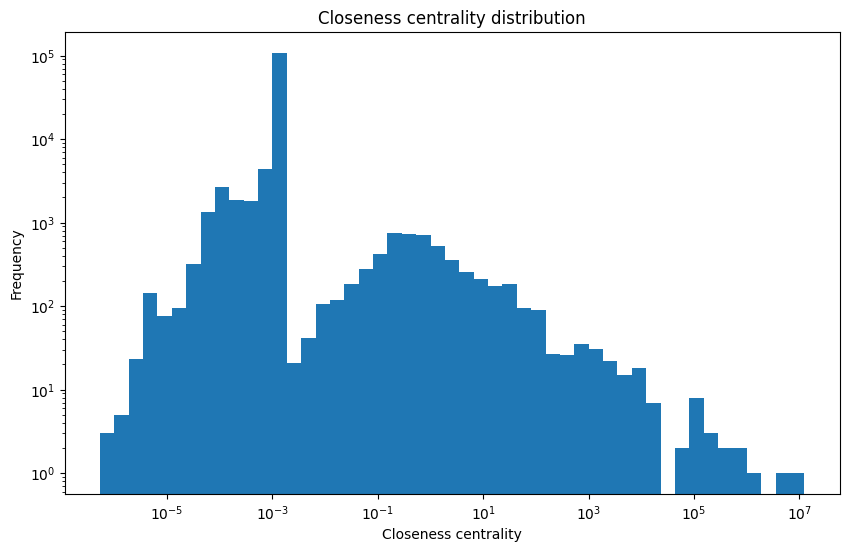

In [100]:
log_bins = np.logspace(np.log10(min(G_aave_count_igraph_closeness2.values())), np.log10(max(G_aave_count_igraph_closeness2.values())), 50)

plt.figure(figsize=(10, 6))
plt.hist(G_aave_count_igraph_closeness2.values(), bins=log_bins)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Closeness centrality')
plt.ylabel('Frequency')
plt.title('Closeness centrality distribution')
plt.yscale('log')
plt.show()

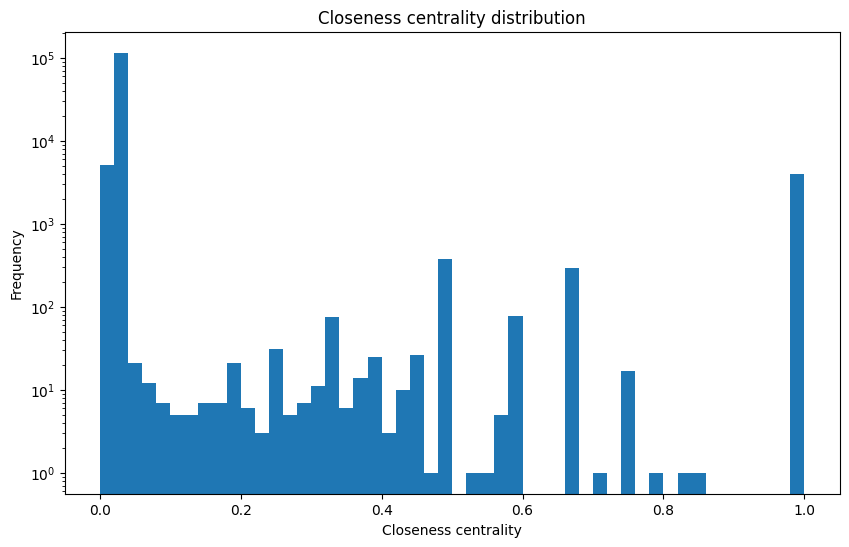

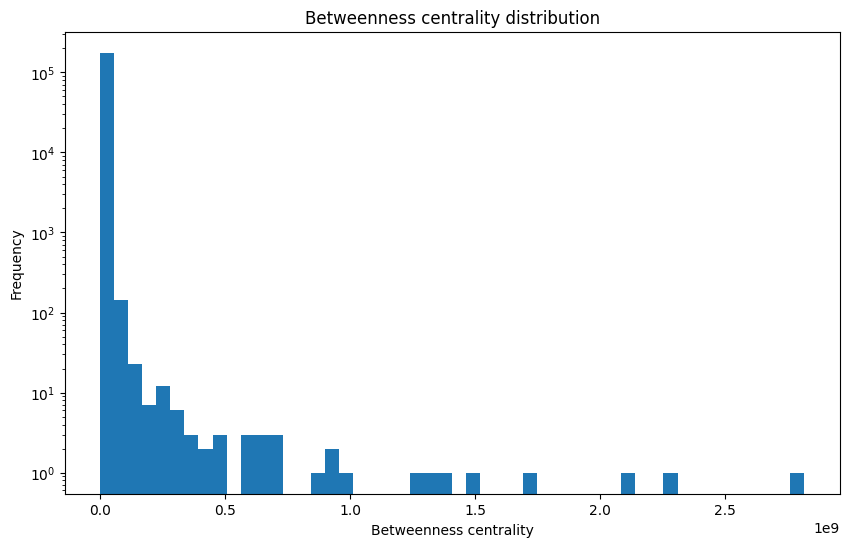

In [44]:
def plot_centrality_distribution(centrality_scores, title, xlabel):
    plt.figure(figsize=(10, 6))
    plt.hist(centrality_scores.values(), bins=50)#, edgecolor='black')
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.yscale('log')
    plt.show()

plot_centrality_distribution(G_aave_count_igraph_closeness2, 
                              'Closeness centrality distribution', 
                              'Closeness centrality')

plot_centrality_distribution(G_aave_count_igraph_betweenness2, 
                              'Betweenness centrality distribution', 
                              'Betweenness centrality')

## Correlation analysis

### Comparing only the overlapping nodes

In [16]:
all_AAVE_transfers = aave_df.melt(value_vars=['from', 'to'], id_vars=['value'], value_name='address')
average_AAVE_tokens = all_AAVE_transfers.groupby('address')['value'].mean().to_dict()
AAVE_transfer_counts = all_AAVE_transfers['address'].value_counts().to_dict()

all_aToken_transfers = aToken_df.melt(value_vars=['from', 'to'], id_vars=['value'], value_name='address')
average_aWETH_tokens = all_aToken_transfers.groupby('address')['value'].mean().to_dict()
aWETH_transfer_counts = all_aToken_transfers['address'].value_counts().to_dict()

In [ ]:
all_AAVE_users = pd.concat([aave_df[['from', 'value']].rename(columns={'from': 'user'}), aave_df[['to', 'value']].rename(columns={'to': 'user'})])

avg_all_AAVE_transfers = all_AAVE_users.groupby('user')['value'].mean().to_dict()
avg_outgoing_AAVE = aave_df.groupby('from')['value'].mean().to_dict()
avg_incoming_AAVE = aave_df.groupby('to')['value'].mean().to_dict()


all_aWETH_users = pd.concat([aToken_df[['from', 'value']].rename(columns={'from': 'user'}), aToken_df[['to', 'value']].rename(columns={'to': 'user'})])

avg_all_aWETH_transfers = all_aWETH_users.groupby('user')['value'].mean().to_dict()
avg_outgoing_aWETH = aToken_df.groupby('from')['value'].mean().to_dict()
avg_incoming_aWETH = aToken_df.groupby('to')['value'].mean().to_dict()

In [29]:
total_AAVE_transferred_mapping = {}
from_AAVE_transferred_mapping = {}
to_AAVE_transferred_mapping = {}
average_AAVE_transferred_mapping = avg_all_AAVE_transfers
average_from_AAVE_transferred_mapping = avg_outgoing_AAVE
average_to_AAVE_transferred_mapping = avg_incoming_AAVE
number_of_AAVE_transfers_mapping = AAVE_transfer_counts

votes_casted_mapping = {}
delegation_counts_mapping = {}
from_delegations_mapping = {}
to_delegations_mapping = {}
average_vote_weights_mapping = {}

total_aWETH_transferred_mapping = {}
from_aWETH_transferred_mapping = {}
to_aWETH_transferred_mapping = {}
average_aWETH_transferred_mapping = avg_all_aWETH_transfers
average_from_aWETH_transferred_mapping = avg_outgoing_aWETH
average_to_aWETH_transferred_mapping = avg_incoming_aWETH
number_of_aWETH_transfers_mapping = aWETH_transfer_counts

for _, row in aave_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if from_address in total_AAVE_transferred_mapping:
        total_AAVE_transferred_mapping[from_address] += value
    else:
        total_AAVE_transferred_mapping[from_address] = value
        
    if from_address in from_AAVE_transferred_mapping:
        from_AAVE_transferred_mapping[from_address] += value
    else:
        from_AAVE_transferred_mapping[from_address] = value
    
    if to_address in total_AAVE_transferred_mapping:
        total_AAVE_transferred_mapping[to_address] += value
    else:
        total_AAVE_transferred_mapping[to_address] = value
        
    if to_address in to_AAVE_transferred_mapping:
        to_AAVE_transferred_mapping[to_address] += value
    else:
        to_AAVE_transferred_mapping[to_address] = value
        
        
# for user, average in average_AAVE_tokens.items():
#     if user in average_AAVE_transferred_mapping:
#         average_AAVE_transferred_mapping[user] = average
        
# for user, count in AAVE_transfer_counts.items():
#     if user in number_of_AAVE_transfers_mapping:
#         number_of_AAVE_transfers_mapping[user] = count


for voter, count in vote_counts.items():
    votes_casted_mapping[voter] = count

for delegator, count in delegation_counts.items():
    delegation_counts_mapping[delegator] = count

for delegator, count in from_delegations.items():
    from_delegations_mapping[delegator] = count

for delegate, count in to_delegations.items():
    to_delegations_mapping[delegate] = count

for voter, weight in vote_weights.items():
    average_vote_weights_mapping[voter] = weight


for _, row in aToken_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if from_address in total_aWETH_transferred_mapping:
        total_aWETH_transferred_mapping[from_address] += value
    else:
        total_aWETH_transferred_mapping[from_address] = value
        
    if from_address in from_aWETH_transferred_mapping:
        from_aWETH_transferred_mapping[from_address] += value
    else:
        from_aWETH_transferred_mapping[from_address] = value
        
    if to_address in total_aWETH_transferred_mapping:
        total_aWETH_transferred_mapping[to_address] += value
    else:
        total_aWETH_transferred_mapping[to_address] = value
        
    if to_address in to_aWETH_transferred_mapping:
        to_aWETH_transferred_mapping[to_address] += value
    else:
        to_aWETH_transferred_mapping[to_address] = value

# for user, average in average_aWETH_tokens.items():
#     if user in average_aWETH_transferred_mapping:
#         average_aWETH_transferred_mapping[user] = average
        
# for user, count in aWETH_transfer_counts.items():
#     if user in number_of_aWETH_transfers_mapping:
#         number_of_aWETH_transfers_mapping[user] = count

# addresses = sorted(average_AAVE_transferred_mapping.keys())

In [36]:
def compute_overlapping_correlations(x_name, x_map, y_name, y_map, results):
    valid_addresses = [address for address in x_map.keys() & y_map.keys()]
    
    scores_x = [x_map[address] for address in valid_addresses]
    scores_y = [y_map[address] for address in valid_addresses]
    
    spearman = spearmanr(scores_x, scores_y)
    kendall = kendalltau(scores_x, scores_y)
    
    results.append({
        'x_name': x_name,
        'y_name': y_name,
        'spearman': spearman,
        'kendall': kendall,
        'valid_addresses': valid_addresses
    })

In [63]:
# USING THE SCORES AND METRICS WITH OWN COMPUTATIONS INSTEAD OF BUILT-IN FUNCTIONS
AAVE_mappings = [
    ('AAVE In-DC', aave_igraph_in_dc),
    ('AAVE Out-DC', aave_igraph_out_dc),
    ('AAVE Eigenvector Centrality', aave_igraph_ec),
    ('AAVE Clustering Coefficient', aave_igraph_cc),
    ('Total AAVE transferred', total_AAVE_transferred_mapping),
    # ('Total AAVE sent', from_AAVE_transferred_mapping),
    # ('Total AAVE received', to_AAVE_transferred_mapping),
    # ('Average AAVE per transfer', average_AAVE_transferred_mapping),
    # ('Average AAVE sent per transfer', average_from_AAVE_transferred_mapping),
    # ('Average AAVE received per transfer', average_to_AAVE_transferred_mapping),
    ('Number of AAVE transfers', number_of_AAVE_transfers_mapping),
    ('AAVE 2-hop weights', aave_igraph_2_hop_weights),
    ('AAVE Burstiness', aave_burstiness_total)
]

gov_mappings = [
    ('Votes casted', votes_casted_mapping),
    # ('From delegations', from_delegations_mapping),
    ('To delegations', to_delegations_mapping),
    ('Average vote weight', average_vote_weights_mapping)
]    

aWETH_mappings = [
    ('aWETH In-DC', aWETH_igraph_in_dc),
    ('aWETH Out-DC', aWETH_igraph_out_dc),
    # ('aWETH Eigenvector Centrality', aWETH_igraph_ec),
    # ('aWETH Clustering Coefficient', aWETH_igraph_cc),
    ('Total aWETH transferred', total_aWETH_transferred_mapping),
    # ('Total aWETH sent', from_aWETH_transferred_mapping),
    # ('Total aWETH received', to_aWETH_transferred_mapping),
    # ('Average aWETH per transfer', average_aWETH_transferred_mapping),
    # ('Average aWETH sent per transfer', average_from_aWETH_transferred_mapping),
    # ('Average aWETH received per transfer', average_to_aWETH_transferred_mapping),
    ('Number of aWETH transfers', number_of_aWETH_transfers_mapping),
    ('aWETH Burstiness (B_total)', aWETH_burstiness_total)
]

mapping_dict = dict(AAVE_mappings) | dict(gov_mappings) | dict(aWETH_mappings)

# nonzero_results = []

# for (x_name, x_map), (y_name, y_map) in itertools.product(AAVE_mappings, gov_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

# for (x_name, x_map), (y_name, y_map) in itertools.product(AAVE_mappings, aWETH_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

# for (x_name, x_map), (y_name, y_map) in itertools.product(aWETH_mappings, gov_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

#####

# aave_gov_results = []
# aave_aWETH_results = []
# aWETH_gov_results = []

# for (x_name, x_map), (y_name, y_map) in itertools.product(AAVE_mappings, gov_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, aave_gov_results)

# for (x_name, x_map), (y_name, y_map) in itertools.product(AAVE_mappings, aWETH_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, aave_aWETH_results)

# for (x_name, x_map), (y_name, y_map) in itertools.product(aWETH_mappings, gov_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, aWETH_gov_results)


threshold = 0.7

for res in nonzero_results:
    spearman = res['spearman']
    kendall = res['kendall']
    
    if spearman.statistic > threshold or kendall.statistic > threshold:
    # if spearman.statistic < threshold or kendall.statistic < threshold:
        valid_addresses = res['valid_addresses']
        percentage_of_addresses = (len(valid_addresses)/len(G_aave_nodes)) * 100
        
        print(f'{res["x_name"]} vs {res["y_name"]} -> Spearman: {spearman.statistic:.3f}, Kendall: {kendall.statistic:.3f}, number of addresses: {len(valid_addresses)}, percentage of addresses: {percentage_of_addresses:.2f}%')
        # print()
        
        # x_map = mapping_dict.get(res['x_name'])
        # y_map = mapping_dict.get(res['y_name'])

        # x_vals = [x_map[address] for address in valid_addresses]
        # y_vals = [y_map[address] for address in valid_addresses]
        
        # fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # axes[0].scatter(x_vals, y_vals, alpha=0.6)
        # axes[0].set_xlabel(res['x_name'])
        # axes[0].set_ylabel(res['y_name'])
        # axes[0].set_title('Original Scale')

        # # log_x = np.log(x_vals)
        # # log_y = np.log(y_vals)
        # # sns.regplot(x=log_x, y=log_y, ax=axes[1])
        # # axes[1].set_xlabel(f'Log({res["x_name"]})')
        # # axes[1].set_ylabel(f'Log({res["y_name"]})')
        # # axes[1].set_title('Log-Log Scale')
        # ####
        # axes[1].scatter(x_vals, y_vals, alpha=0.6)
        # axes[1].set_xscale('log')
        # axes[1].set_yscale('log')
        # axes[1].set_xlabel(res['x_name'])
        # axes[1].set_ylabel(res['y_name'])
        # axes[1].set_title('Log-Scaled Axes')

        # plt.tight_layout()
        # plt.show()

AAVE Clustering Coefficient vs Average vote weight -> Spearman: 0.709, Kendall: 0.579, number of addresses: 1286, percentage of addresses: 0.68%
Total AAVE transferred vs Average vote weight -> Spearman: 0.943, Kendall: 0.871, number of addresses: 1286, percentage of addresses: 0.68%
Total AAVE transferred vs Total aWETH transferred -> Spearman: 0.722, Kendall: 0.544, number of addresses: 10169, percentage of addresses: 5.40%


In [103]:
with open('AAVE_mappings.json', 'w') as f:
    json.dump({name: mapping for name, mapping in AAVE_mappings}, f)

with open('gov_mappings.json', 'w') as f:
    json.dump({name: mapping for name, mapping in gov_mappings}, f)

with open('aWETH_mappings.json', 'w') as f:
    json.dump({name: mapping for name, mapping in aWETH_mappings}, f)

In [ ]:
# COMPUTING CORRELATIONS WITHIN THE DATASETS
AAVE_mappings = [
    ('AAVE In-DC', aave_igraph_in_dc),
    ('AAVE Out-DC', aave_igraph_out_dc),
    ('AAVE Eigenvector Centrality', aave_igraph_ec),
    ('AAVE Clustering Coefficient', aave_igraph_cc),
    ('Total AAVE transferred', total_AAVE_transferred_mapping),
    # ('Total AAVE sent', from_AAVE_transferred_mapping),
    # ('Total AAVE received', to_AAVE_transferred_mapping),
    # ('Average AAVE per transfer', average_AAVE_transferred_mapping),
    # ('Average AAVE sent per transfer', average_from_AAVE_transferred_mapping),
    # ('Average AAVE received per transfer', average_to_AAVE_transferred_mapping),
    ('Number of AAVE transfers', number_of_AAVE_transfers_mapping),
    ('AAVE 2-hop weights', aave_igraph_2_hop_weights),
    ('AAVE Burstiness', aave_burstiness_total)
]

gov_mappings = [
    ('Votes casted', votes_casted_mapping),
    # ('From delegations', from_delegations_mapping),
    ('To delegations', to_delegations_mapping),
    ('Average vote weight', average_vote_weights_mapping)
]    

aWETH_mappings = [
    ('aWETH In-DC', aWETH_igraph_in_dc),
    ('aWETH Out-DC', aWETH_igraph_out_dc),
    # ('aWETH Eigenvector Centrality', aWETH_igraph_ec),
    # ('aWETH Clustering Coefficient', aWETH_igraph_cc),
    ('Total aWETH transferred', total_aWETH_transferred_mapping),
    # ('Total aWETH sent', from_aWETH_transferred_mapping),
    # ('Total aWETH received', to_aWETH_transferred_mapping),
    # ('Average aWETH per transfer', average_aWETH_transferred_mapping),
    # ('Average aWETH sent per transfer', average_from_aWETH_transferred_mapping),
    # ('Average aWETH received per transfer', average_to_aWETH_transferred_mapping),
    ('Number of aWETH transfers', number_of_aWETH_transfers_mapping),
    ('aWETH Burstiness (B_total)', aWETH_burstiness_total)
]

mapping_dict = dict(AAVE_mappings) | dict(gov_mappings) | dict(aWETH_mappings)

# nonzero_results = []

# for (x_name, x_map), (y_name, y_map) in list(combinations(AAVE_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)
    
# for (x_name, x_map), (y_name, y_map) in list(combinations(aWETH_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)
    
# for (x_name, x_map), (y_name, y_map) in list(combinations(gov_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

#####

aave_results = []
aWETH_results = []
gov_results = []

for (x_name, x_map), (y_name, y_map) in list(combinations(AAVE_mappings, 2)):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, aave_results)
    
for (x_name, x_map), (y_name, y_map) in list(combinations(aWETH_mappings, 2)):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, aWETH_results)
    
for (x_name, x_map), (y_name, y_map) in list(combinations(gov_mappings, 2)):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, gov_results)

# threshold = 0.9

# for res in nonzero_results:
#     spearman = res['spearman']
#     kendall = res['kendall']
    
#     if spearman.statistic > threshold or kendall.statistic > threshold:
#     # if spearman.statistic < threshold or kendall.statistic < threshold:
#         valid_addresses = res['valid_addresses']
        
#         print(f'{res["x_name"]} vs {res["y_name"]} -> Spearman: {spearman.statistic:.3f}, Kendall: {kendall.statistic:.3f}, number of addresses: {len(valid_addresses)}')
#         # print(f'Spearman p-value: {spearman.pvalue:.3f}, Kendall p-value: {kendall.pvalue:.3f}')
#         # print()
        
#         # x_map = mapping_dict.get(res['x_name'])
#         # y_map = mapping_dict.get(res['y_name'])
        
#         # plt.figure(figsize=(10, 6))
#         # plt.scatter([x_map[address] for address in valid_addresses], [y_map[address] for address in valid_addresses], alpha=0.6)
#         # plt.xlabel(res['x_name'])
#         # plt.ylabel(res['y_name'])
#         # plt.show()
        
#         # log_x = np.log1p([x_map[address] for address in valid_addresses])
#         # log_y = np.log1p([y_map[address] for address in valid_addresses])

#         # sns.regplot(x=log_x, y=log_y)
#         # plt.xlabel(f'Log({res["x_name"]})')
#         # plt.ylabel(f'Log({res["y_name"]})')
#         # plt.show()

Total AAVE transferred vs Total AAVE sent -> Spearman: 0.991, Kendall: 0.943, number of addresses: 131875
Total AAVE transferred vs Total AAVE received -> Spearman: 0.993, Kendall: 0.949, number of addresses: 155952
Total AAVE sent vs Total AAVE received -> Spearman: 0.989, Kendall: 0.968, number of addresses: 99358


### Correlation heatmaps

In [49]:
def create_heatmap(results):
    def unique_ordered(items):
        seen = set()
        ordered = []
        for item in items:
            if item not in seen:
                seen.add(item)
                ordered.append(item)
        return ordered

    x_datasets = unique_ordered([entry['x_name'] for entry in results])
    y_datasets = unique_ordered([entry['y_name'] for entry in results])

    spearman_corr_matrix = np.zeros((len(x_datasets), len(y_datasets)))
    kendall_corr_matrix = np.zeros((len(x_datasets), len(y_datasets)))

    for entry in results:
        x_idx = x_datasets.index(entry['x_name'])
        y_idx = y_datasets.index(entry['y_name'])
        spearman_corr_matrix[x_idx, y_idx] = entry['spearman'].statistic
        kendall_corr_matrix[x_idx, y_idx] = entry['kendall'].statistic

    spearman_corr_df = pd.DataFrame(spearman_corr_matrix, index=x_datasets, columns=y_datasets)
    kendall_corr_df = pd.DataFrame(kendall_corr_matrix, index=x_datasets, columns=y_datasets)

    plt.figure(figsize=(8, 6))
    sns.heatmap(spearman_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    plt.title("Spearman correlation heatmap")
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(kendall_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    plt.title("Kendall correlation heatmap")
    plt.show()

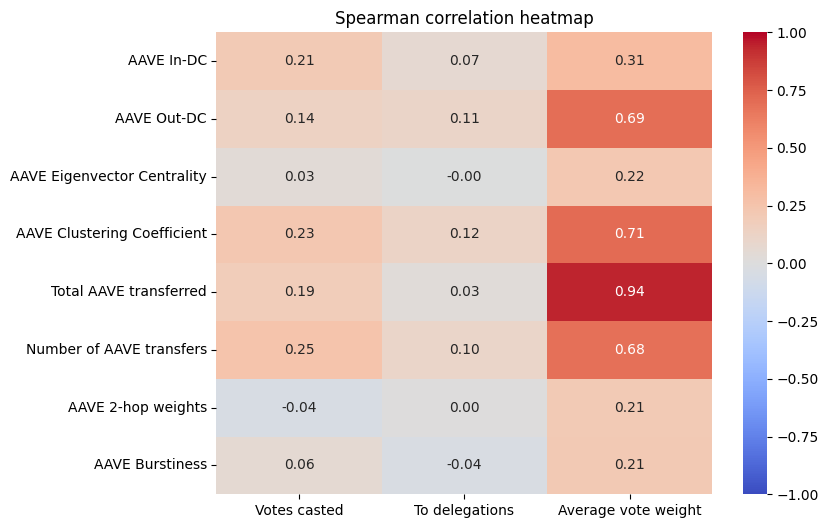

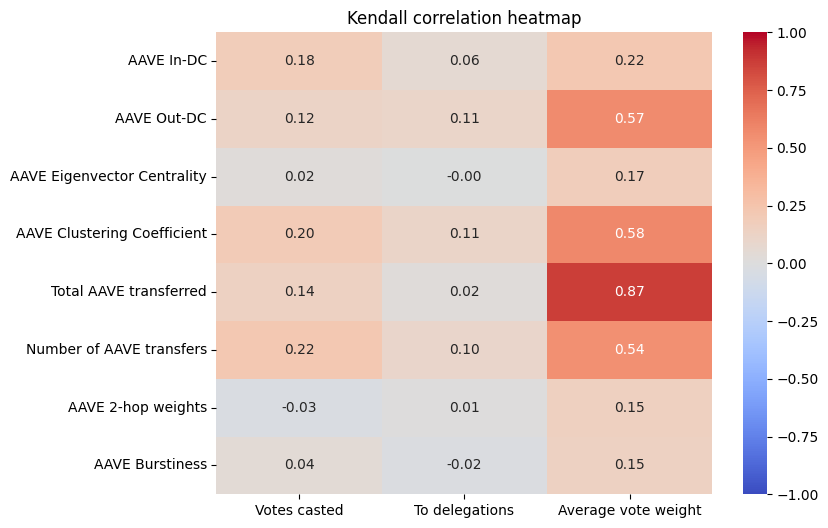

In [50]:
create_heatmap(aave_gov_results)

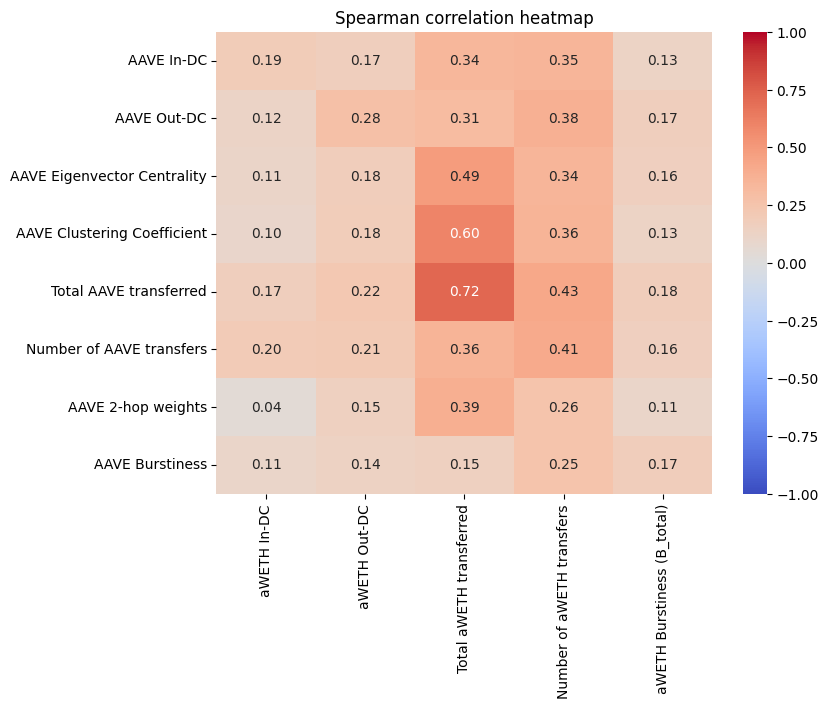

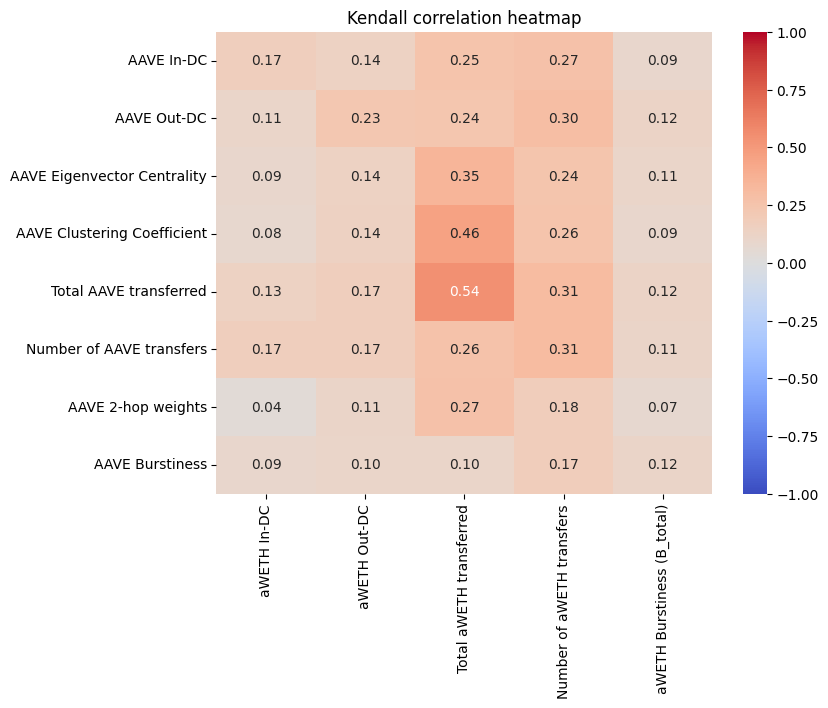

In [51]:
create_heatmap(aave_aWETH_results)

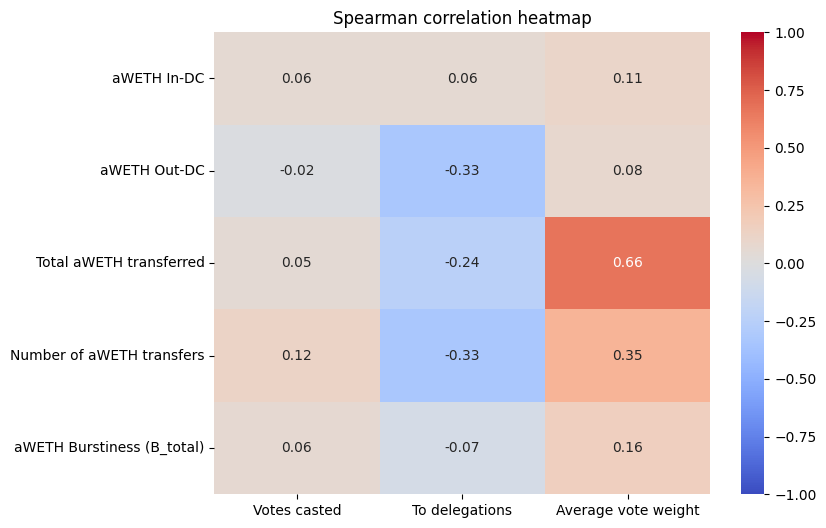

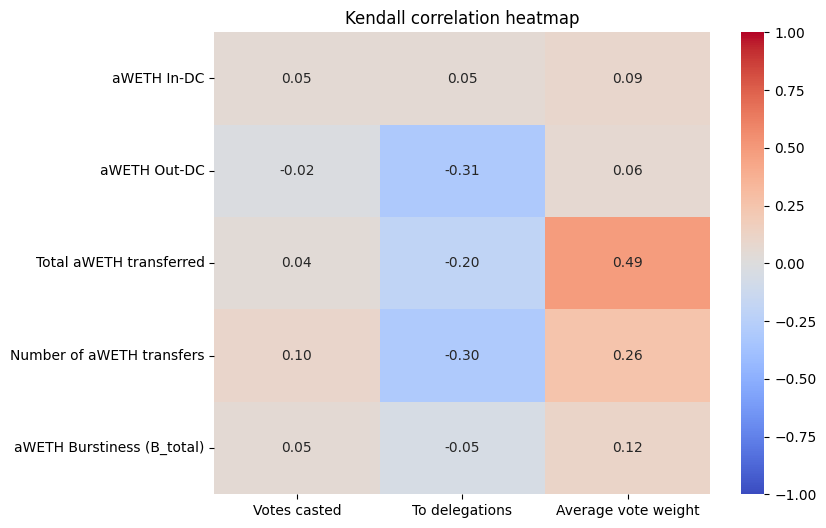

In [52]:
create_heatmap(aWETH_gov_results)

In [82]:
def create_lower_triangle_heatmap(results):
    def unique_ordered(items):
        seen = set()
        ordered = []
        for item in items:
            if item not in seen:
                seen.add(item)
                ordered.append(item)
        return ordered

    feature_names = unique_ordered(
        [entry['x_name'] for entry in results] + [entry['y_name'] for entry in results]
    )

    n = len(feature_names)
    spearman_corr_matrix = np.zeros((n, n))
    kendall_corr_matrix = np.zeros((n, n))

    for entry in results:
        x_idx = feature_names.index(entry['x_name'])
        y_idx = feature_names.index(entry['y_name'])
        spearman = entry['spearman'].statistic
        kendall = entry['kendall'].statistic

        spearman_corr_matrix[x_idx, y_idx] = spearman
        spearman_corr_matrix[y_idx, x_idx] = spearman
        kendall_corr_matrix[x_idx, y_idx] = kendall
        kendall_corr_matrix[y_idx, x_idx] = kendall

    mask = np.triu(np.ones_like(spearman_corr_matrix, dtype=bool), k=0)

    trimmed_feature_names_y = feature_names[1:]
    trimmed_feature_names_x = feature_names[:-1]
    spearman_corr_trimmed = spearman_corr_matrix[1:, :-1]
    kendall_corr_trimmed = kendall_corr_matrix[1:, :-1]
    mask_trimmed = mask[1:, :-1]

    spearman_corr_df = pd.DataFrame(spearman_corr_trimmed, index=trimmed_feature_names_y, columns=trimmed_feature_names_x)
    kendall_corr_df = pd.DataFrame(kendall_corr_trimmed, index=trimmed_feature_names_y, columns=trimmed_feature_names_x)

    plt.figure(figsize=(9, 7))
    sns.heatmap(spearman_corr_df, mask=mask_trimmed, annot=True, cmap='coolwarm', cbar=True,
                fmt='.2f', vmin=-1, vmax=1, square=True)
    plt.title("Spearman correlation")
    plt.show()

    plt.figure(figsize=(9, 7))
    sns.heatmap(kendall_corr_df, mask=mask_trimmed, annot=True, cmap='coolwarm', cbar=True,
                fmt='.2f', vmin=-1, vmax=1, square=True)
    plt.title("Kendall correlation")
    plt.show()


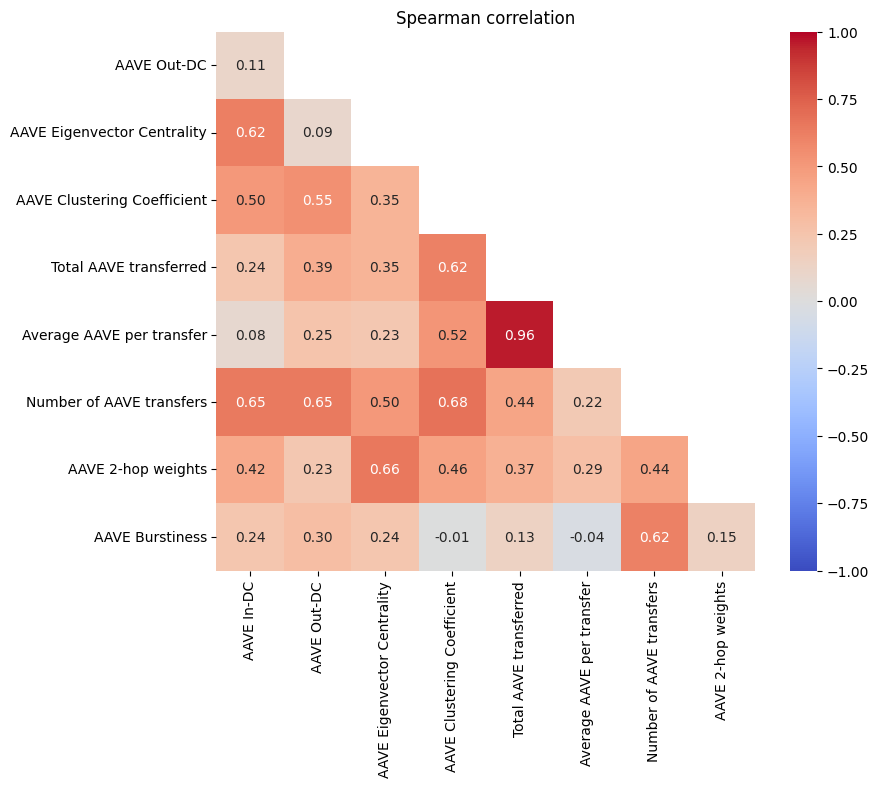

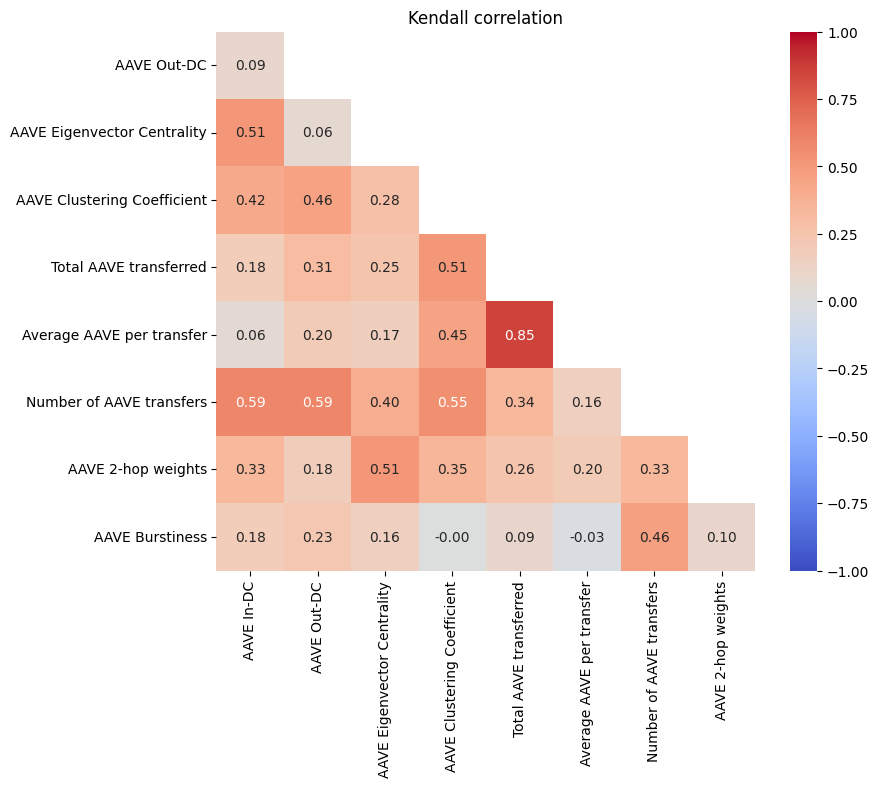

In [83]:
create_lower_triangle_heatmap(aave_results)

### Subset comparison per feature

In [64]:
aWETH_users_in_AAVE = aWETH_users & AAVE_users
governance_users_in_AAVE = (v2_proposers | v3_proposers | v2_voters | v3_voters | delegators) & AAVE_users
other_users_in_AAVE = AAVE_users - aWETH_users_in_AAVE - governance_users_in_AAVE

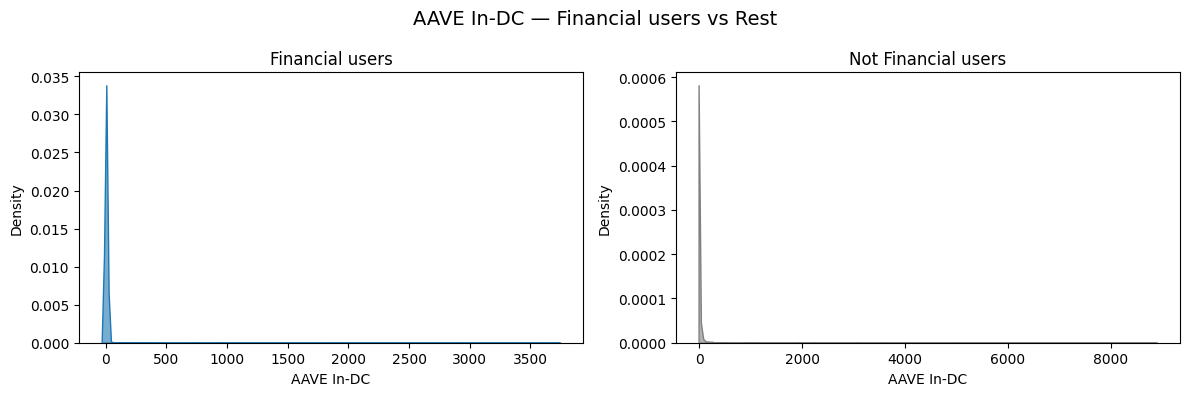

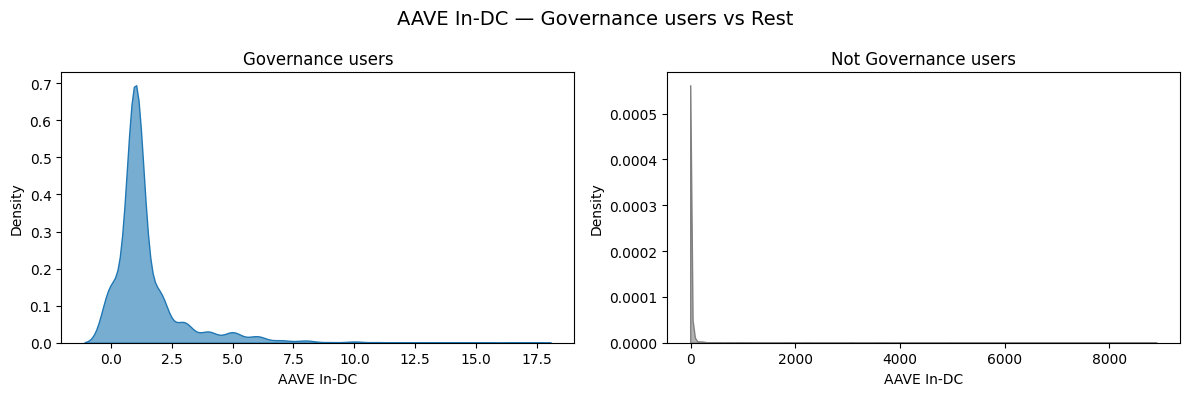

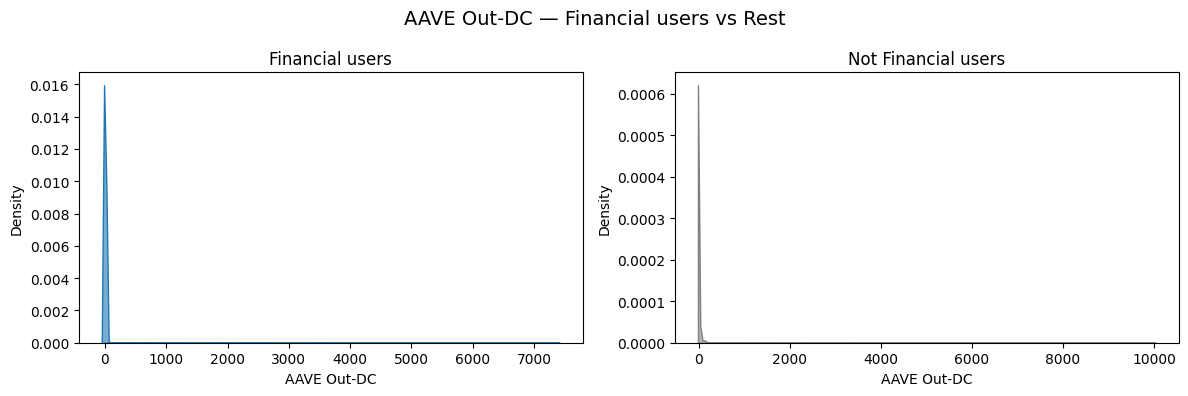

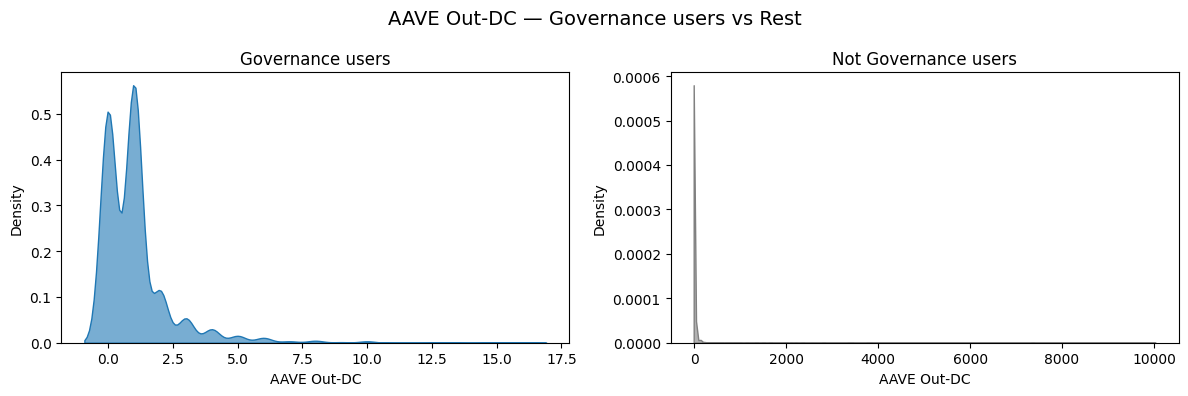

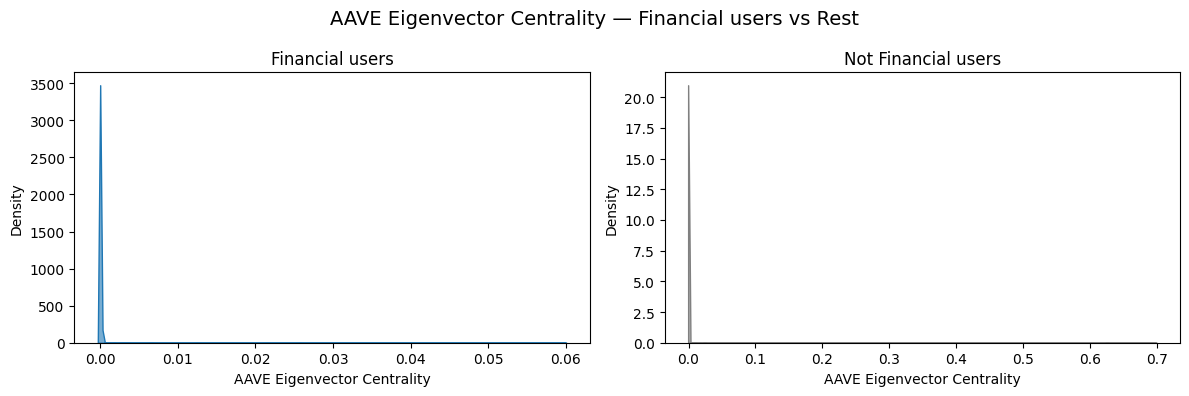

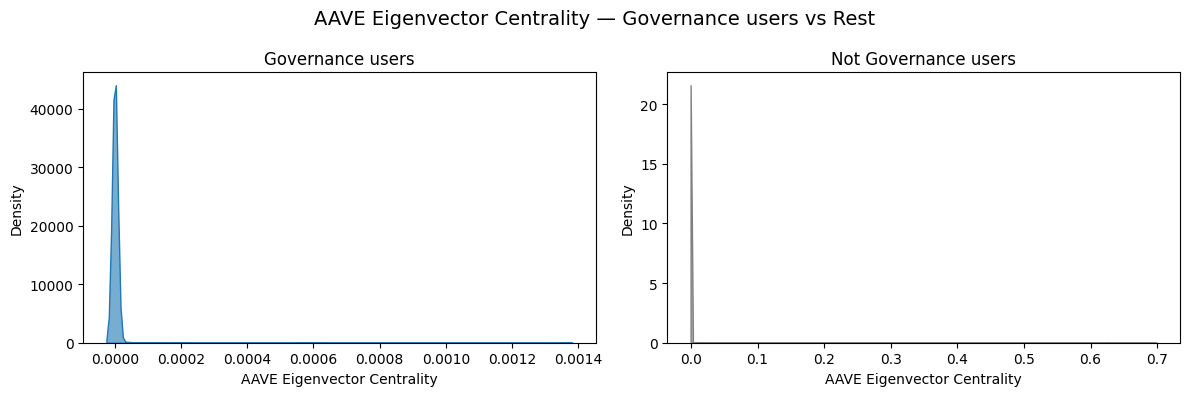

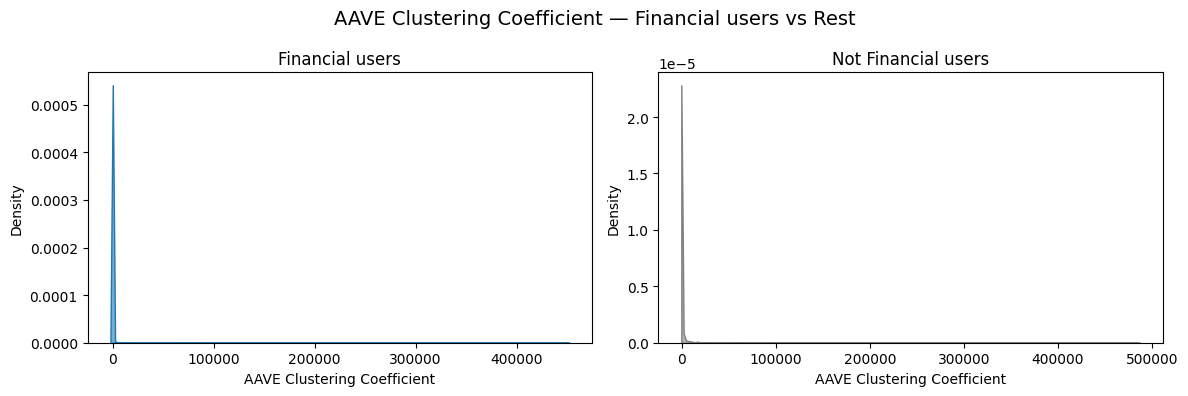

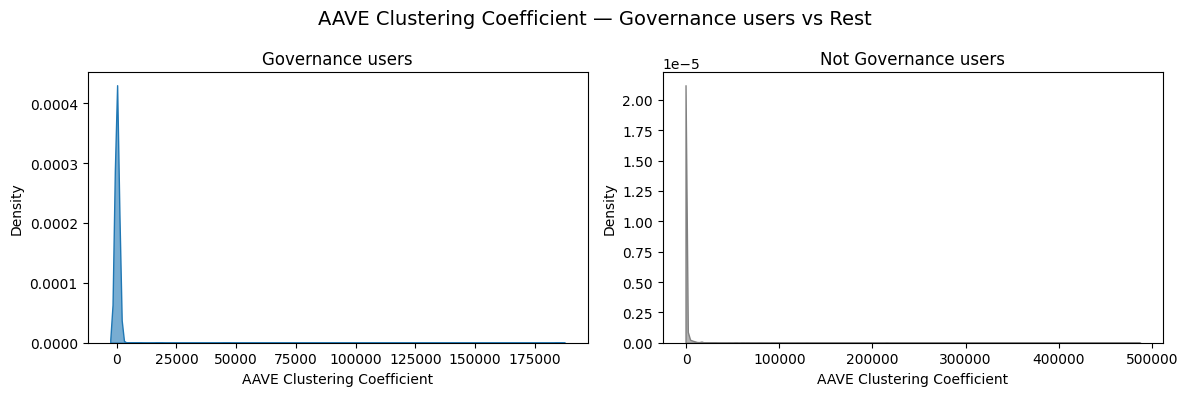

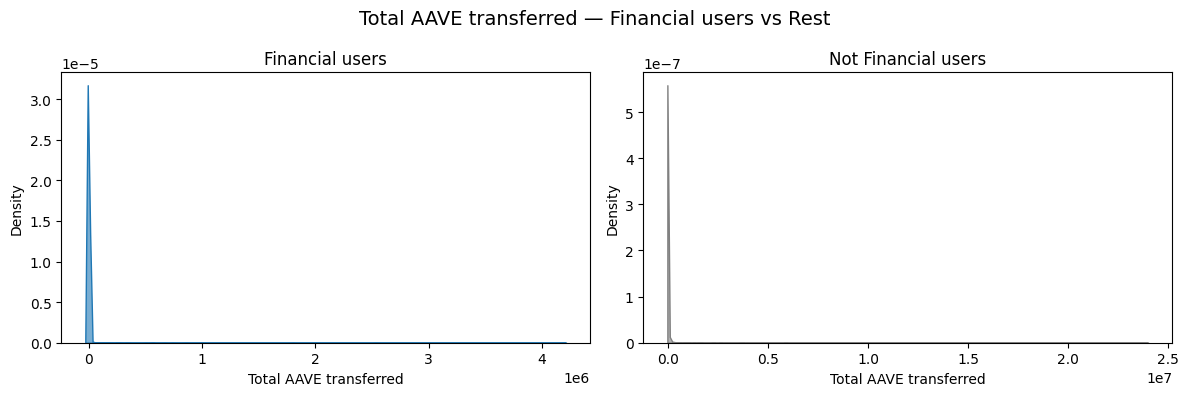

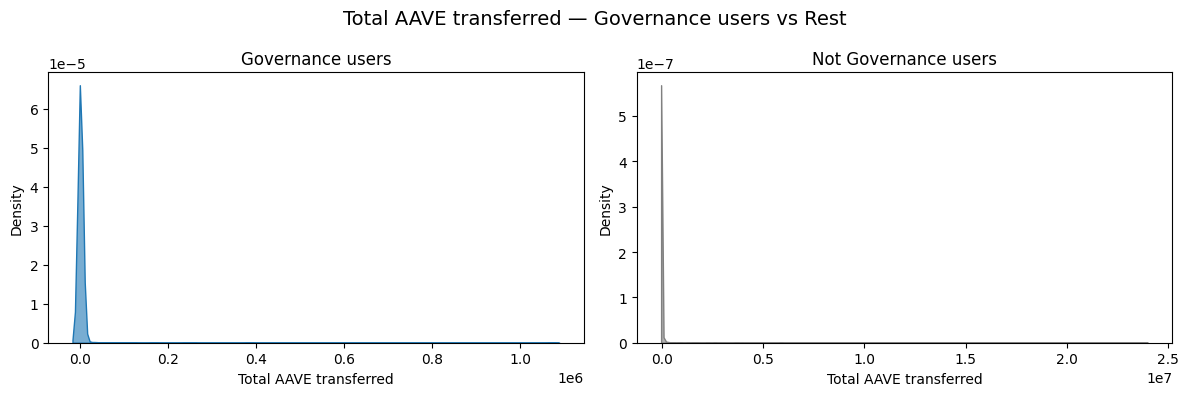

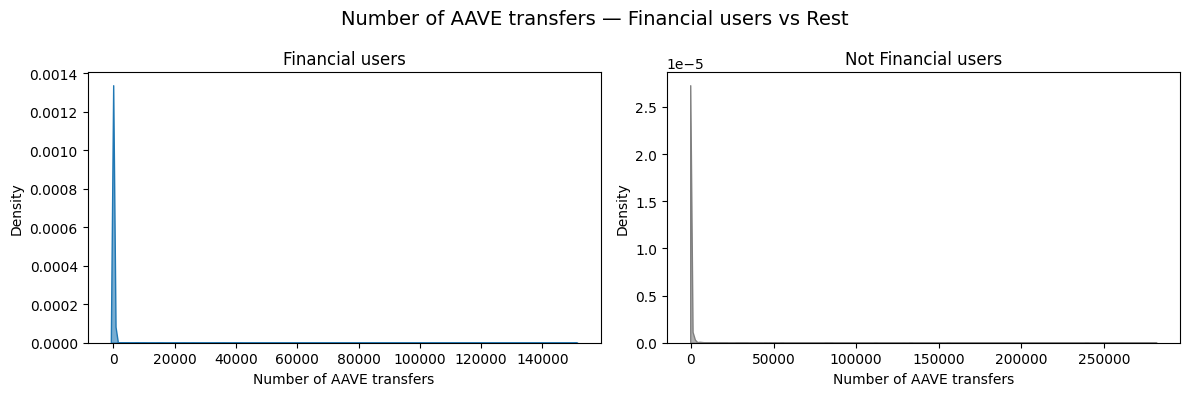

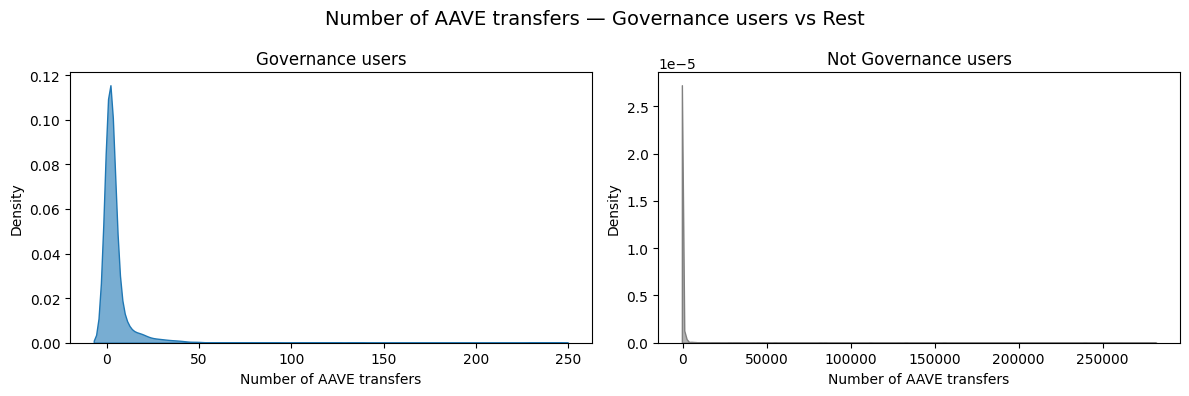

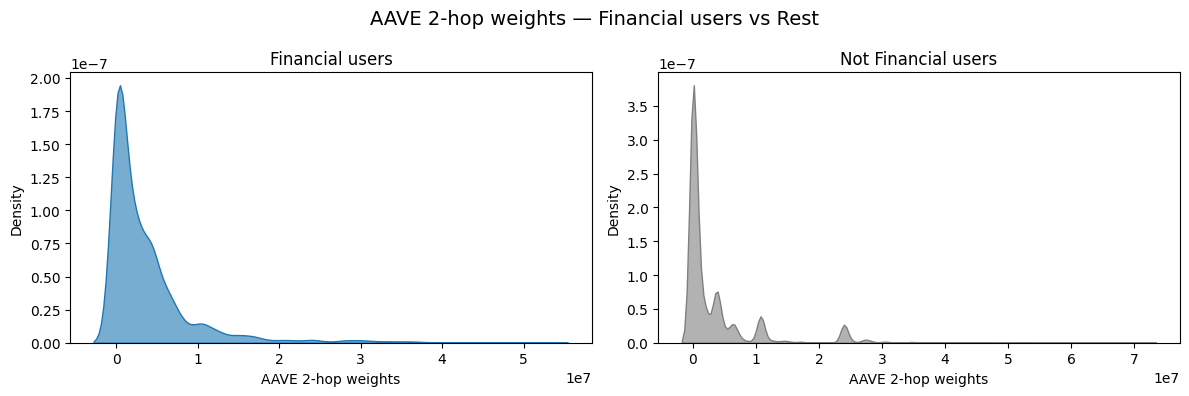

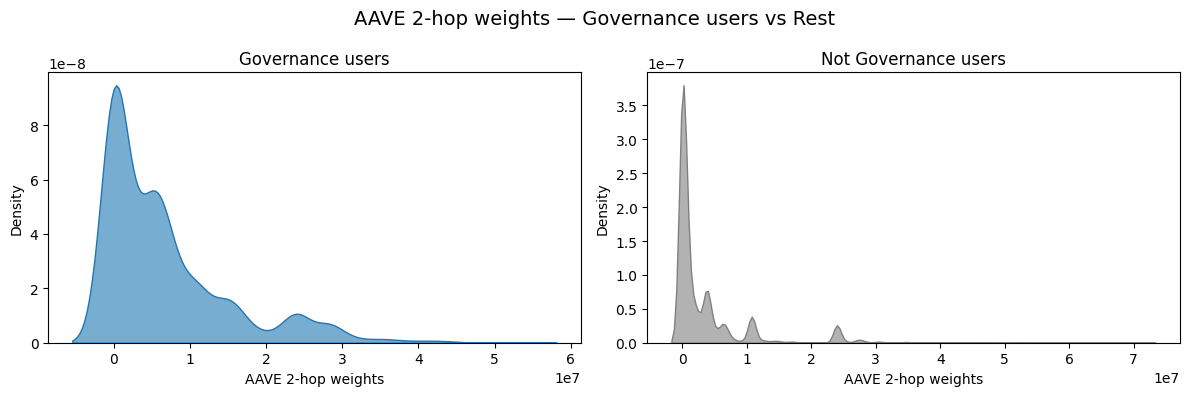

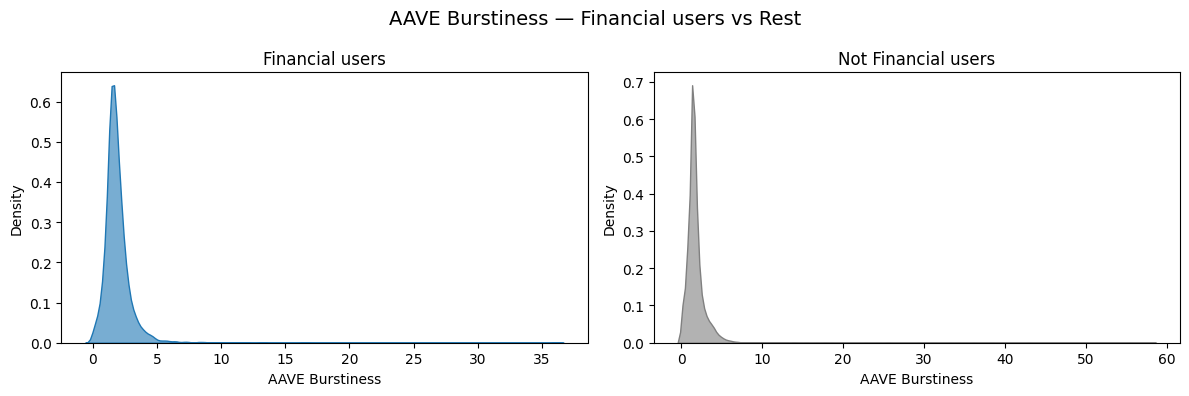

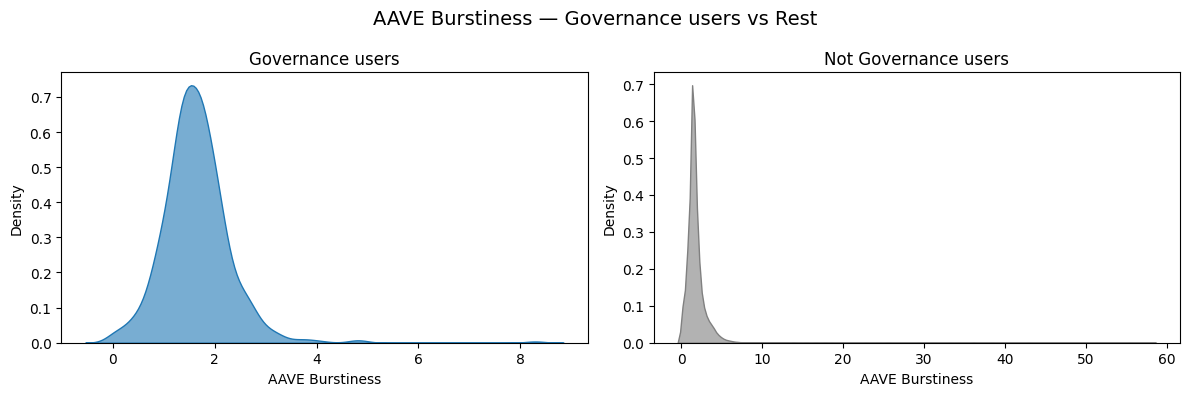

In [65]:
def plot_subset_vs_rest(feature_mapping, feature_name, use_kde=True):
    subsets = {
        'Financial users': aWETH_users_in_AAVE,
        'Governance users': governance_users_in_AAVE
    }

    for subset_name, subset in subsets.items():
        in_subset = [feature_mapping[node] for node in subset if node in feature_mapping]
        out_subset = [feature_mapping[node] for node in AAVE_users - subset if node in feature_mapping]

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        if use_kde:
            sns.kdeplot(in_subset, fill=True, alpha=0.6, ax=axes[0])
        else:
            axes[0].hist(in_subset, bins=30, alpha=0.7)
        axes[0].set_title(f'{subset_name}')
        axes[0].set_xlabel(feature_name)
        axes[0].set_ylabel('Density' if use_kde else 'Frequency')

        if use_kde:
            sns.kdeplot(out_subset, fill=True, alpha=0.6, ax=axes[1], color='gray')
        else:
            axes[1].hist(out_subset, bins=30, alpha=0.7, color='gray')
        axes[1].set_title(f'Not {subset_name}')
        axes[1].set_xlabel(feature_name)
        axes[1].set_ylabel('Density' if use_kde else 'Frequency')

        fig.suptitle(f'{feature_name} — {subset_name} vs Rest', fontsize=14)
        plt.tight_layout()
        plt.show()

for feature_name, feature_mapping in AAVE_mappings:
    plot_subset_vs_rest(feature_mapping, feature_name, use_kde=True)

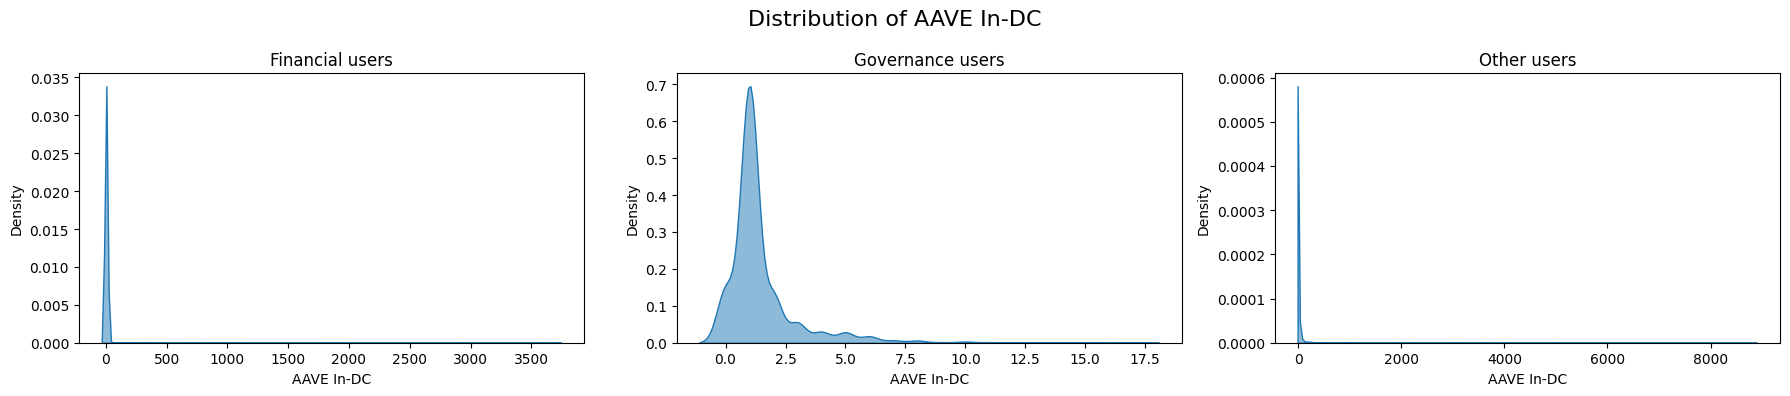

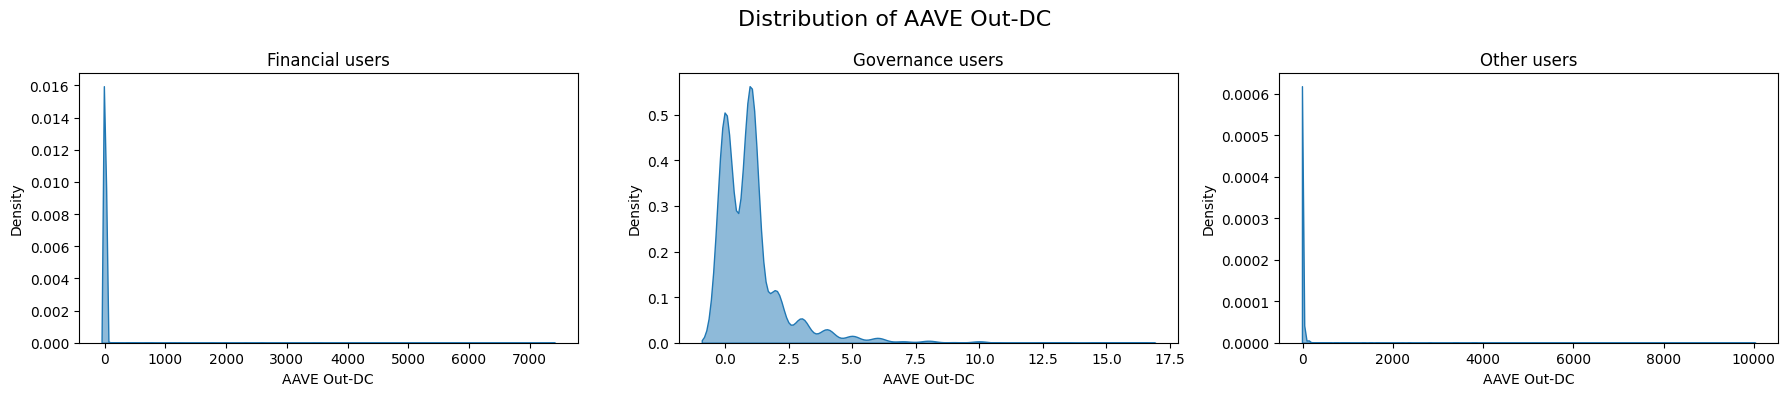

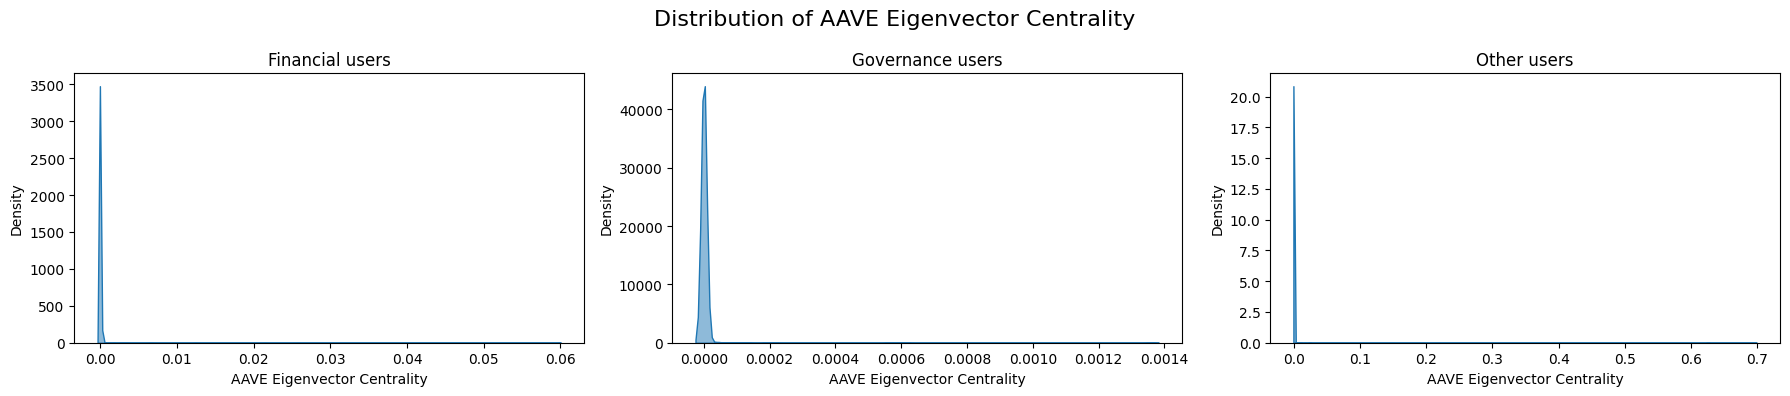

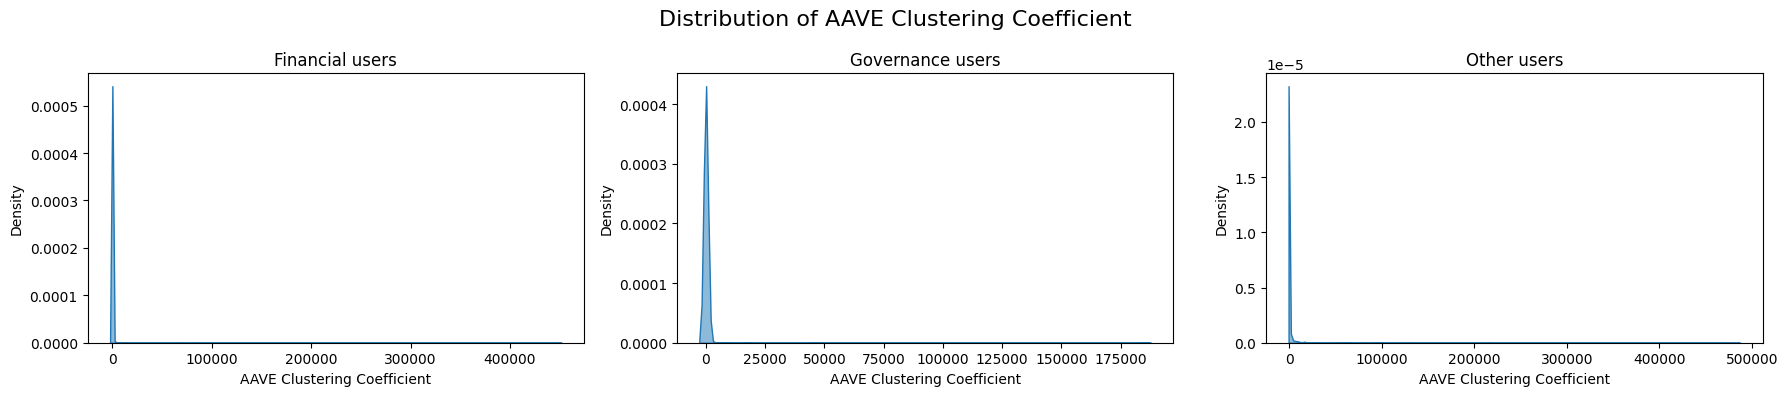

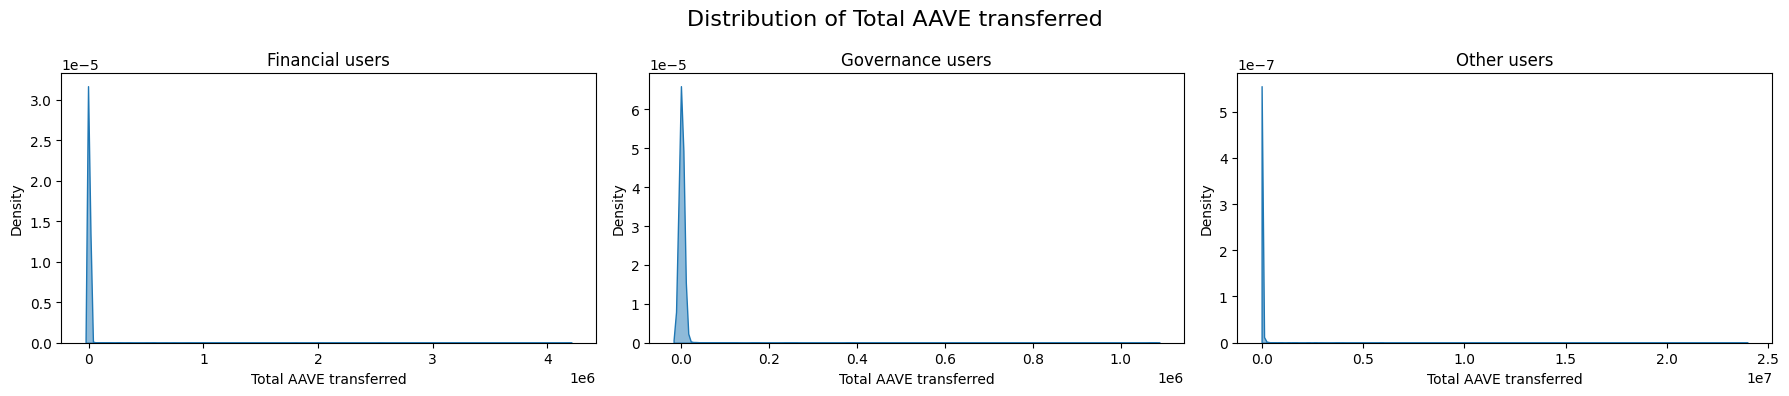

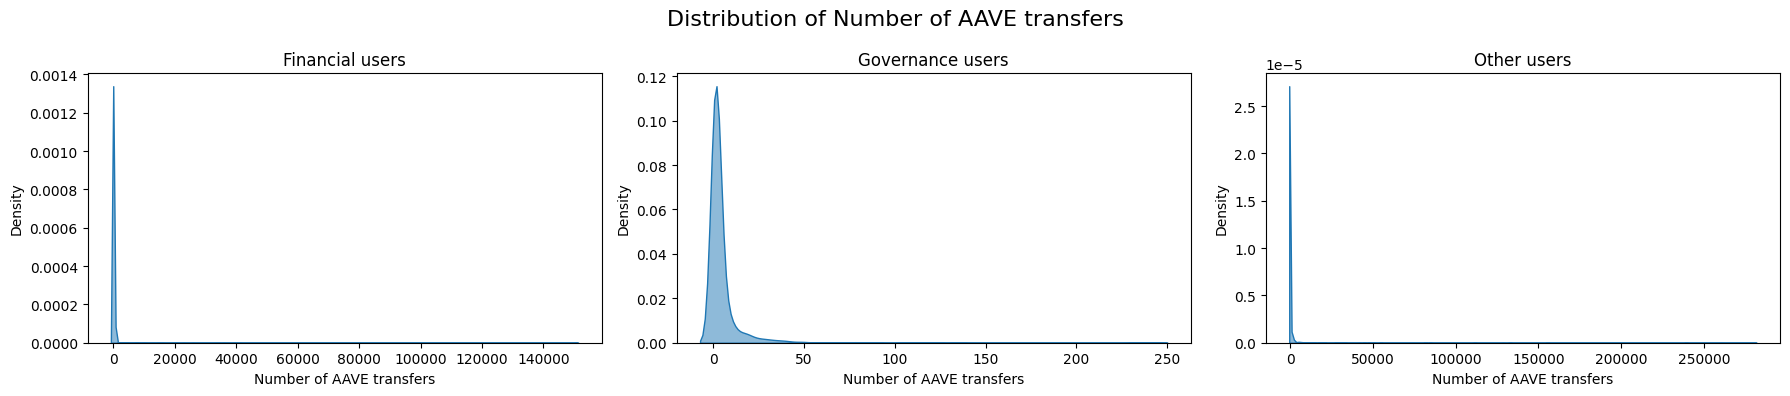

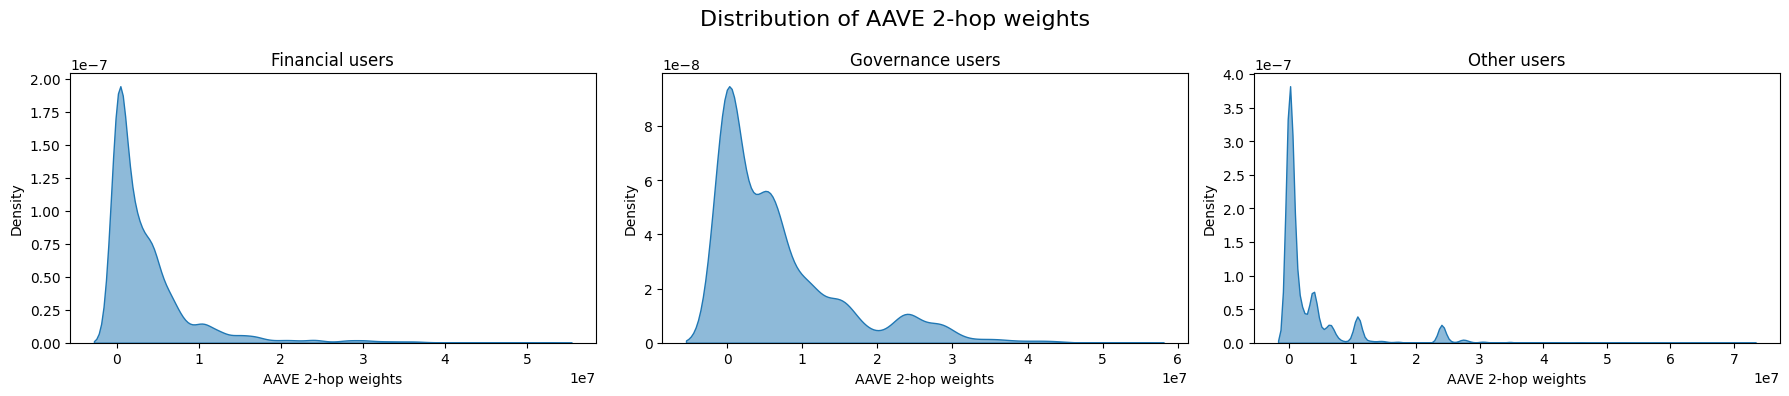

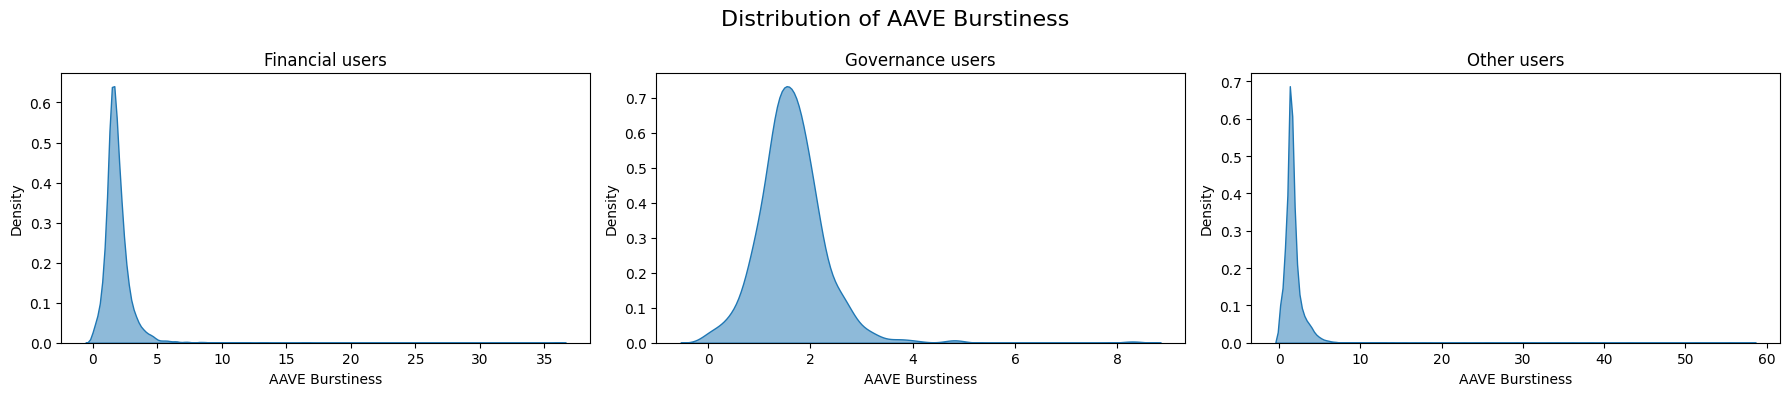

In [ ]:
def plot_feature_distributions(feature_mapping, feature_name, use_kde=True):
    subsets = {
        'Financial users': aWETH_users_in_AAVE,
        'Governance users': governance_users_in_AAVE,
        'Other users': other_users_in_AAVE
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    for ax, (subset_name, subset) in zip(axes, subsets.items()):
        subset_values = [feature_mapping[node] for node in subset if node in feature_mapping]

        if use_kde:
            sns.kdeplot(subset_values, fill=True, alpha=0.5, ax=ax)
        else:
            ax.hist(subset_values, bins=30, alpha=0.7)

        ax.set_title(subset_name)
        ax.set_xlabel(feature_name)
        ax.set_ylabel('Density' if use_kde else 'Frequency')

    fig.suptitle(f'Distribution of {feature_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

for feature_name, feature_mapping in AAVE_mappings:
    plot_feature_distributions(feature_mapping, feature_name, use_kde=True)

### Old comparisons

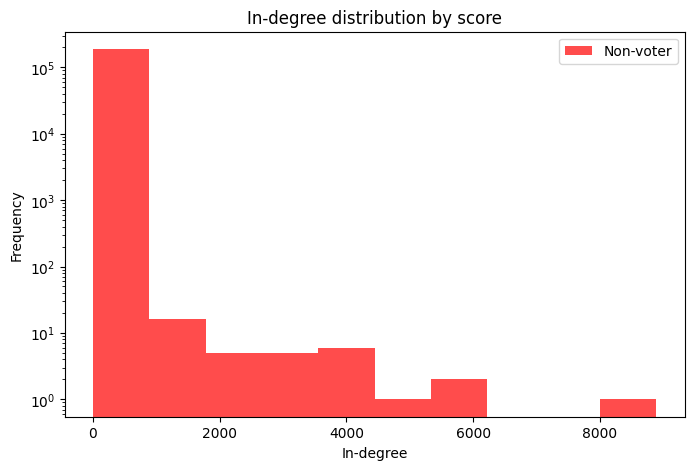

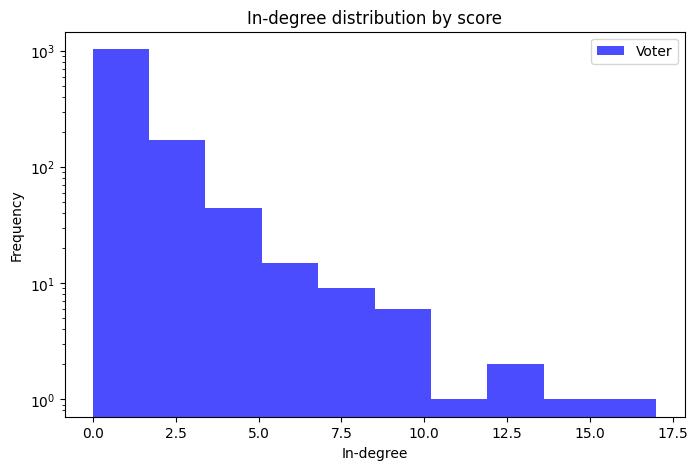

In [134]:
G_aave_in_degrees = dict(G_aave.in_degree())
# G_aave_in_degrees = dict(nx.in_degree_centrality(G_aave))

zero_scores = [degree for node, degree in G_aave_in_degrees.items() if node != "0x0000000000000000000000000000000000000000" and node not in votes_casted_mapping]
nonzero_scores = [degree for node, degree in G_aave_in_degrees.items() if node != "0x0000000000000000000000000000000000000000" and node in votes_casted_mapping]

plt.figure(figsize=(8, 5))
plt.hist(zero_scores, alpha=0.7, label="Non-voter", color='red')
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.legend()
plt.title("In-degree distribution by score")
plt.show()


plt.figure(figsize=(8, 5))
plt.hist(nonzero_scores, alpha=0.7, label="Voter", color='blue')
plt.yscale("log")
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.legend()
plt.title("In-degree distribution by score")
plt.show()

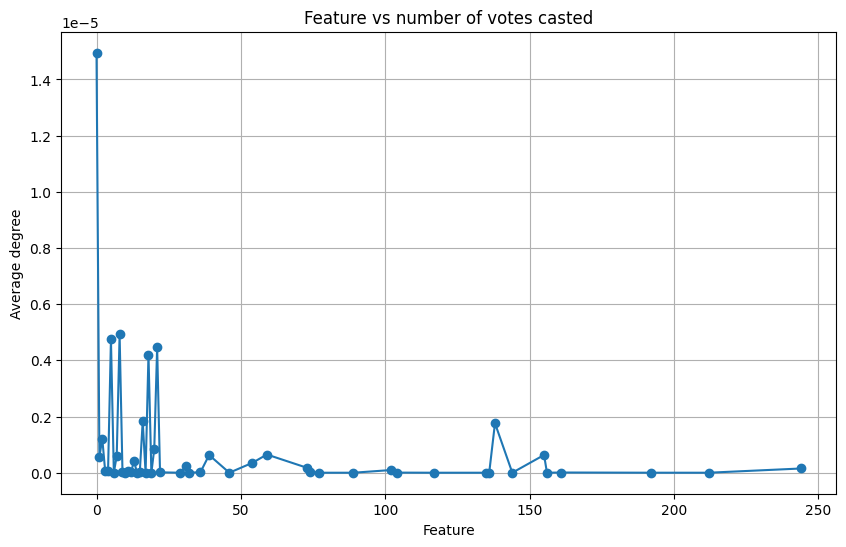

In [ ]:
# degrees = dict(G_aave.degree())
# degrees = G_aave_ec
feature_to_degrees = {}

mapping = votes_casted_mapping
# mapping = delegation_counts_mapping
# mapping = number_of_aWETH_transfers_mapping
# mapping = number_of_AAVE_transfers_mapping
# mapping = from_delegations_mapping
# mapping = to_delegations_mapping

for node, votes in mapping.items():
    degree = degrees.get(node, 0)
    if votes in feature_to_degrees:
        feature_to_degrees[votes].append(degree)
    else:
        feature_to_degrees[votes] = [degree]

votes = sorted(feature_to_degrees.keys())
average_degrees = [np.mean(feature_to_degrees[vote]) for vote in votes]

plt.figure(figsize=(10, 6))
plt.plot(votes, average_degrees, marker='o')
plt.xlabel('Feature')
plt.ylabel('Average degree')
plt.title('Feature vs number of votes casted')
plt.grid()
plt.show()

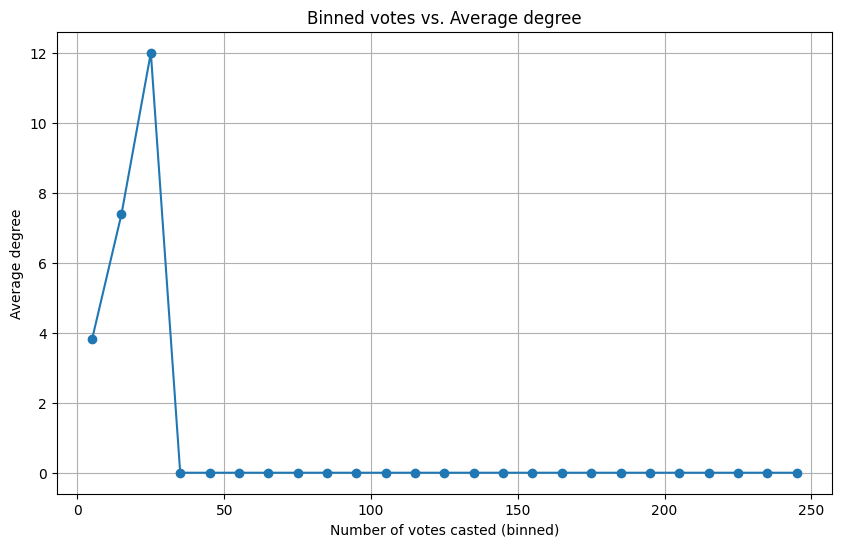

In [59]:
bin_edges = np.arange(0, 260, 10)  # From 0 to 250 in steps of 10
bin_labels = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints for plotting

# Bin votes and compute average degrees per bin
binned_degrees = {edge: [] for edge in bin_edges[:-1]}

for node, votes in mapping.items():
    degree = degrees.get(node, 0)
    bin_index = np.digitize(votes, bin_edges) - 1
    if bin_index < len(bin_edges) - 1:  # Ignore out-of-range values
        binned_degrees[bin_edges[bin_index]].append(degree)

# Compute average degrees per bin
average_degrees = [np.mean(binned_degrees[edge]) if binned_degrees[edge] else 0 for edge in bin_edges[:-1]]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(bin_labels, average_degrees, marker='o', linestyle='-')
plt.xlabel('Number of votes casted (binned)')
plt.ylabel('Average degree')
plt.title('Binned votes vs. Average degree')
plt.grid()
plt.show()

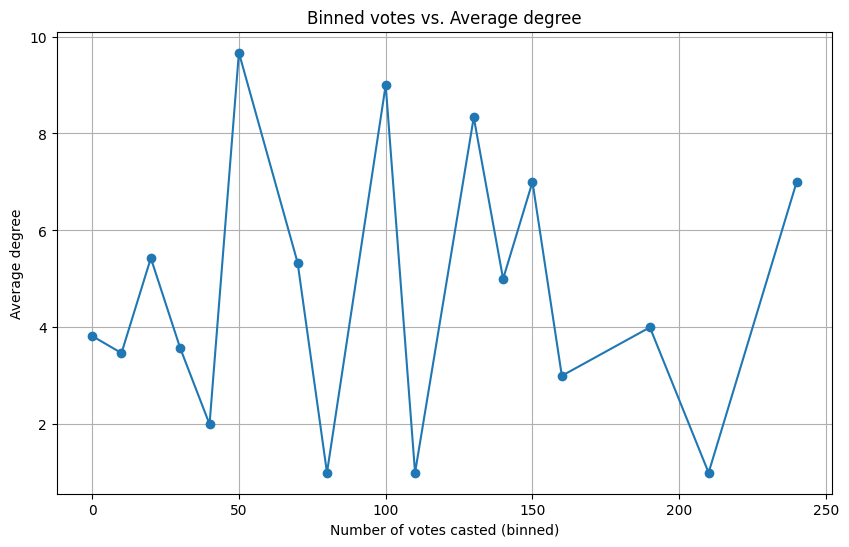

In [57]:
bin_edges = np.arange(0, 260, 10)
bin_labels = (bin_edges[:-1] + bin_edges[1:]) / 2

binned_degrees = {edge: [] for edge in bin_edges[:-1]}

for node, votes in mapping.items():
    degree = degrees.get(node, 0)
    bin_index = np.digitize(votes, bin_edges) - 1
    if bin_index < len(bin_edges) - 1:
        binned_degrees[bin_edges[bin_index]].append(degree)

valid_bins = [(edge, np.mean(deg_list)) for edge, deg_list in binned_degrees.items() if deg_list]

filtered_bin_labels, filtered_avg_degrees = zip(*valid_bins)

plt.figure(figsize=(10, 6))
plt.plot(filtered_bin_labels, filtered_avg_degrees, marker='o', linestyle='-')
plt.xlabel('Number of votes casted (binned)')
plt.ylabel('Average degree')
plt.title('Binned votes vs. Average degree')
plt.grid()
plt.show()

## aToken analysis

In [92]:
combined_tokens = {
    'USDC': ['aEthUSDC', 'aPolUSDC', 'aArbUSDC'],
    'USDT': ['aEthUSDT', 'aPolUSDT', 'aArbUSDT'],
    'WETH': ['aEthWETH', 'aPolWETH', 'aArbWETH']
}

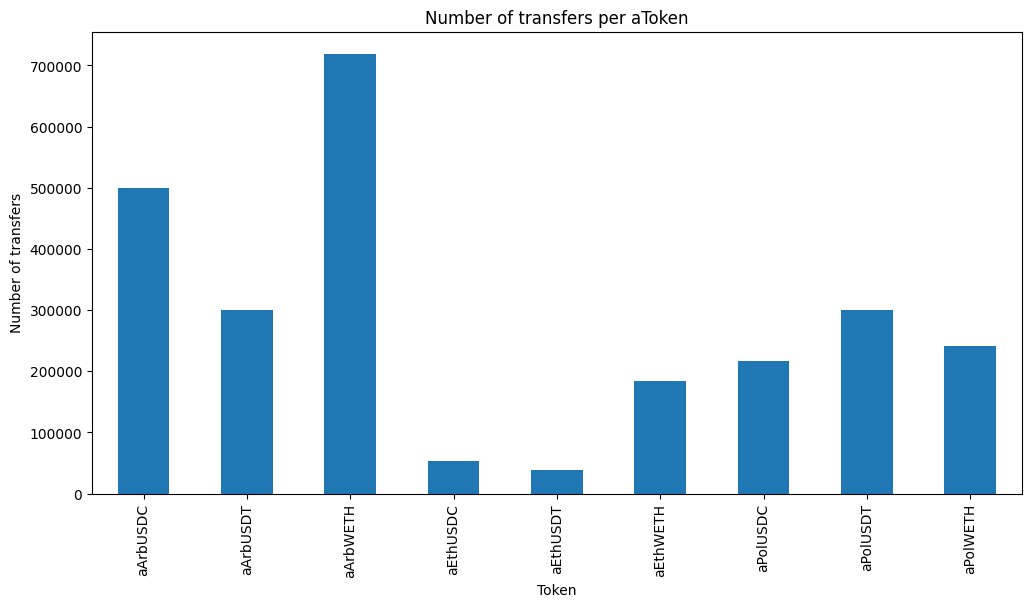

In [117]:
transfers_per_token = aToken_df.groupby('token').size()

# transfers_per_token = pd.Series({token: transfers_per_token.loc[names].sum() for token, names in combined_tokens.items()})

plt.figure(figsize=(12, 6))
transfers_per_token.plot(kind='bar')
plt.xlabel('Token')
plt.ylabel('Number of transfers')
plt.title('Number of transfers per aToken')
plt.show()

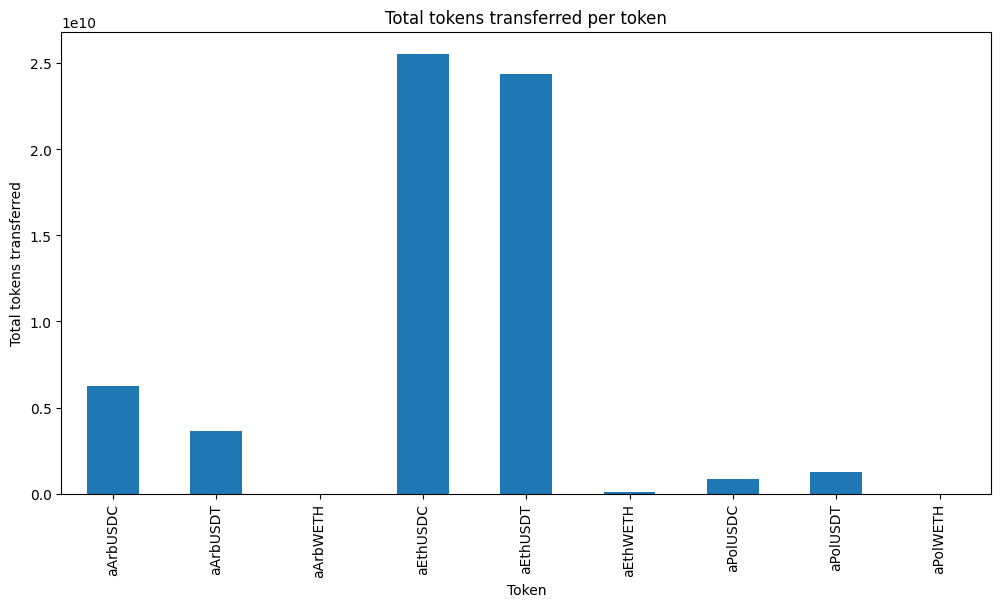

In [119]:
summed_weights_per_token = aToken_df.groupby('token')['value'].sum()

# summed_weights_per_token = pd.Series({token: summed_weights_per_token.loc[names].sum() for token, names in combined_tokens.items()})

plt.figure(figsize=(12, 6))
summed_weights_per_token.plot(kind='bar')
plt.xlabel('Token')
plt.ylabel('Total tokens transferred')
plt.title('Total tokens transferred per token')
plt.show()

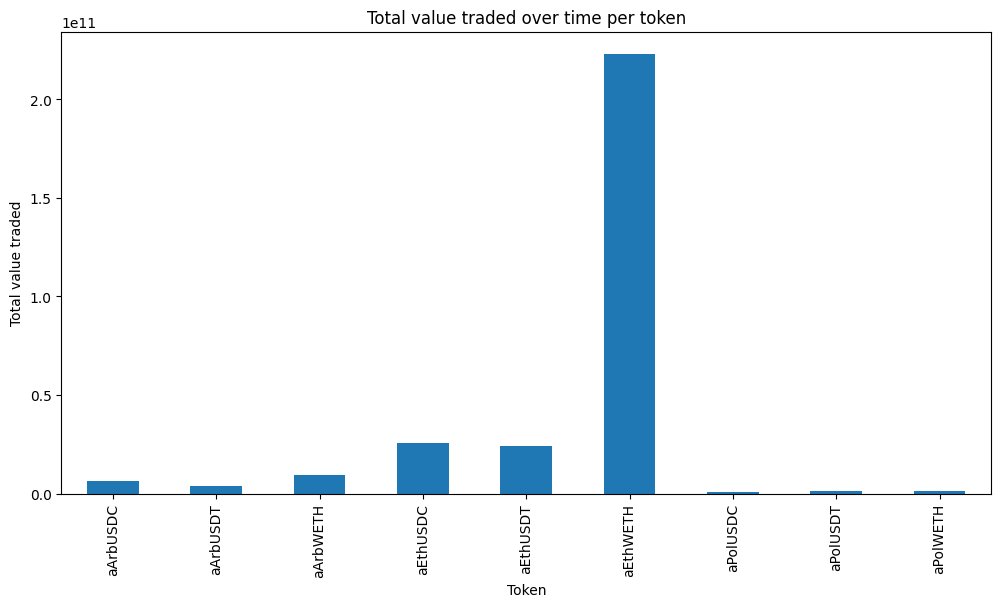

In [129]:
# price_data = pd.read_csv('data/weth-usd-max.csv', parse_dates=['snapped_at'])

# price_data['date'] = pd.to_datetime(price_data['snapped_at']).dt.date
# aToken_df['date'] = pd.to_datetime(aToken_df['timestamp'], unit='s')
# aToken_df['date'] = aToken_df['date'].dt.date

# aToken_df2 = aToken_df.merge(price_data[['date', 'price']], on='date', how='left')

tokens_to_multiply = ['aArbWETH', 'aEthWETH', 'aPolWETH']

aToken_df2['value_traded'] = aToken_df2.apply(
    lambda row: row['value'] * row['price'] if row['token'] in tokens_to_multiply else row['value'], axis=1
)

transfers_over_time_per_token = aToken_df2.groupby('token')['value_traded'].sum()

# transfers_over_time_per_token = pd.Series({token: transfers_over_time_per_token.loc[names].sum() for token, names in combined_tokens.items()})

plt.figure(figsize=(12, 6))
transfers_over_time_per_token.plot(kind='bar')
plt.xlabel('Token')
plt.ylabel('Total value traded')
plt.title('Total value traded over time per token')
plt.show()

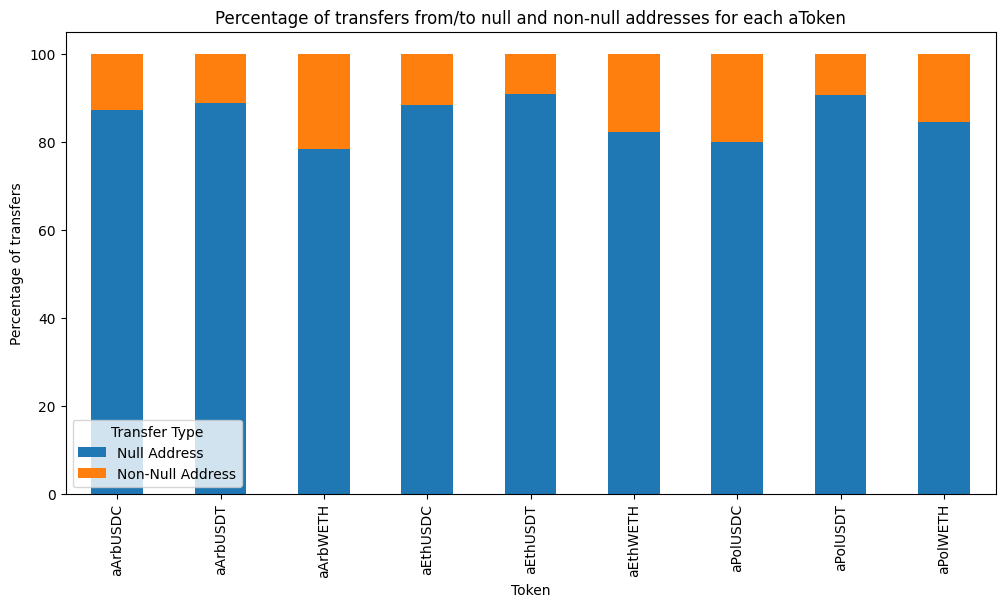

In [ ]:
null_address = '0x0000000000000000000000000000000000000000'

total_transfers_per_token = aToken_df['token'].value_counts()

null_address_transfers_per_token = aToken_df[(aToken_df['from'].str.lower() == null_address) | (aToken_df['to'].str.lower() == null_address)].groupby('token').size()

percentage_null_address_transfers = (null_address_transfers_per_token / total_transfers_per_token) * 100

percentage_non_null_address_transfers = 100 - percentage_null_address_transfers

percentage_transfers_df = pd.DataFrame({
    'Null Address': percentage_null_address_transfers,
    'Non-Null Address': percentage_non_null_address_transfers
}).fillna(0)

percentage_transfers_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Token')
plt.ylabel('Percentage of transfers')
plt.title('Percentage of transfers from/to null and non-null addresses for each aToken')
plt.legend(title='Transfer Type')
plt.show()

## Venn diagrams

<Axes: >

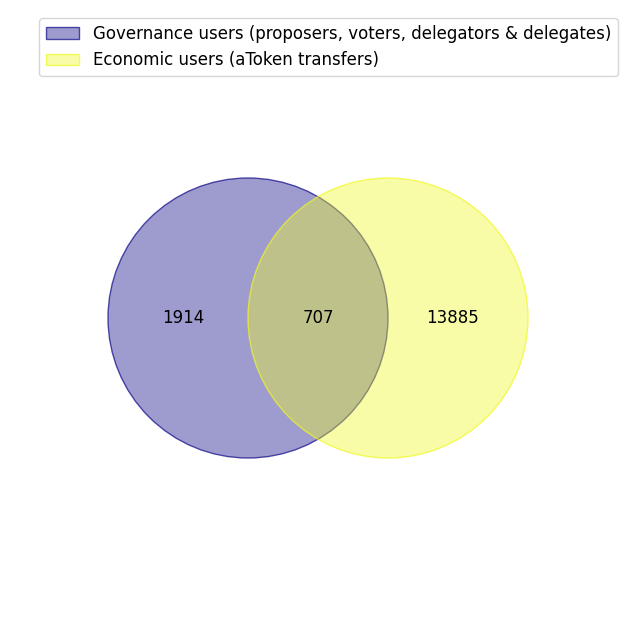

In [72]:
subsets = {
    'Governance users (proposers, voters, delegators & delegates)': governance_users,
    'Economic users (aToken transfers)': economic_users
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

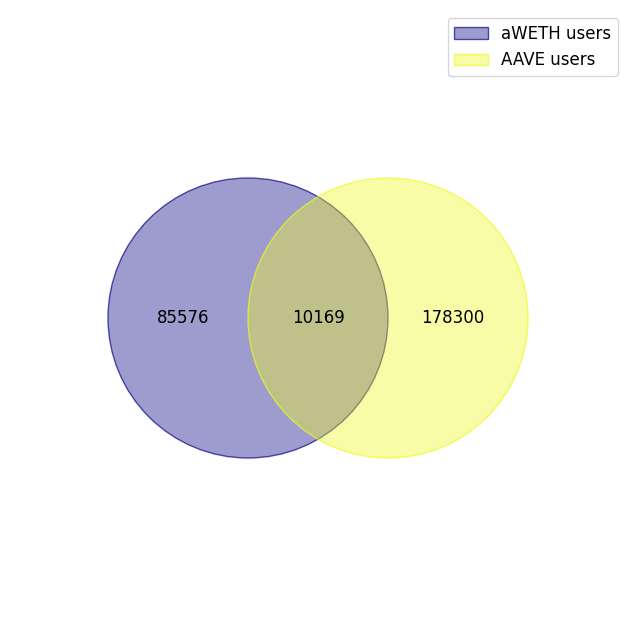

In [116]:
subsets = {
    # 'All governance users (proposers, voters, delegators & delegates)': all_governance_users,
    'aWETH users': set(G_aWETH.nodes()),
    'AAVE users': set(G_aave_nodes)
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

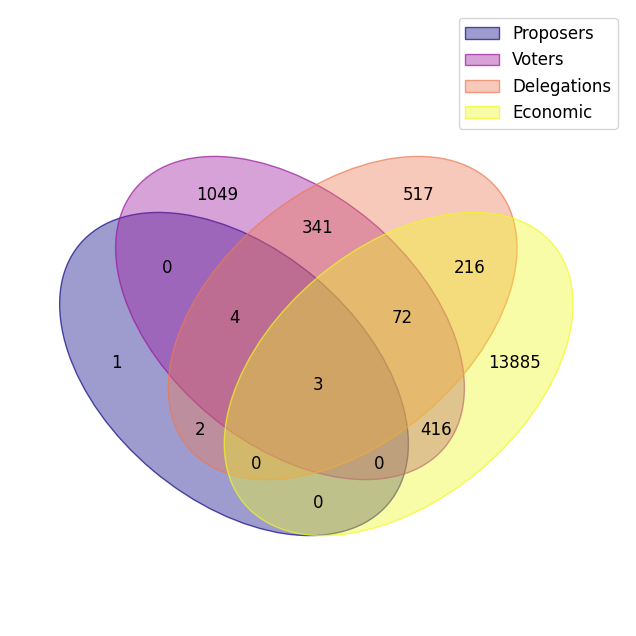

In [74]:
subsets = {
    'Proposers': proposers,
    'Voters': voters,
    'Delegations': all_delegations,
    'Economic': economic_users
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

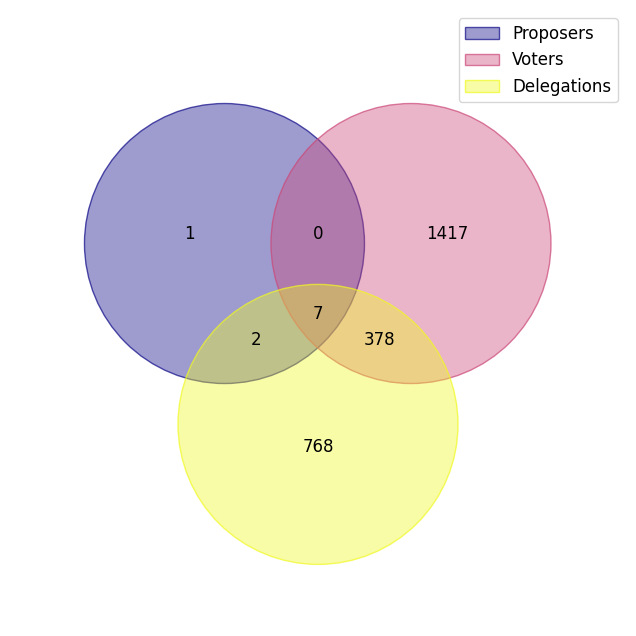

In [117]:
subsets = {
    "Proposers": proposers,
    "Voters": voters,
    "Delegations": all_delegations
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

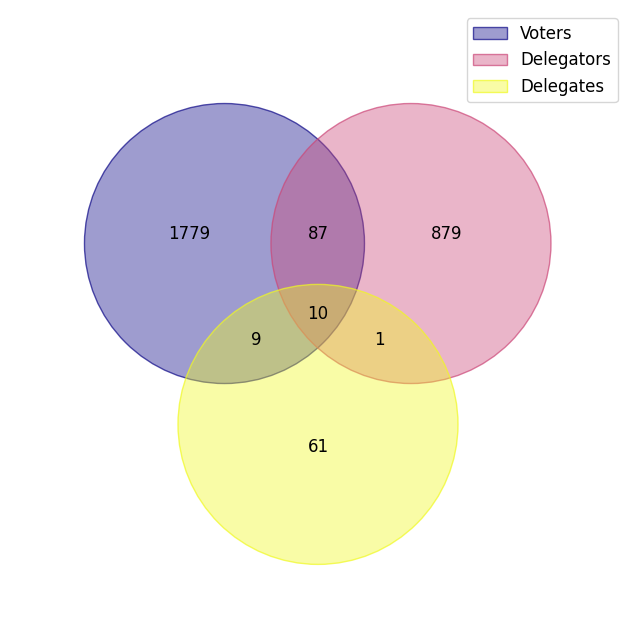

In [27]:
subsets = {
    # "Proposers": proposers,
    "Voters": voters,
    # "Delegators": delegators,
    # "Delegates": delegates
    "Delegators": from_delegations_without_same_to,
    "Delegates": to_delegations_without_same_from
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

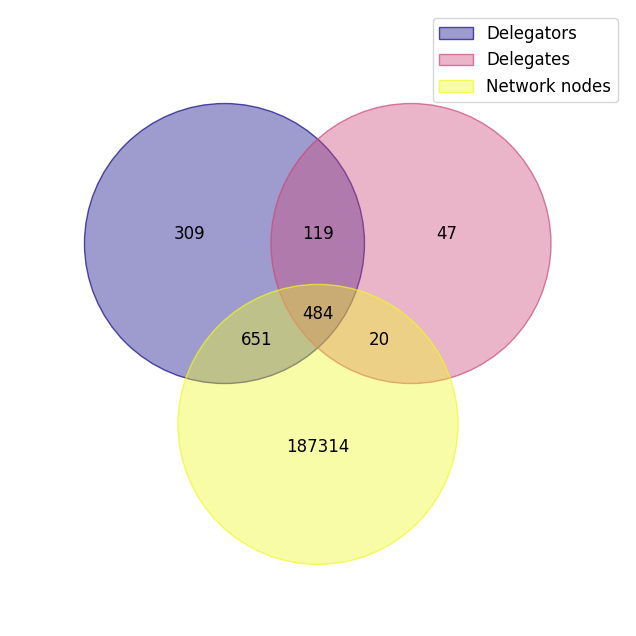

In [118]:
subsets = {
    # "Proposers": v2_proposers | v3_proposers,
    # "Voters": v2_voters | v3_voters,
    # "Delegations": delegators | delegates,
    "Delegators": delegators,
    "Delegates": delegates,
    "Network nodes": set(G_aave_nodes)
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

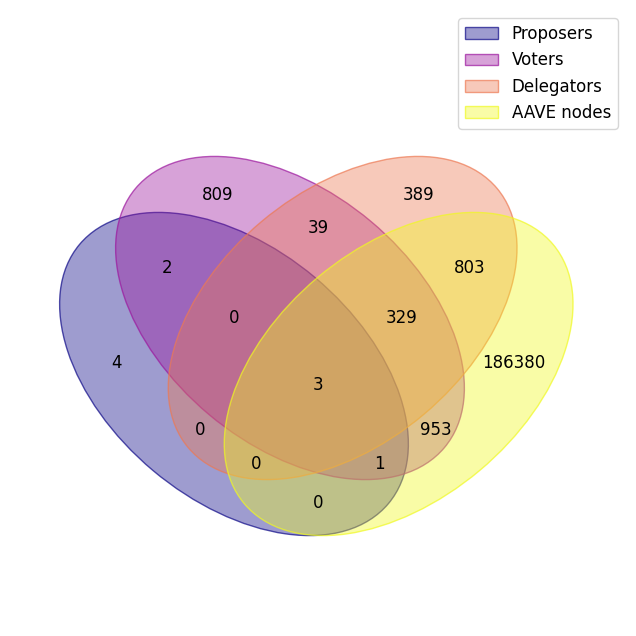

In [76]:
subsets = {
    "Proposers": v2_proposers | v3_proposers,
    "Voters": v2_voters | v3_voters,
    "Delegators": delegators,
    "AAVE nodes": set(G_aave_nodes)
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

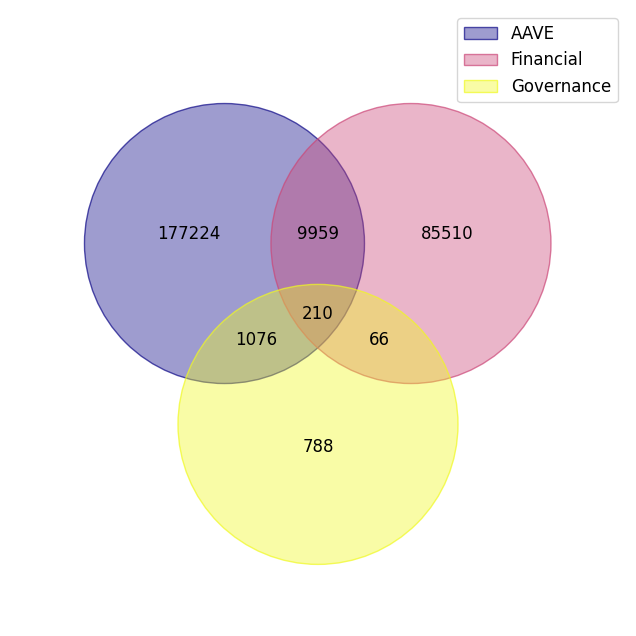

In [34]:
subsets = {
    "AAVE": AAVE_users,
    "Financial": aWETH_users,
    "Governance": v2_proposers | v3_proposers| v2_voters | v3_voters
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

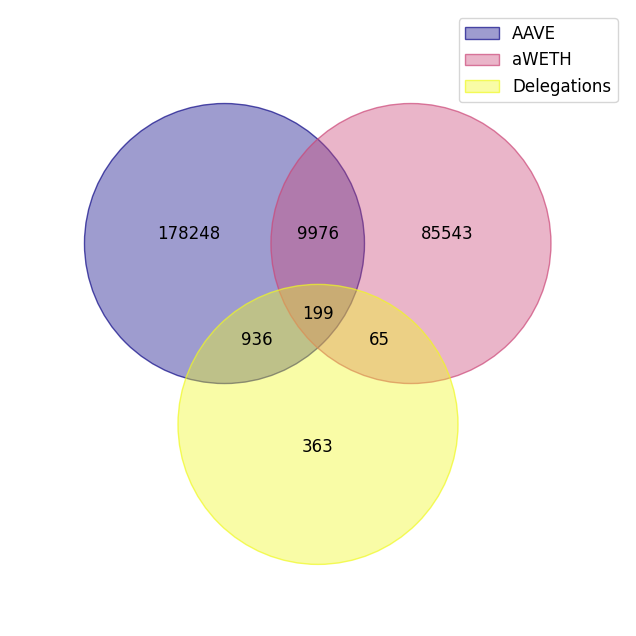

In [135]:
subsets = {
    "AAVE": set(G_aave_nodes),
    "aWETH": set(G_aWETH_nodes),
    "Delegations": delegators
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

## Community detection

### VI, NMI, AMI & ARI

In [140]:
def entropy(labels):
    total = len(labels)
    counts = Counter(labels)
    
    return -sum((count/total) * log2(count/total) for count in counts.values())

def mutual_information(x, y):
    total = len(x)
    counter_x = Counter(x)
    counter_y = Counter(y)
    joint_counter = Counter(zip(x, y))
    mi = 0.0
    
    for (x_val, y_val), joint_count in joint_counter.items():
        px = counter_x[x_val] / total
        py = counter_y[y_val] / total
        pxy = joint_count / total
        mi += pxy * log2(pxy / (px * py))
    
    return mi

def variation_of_information(x, y):
    return entropy(x) + entropy(y) - 2 * mutual_information(x, y)

def run_leiden_iterations(graph, n_iterations=10, resolution=1.0):
    memberships = []
    
    for i in range(n_iterations):
        partition = la.find_partition(
            graph,
            la.ModularityVertexPartition,
            weights='weight',
            # resolution_parameter=resolution,
            # seed=i  # use different seeds for variation
        )
        print(i, partition.modularity)
        
        memberships.append(partition.membership)
    
    return memberships

def compute_vi_nmi_ami_ari(memberships):
    n = len(memberships)
    vi_scores = np.zeros((n, n))
    nmi_scores = np.zeros((n, n))
    ami_scores = np.zeros((n, n))
    ari_scores = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            vi = variation_of_information(memberships[i], memberships[j])
            nmi = normalized_mutual_info_score(memberships[i], memberships[j])
            # ami = adjusted_mutual_info_score(memberships[i], memberships[j])
            # ari = adjusted_rand_score(memberships[i], memberships[j])
            
            vi_scores[i, j] = vi_scores[j, i] = vi
            nmi_scores[i, j] = nmi_scores[j, i] = nmi
            # ami_scores[i, j] = ami_scores[j, i] = ami
            # ari_scores[i, j] = ari_scores[j, i] = ari
    return vi_scores, nmi_scores, ami_scores, ari_scores

In [ ]:
G_aave_count_igraph = ig.Graph.from_networkx(G_aave_count, vertex_attr_hashable='name')
G_aave_count_igraph_components = G_aave_count_igraph.connected_components(mode="weak")
G_aave_count_igraph_largest_wcc = G_aave_count_igraph_components.giant()

In [133]:
n_iterations = 100
resolution = 1.0
memberships = run_leiden_iterations(G_aave_count_igraph_largest_wcc, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_vi = np.mean(vi_scores[np.triu_indices(n_iterations, k=1)])
avg_nmi = np.mean(nmi_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average VI: {avg_vi:.4f}")
print(f"Average NMI: {avg_nmi:.4f}")

0 0.6276448659661906
1 0.6282160944794647
2 0.6296742159163818
3 0.6281992971150432
4 0.629190726944997
5 0.6279887156343619
6 0.6285280153237245
7 0.628280287870666
8 0.6279633342715727
9 0.6297514591215428
10 0.6295925242724987
11 0.6286596613387332
12 0.6293133674393524
13 0.6272244185023829
14 0.6266584634831661
15 0.6294462878270181
16 0.6293398110020347
17 0.6291730538579487
18 0.627926219490079
19 0.6275460197658043
20 0.6295920247968634
21 0.6280122640436451
22 0.6287563444091949
23 0.6281628911030357
24 0.6276978464097163
25 0.6292455517383916
26 0.6295520322070285
27 0.6291083305955089
28 0.6293621322862484
29 0.6276065906325199
30 0.6278524793344814
31 0.6278578371759409
32 0.6292800026498304
33 0.6295300593827212
34 0.6284149186512287
35 0.6294219401215205
36 0.6282775542068341
37 0.6280138770067838
38 0.6285042293642904
39 0.6296949800502107
40 0.6293743823506842
41 0.6286981837977259
42 0.6281572902796624
43 0.6287883788303912
44 0.6294113104481391
45 0.6278251524065311
4

In [137]:
n_iterations = 10
resolution = 1.0
memberships = run_leiden_iterations(G_aave_count_igraph_largest_wcc, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_ami = np.mean(ami_scores[np.triu_indices(n_iterations, k=1)])
avg_ari = np.mean(ari_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average AMI: {avg_ami:.4f}")
print(f"Average ARI: {avg_ari:.4f}")

0 0.6279731894058079
1 0.6294044925997531
2 0.6293628303512648
3 0.6279829002285258
4 0.627918104086622
5 0.6293328588706121
6 0.6281922589422725
7 0.62827894228068
8 0.6294294276513783
9 0.6294755977857728
Average AMI: 0.9671
Average ARI: 0.9862


In [ ]:
G_aave_igraph = ig.Graph.from_networkx(G_aave, vertex_attr_hashable='name')
G_aave_igraph_components = G_aave_igraph.connected_components(mode="weak")
G_aave_igraph_largest_wcc = G_aave_igraph_components.giant()

In [141]:
n_iterations = 100
resolution = 1.0
memberships = run_leiden_iterations(G_aave_igraph_largest_wcc, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_vi = np.mean(vi_scores[np.triu_indices(n_iterations, k=1)])
avg_nmi = np.mean(nmi_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average VI: {avg_vi:.4f}")
print(f"Average NMI: {avg_nmi:.4f}")

0 0.6154107175097306
1 0.6155968213282014
2 0.6198875282377482
3 0.6192189816944675
4 0.6264120150949348
5 0.6190853107453489
6 0.6201592686470254
7 0.6152736896676169
8 0.6192606373898472
9 0.6200838380043902
10 0.6200374055230129
11 0.6157789091732885
12 0.6274525728250797
13 0.6158308580829198
14 0.6158782816422947
15 0.6193878236731569
16 0.6278561972210148
17 0.6155343096998163
18 0.620050158944051
19 0.6201239191327528
20 0.6155772553076266
21 0.6158726540100311
22 0.6207870101503258
23 0.6270874251436293
24 0.6156797925458737
25 0.6200795301314164
26 0.6200215931208863
27 0.6272369726103523
28 0.6165021536230317
29 0.6158982381135638
30 0.6158842072659934
31 0.6161399861581348
32 0.6175475245311889
33 0.6196391615863022
34 0.6197840825988157
35 0.6154146477678312
36 0.6245195341694316
37 0.6159767441518685
38 0.6154700903347681
39 0.6195771512308846
40 0.6181198030288543
41 0.6169537887256505
42 0.6270049309826472
43 0.6154897944954889
44 0.6157227243953387
45 0.6161724598443132

In [139]:
n_iterations = 10
resolution = 1.0
memberships = run_leiden_iterations(G_aave_igraph_largest_wcc, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_ami = np.mean(ami_scores[np.triu_indices(n_iterations, k=1)])
avg_ari = np.mean(ari_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average AMI: {avg_ami:.4f}")
print(f"Average ARI: {avg_ari:.4f}")

0 0.6158331585418031
1 0.6192093228830644
2 0.6160670174559959
3 0.627064825336436
4 0.6154834615850185
5 0.6196585041331837
6 0.6192868508541527
7 0.6162234078701438
8 0.6271680958228898
9 0.6199545808754543
Average AMI: 0.9144
Average ARI: 0.9208


In [14]:
G_aave_igraph = ig.Graph.from_networkx(G_aave, vertex_attr_hashable='name')

In [ ]:
n_iterations = 10
resolution = 1.0
memberships = run_leiden_iterations(G_aave_igraph, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_vi = np.mean(vi_scores[np.triu_indices(n_iterations, k=1)])
avg_nmi = np.mean(nmi_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average VI: {avg_vi:.4f}")
print(f"Average NMI: {avg_nmi:.4f}")

0 0.6297757563402778
1 0.6305325155109371
2 0.6373258716400528
3 0.6259892632914574
4 0.6263636896647938
5 0.6260254877663528
6 0.6303381170511517
7 0.6306034756039557
8 0.6305240038178792
9 0.6359667945432379
Average VI: 0.5398
Average NMI: 0.9404


In [16]:
n_iterations = 10
resolution = 1.0
memberships = run_leiden_iterations(G_aave_igraph, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

# avg_ami = np.mean(ami_scores[np.triu_indices(n_iterations, k=1)])
avg_ari = np.mean(ari_scores[np.triu_indices(n_iterations, k=1)])

# print(f"Average AMI: {avg_ami:.4f}")
print(f"Average ARI: {avg_ari:.4f}")

0 0.6262095361955315
1 0.6296324648460528
2 0.6260010590186813
3 0.6302850092230816
4 0.6259039137466463
5 0.626248972638168
6 0.6262335607688838
7 0.6379296747752116
8 0.6266389167273917
9 0.6302611975307595
Average ARI: 0.9287


In [10]:
G_aave_count_igraph = ig.Graph.from_networkx(G_aave_count, vertex_attr_hashable='name')

In [ ]:
n_iterations = 10
resolution = 1.0
memberships = run_leiden_iterations(G_aave_count_igraph, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_vi = np.mean(vi_scores[np.triu_indices(n_iterations, k=1)])
avg_nmi = np.mean(nmi_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average VI: {avg_vi:.4f}")
print(f"Average NMI: {avg_nmi:.4f}")

0 0.6384650005072265
1 0.6378624445871455
2 0.636238146732761
3 0.6386840745444863
4 0.639065566868283
5 0.6383410127987353
6 0.6381905999324861
7 0.6380363758298512
8 0.6371271505818852
9 0.6391699541569315
Average VI: 0.2057
Average NMI: 0.9725


In [12]:
n_iterations = 10
resolution = 1.0
memberships = run_leiden_iterations(G_aave_count_igraph, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

# avg_ami = np.mean(ami_scores[np.triu_indices(n_iterations, k=1)])
avg_ari = np.mean(ari_scores[np.triu_indices(n_iterations, k=1)])

# print(f"Average AMI: {avg_ami:.4f}")
print(f"Average ARI: {avg_ari:.4f}")

0 0.6383563939838464
1 0.6376123269719371
2 0.6367852227558033
3 0.6370807182320796
4 0.6383126351114047
5 0.6372054444681545
6 0.6388292959383233
7 0.6390910481581926
8 0.6371259229620697
9 0.6396325950066616
Average ARI: 0.9780


### Regular Leiden

#### Applied on G_aave_count

##### Basic analysis

In [119]:
G_aave_count_igraph = ig.Graph.from_networkx(G_aave_count, vertex_attr_hashable='name')
# G_aave_count_igraph = ig.Graph.from_networkx(G_aave, vertex_attr_hashable='name')

G_aave_count_igraph_components = G_aave_count_igraph.connected_components(mode="weak")
G_aave_count_igraph_largest_wcc = G_aave_count_igraph_components.giant()

partition = la.find_partition(G_aave_count_igraph_largest_wcc, la.ModularityVertexPartition, weights='weight')

print(len(partition), partition.modularity)

126 0.6286400127601354


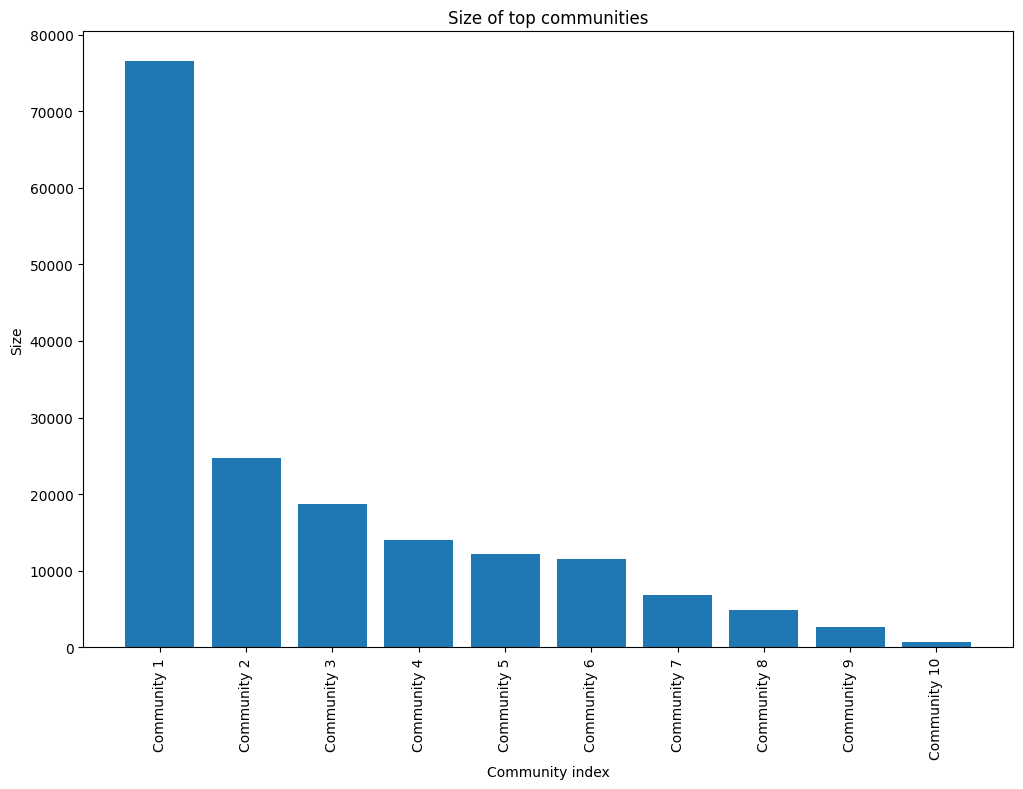

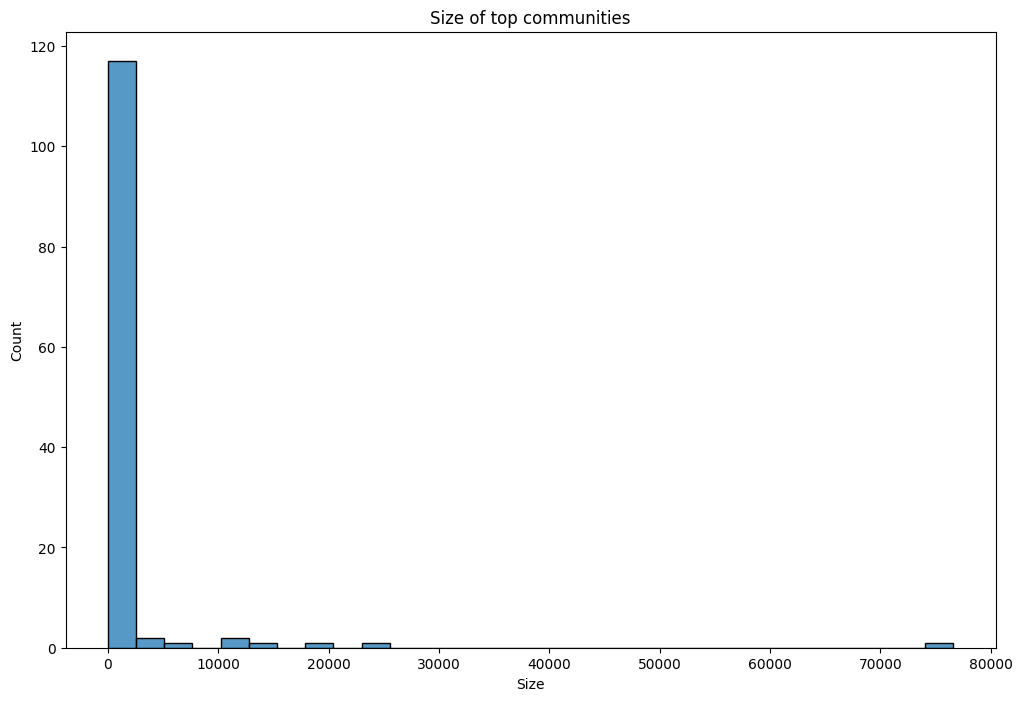

In [120]:
community_sizes = [len(c) for c in partition]

sorted_indices = sorted(range(len(community_sizes)), key=lambda i: community_sizes[i], reverse=True)

sorted_communities = [partition[i] for i in sorted_indices]

top_communities = sorted_communities[:10]

top_communities_sizes = [len(community) for community in top_communities]

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), top_communities_sizes)
plt.xlabel('Community index')
plt.ylabel('Size')
plt.title('Size of top communities')
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

all_communities_sizes = [len(community) for community in sorted_communities]
log_bins = np.logspace(np.log10(min(all_communities_sizes)), np.log10(max(all_communities_sizes)), 30)

plt.figure(figsize=(12, 8))
sns.histplot(all_communities_sizes, bins=30)
# plt.yscale('log')
# sns.histplot(all_communities_sizes, bins=log_bins)
# plt.xscale('log')
plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Size of top communities')
plt.show()

In [121]:
community_distribution = {
    'Economic': [],
    'Governance': [],
    'Both': [],
    'None': []
}

only_economic_users_in_G_wcc = only_economic_users_in_G_aave & set(G_aave_count_igraph_largest_wcc.vs["name"])
only_voters_in_G_wcc = only_voters_in_G_aave & set(G_aave_count_igraph_largest_wcc.vs["name"])
both_economic_and_governance_users_in_G_wcc = both_economic_and_governance_users & set(G_aave_count_igraph_largest_wcc.vs["name"])
all_economic_users_in_G_wcc = all_economic_users_in_G_aave & set(G_aave_count_igraph_largest_wcc.vs["name"])
all_voters_in_G_wcc = all_voters_in_G_aave & set(G_aave_count_igraph_largest_wcc.vs["name"])

communities_with_ids = [
    {G_aave_count_igraph_largest_wcc.vs[idx]["name"] for idx in community} for community in top_communities
]

total_economic_percentage = 0
total_governance_percentage = 0

economic_percentages = []
governance_percentages = []

id = 1
for community in communities_with_ids:
    economic_count = len(only_economic_users_in_G_wcc & community)
    governance_count = len(only_voters_in_G_wcc & community)
    both_count = len(both_economic_and_governance_users_in_G_wcc & community)
    none_count = len(community) - economic_count - governance_count - both_count
    
    # total_count = economic_count + voter_count + both_count + none_count
    
    # percentage = ((economic_count + voter_count + both_count) / total_count)*100
    
    economic_count_2 = len(all_economic_users_in_G_wcc & community)
    governance_count_2 = len(all_voters_in_G_wcc & community)
    
    economic_percentage = (economic_count_2 / len(all_economic_users_in_G_wcc)) * 100
    governance_percentage = (governance_count_2 / len(all_voters_in_G_wcc)) * 100
    
    economic_percentages.append(economic_percentage)
    governance_percentages.append(governance_percentage)
    
    total_economic_percentage += economic_percentage
    total_governance_percentage += governance_percentage
    
    print(f'Percentage of all the users in community {id}, economic: {economic_percentage:.0f}%, governance: {governance_percentage:.0f}%')
    
    id += 1
    
    community_distribution['Economic'].append(economic_count)
    community_distribution['Governance'].append(governance_count)
    community_distribution['Both'].append(both_count)
    community_distribution['None'].append(none_count)

print(f'{total_economic_percentage:.1f}%, {total_governance_percentage:.1f}%')

Percentage of all the users in community 1, economic: 17%, governance: 49%
Percentage of all the users in community 2, economic: 13%, governance: 39%
Percentage of all the users in community 3, economic: 13%, governance: 2%
Percentage of all the users in community 4, economic: 12%, governance: 2%
Percentage of all the users in community 5, economic: 11%, governance: 0%
Percentage of all the users in community 6, economic: 25%, governance: 4%
Percentage of all the users in community 7, economic: 4%, governance: 1%
Percentage of all the users in community 8, economic: 5%, governance: 2%
Percentage of all the users in community 9, economic: 0%, governance: 0%
Percentage of all the users in community 10, economic: 0%, governance: 0%
99.6%, 98.9%


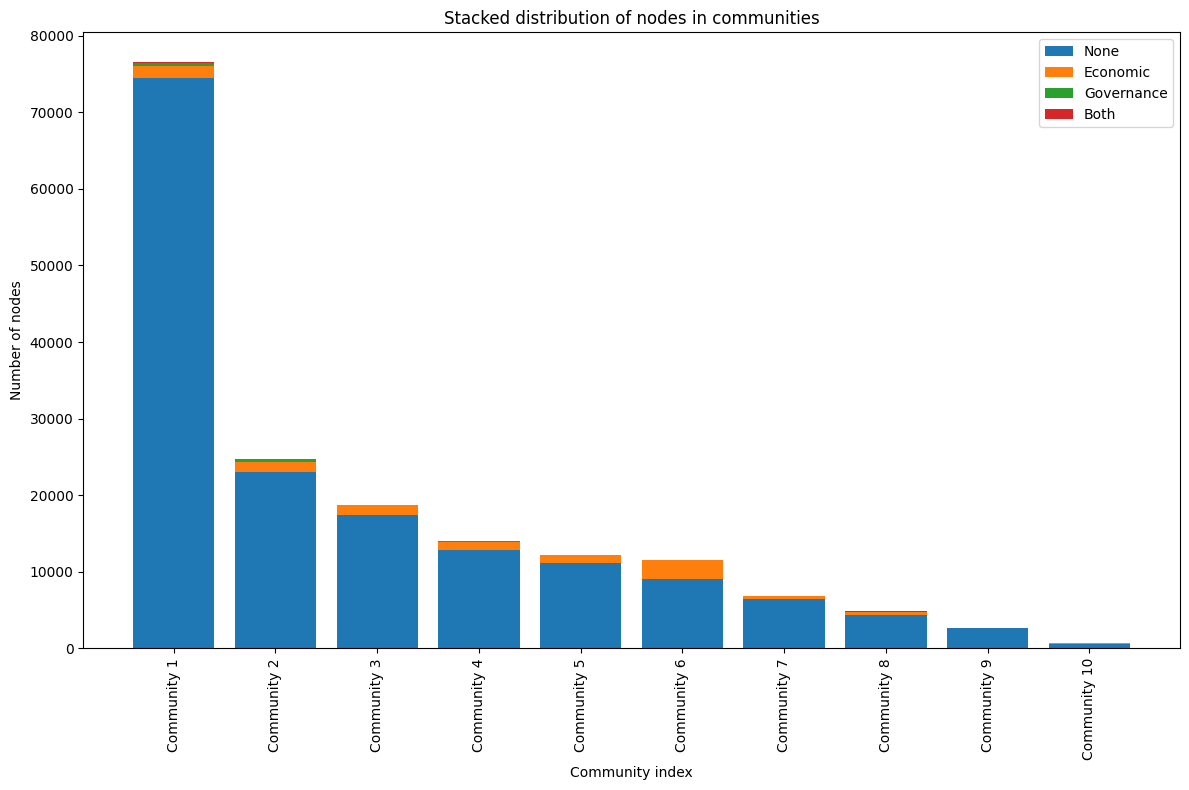

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

bar_width = 0.8
index = np.arange(len(communities_with_ids))

economic_array = np.array(community_distribution['Economic'])
governance_array = np.array(community_distribution['Governance'])
both_array = np.array(community_distribution['Both'])
none_array = np.array(community_distribution['None'])

bar1 = ax.bar(index, none_array, bar_width, label='None')
bar2 = ax.bar(index, economic_array, bar_width, bottom=none_array, label='Economic')
bar3 = ax.bar(index, governance_array, bar_width, bottom=none_array + economic_array, label='Governance')
bar4 = ax.bar(index, both_array, bar_width, bottom=none_array + economic_array + governance_array, label='Both')

ax.set_xlabel('Community index')
ax.set_ylabel('Number of nodes')
ax.set_title('Stacked distribution of nodes in communities')
ax.set_xticks(index)
ax.set_xticklabels([f'Community {i+1}' for i in range(len(communities_with_ids))], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

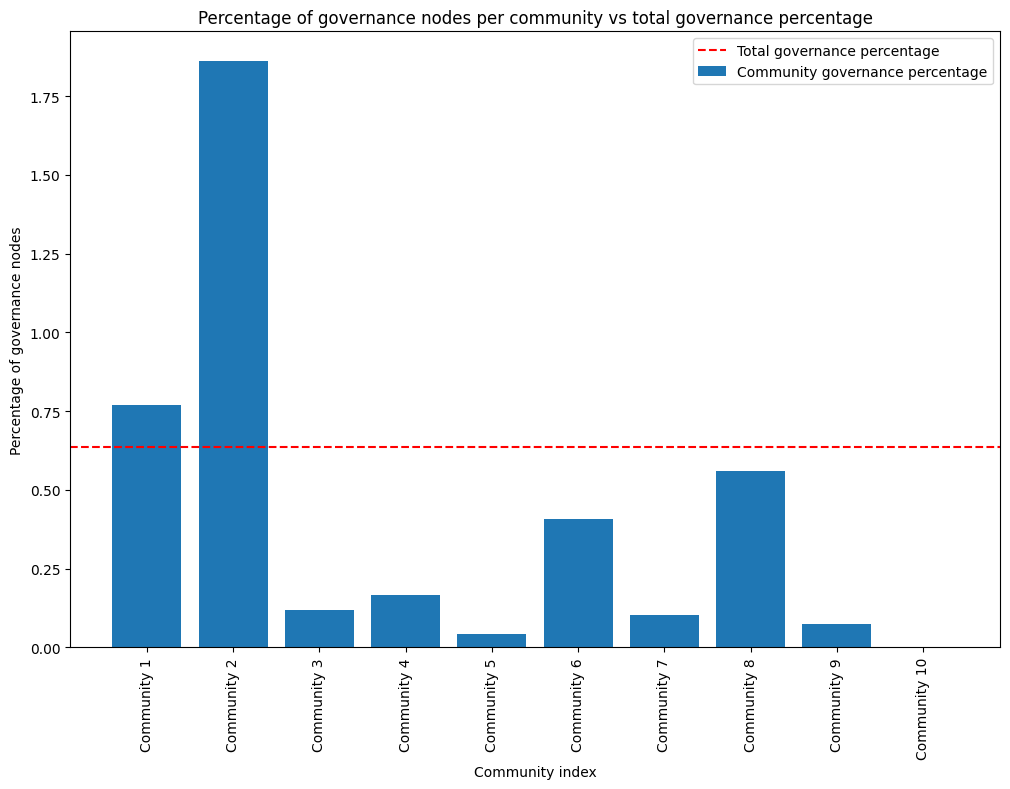

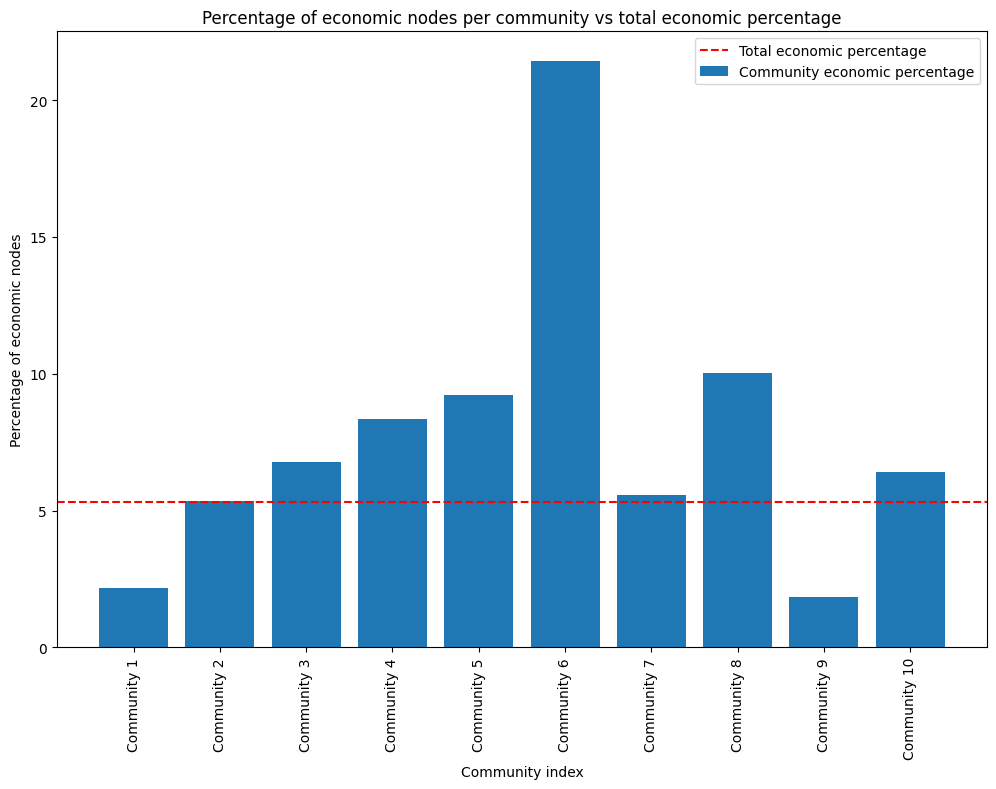

In [123]:
total_governance_percentage = (len(all_voters_in_G_aave) / len(G_aave_nodes)) * 100
total_economic_percentage = (len(all_economic_users_in_G_aave) / len(G_aave_nodes)) * 100

community_governance_percentages = []
community_economic_percentages = []
for community in communities_with_ids:
    governance_count = len(community & all_voters_in_G_aave)
    community_percentage = (governance_count / len(community)) * 100
    community_governance_percentages.append(community_percentage)
    
    economic_count = len(community & all_economic_users_in_G_aave)
    economic_percentage = (economic_count / len(community)) * 100
    community_economic_percentages.append(economic_percentage)

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), community_governance_percentages, label='Community governance percentage')
plt.axhline(y=total_governance_percentage, color='r', linestyle='--', label='Total governance percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of governance nodes')
plt.title('Percentage of governance nodes per community vs total governance percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), community_economic_percentages, label='Community economic percentage')
plt.axhline(y=total_economic_percentage, color='r', linestyle='--', label='Total economic percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of economic nodes')
plt.title('Percentage of economic nodes per community vs total economic percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

##### Feature averages per community

In [124]:
def plot_per_community(mapping):
    community_averages = {feature_name: [] for feature_name, _ in mapping}
    community_distributions = {feature_name: [] for feature_name, _ in mapping}

    for community in top_communities:
        community_node_ids = {G_aave_count_igraph_largest_wcc.vs[idx]["name"] for idx in community}

        for feature_name, feature_mapping in mapping:
            feature_values = [feature_mapping[node_id] for node_id in community_node_ids if node_id in feature_mapping]
            average_value = sum(feature_values) / len(feature_values) if feature_values else 0
            
            community_averages[feature_name].append(average_value)
            community_distributions[feature_name].append(feature_values)

    # for feature_name, averages in community_averages.items():
    #     plt.figure(figsize=(12, 8))
    #     plt.plot(range(len(top_communities)), averages, marker='o', label=feature_name)
    #     plt.xlabel('Community')
    #     plt.ylabel('Average feature value')
    #     plt.title(feature_name)
    #     # plt.legend()
    #     # plt.grid()
    #     plt.show()
    
    num_features = len(mapping)
    cols = 3
    rows = (num_features + cols - 1) // cols
    
    fig, axs = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axs = axs.flatten()
    
    for i, (feature_name, averages) in enumerate(community_averages.items()):
        axs[i].plot(range(len(top_communities)), averages, marker='o')
        axs[i].set_title(feature_name)
        # axs[i].grid(True)
    
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # fig, axs = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    # axs = axs.flatten()

    # for i, (feature_name, distributions) in enumerate(community_distributions.items()):
    #     axs[i].boxplot(distributions, tick_labels=[f'C{j}' for j in range(len(distributions))])
    #     axs[i].set_title(f'{feature_name} distribution per community')
    #     axs[i].set_xlabel('Community')
    #     axs[i].set_ylabel('Feature Value')
    #     # axs[i].grid(True)

    # for j in range(i + 1, len(axs)):
    #     axs[j].axis('off')

    plt.tight_layout()
    plt.show()

In [115]:
def plot_per_community_2(mapping):
    # Compute global stats for each feature
    feature_stats = {}
    for feature_name, feature_mapping in mapping:
        values = list(feature_mapping.values())
        mean = np.mean(values)
        std = np.std(values)
        feature_stats[feature_name] = (mean, std)

    # Initialize containers
    community_averages = {feature_name: [] for feature_name, _ in mapping}
    community_distributions = {feature_name: [] for feature_name, _ in mapping}

    for community in top_communities:
        community_node_ids = {G_aave_count_igraph_largest_wcc.vs[idx]["name"] for idx in community}

        for feature_name, feature_mapping in mapping:
            feature_values = [feature_mapping[node_id] for node_id in community_node_ids if node_id in feature_mapping]

            if feature_values:
                avg_val = sum(feature_values) / len(feature_values)
                mean, std = feature_stats[feature_name]
                z_score = (avg_val - mean) / std if std > 0 else 0
            else:
                z_score = 0

            community_averages[feature_name].append(z_score)
            community_distributions[feature_name].append(feature_values)

    # Plot normalized community averages
    num_features = len(mapping)
    cols = 3
    rows = (num_features + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axs = axs.flatten()

    for i, (feature_name, averages) in enumerate(community_averages.items()):
        axs[i].plot(range(len(top_communities)), averages, marker='o')
        axs[i].set_title(f'{feature_name} (z-score)')
        axs[i].set_xlabel('Community')
        axs[i].set_ylabel('Z-score')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

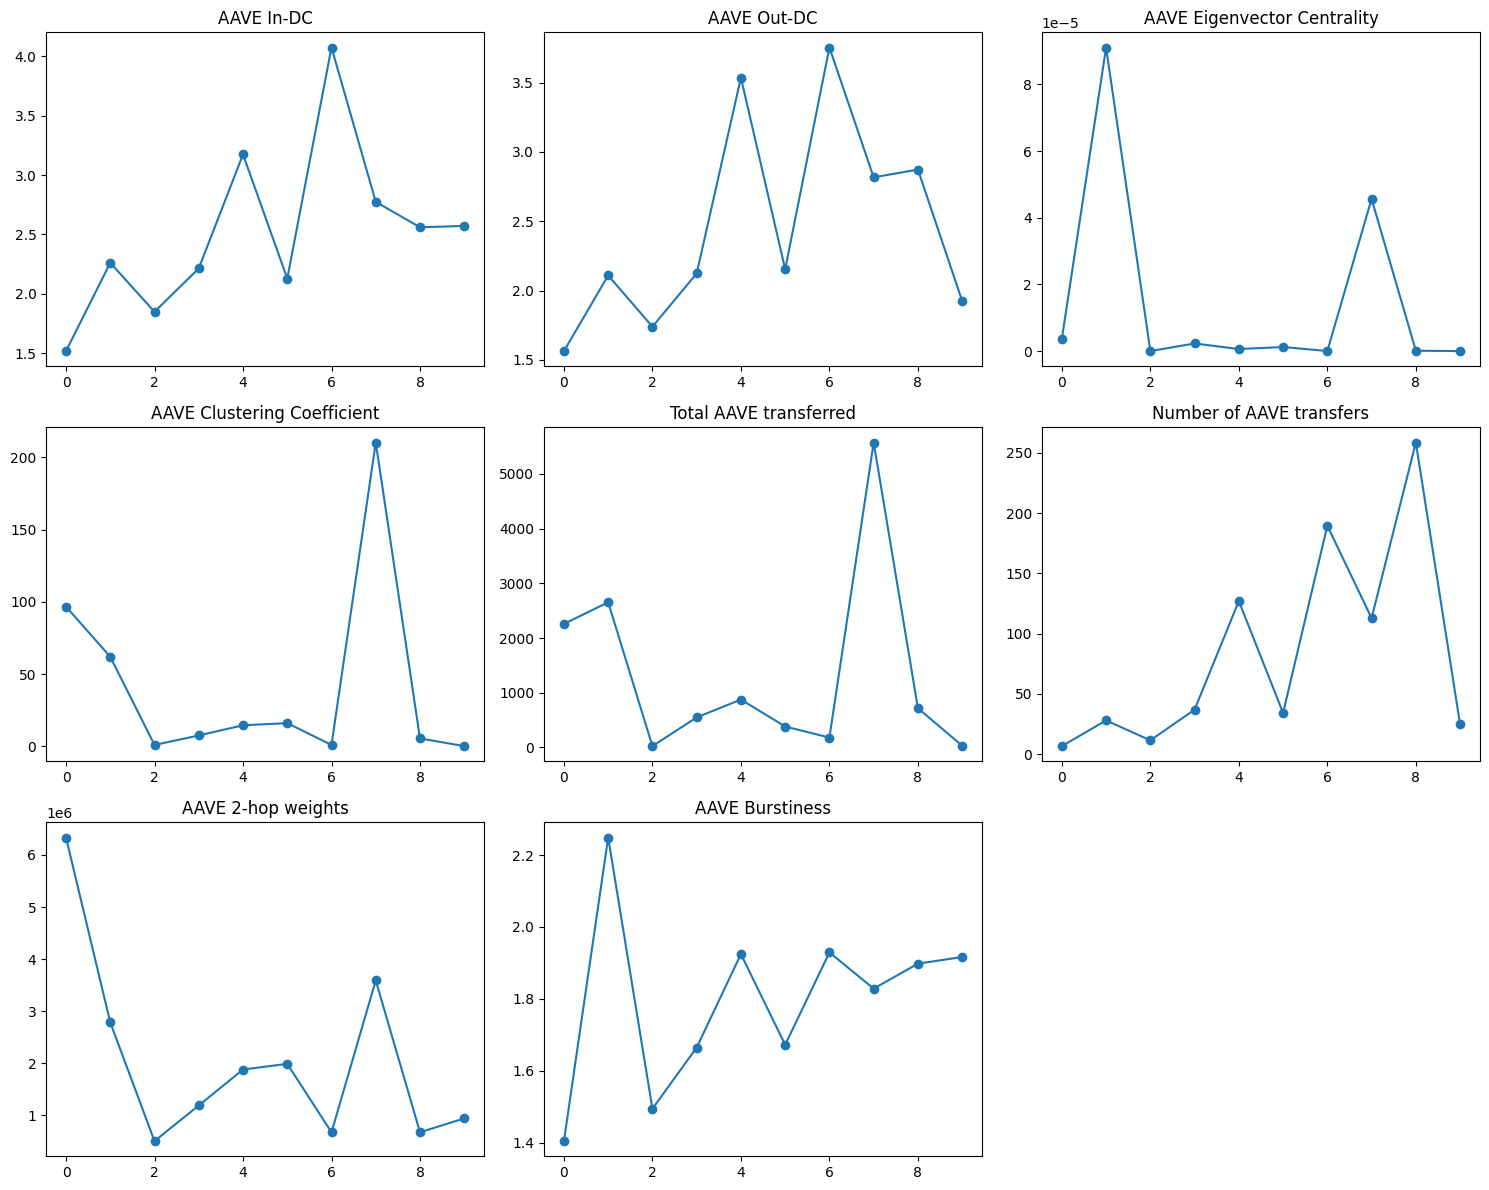

<Figure size 640x480 with 0 Axes>

In [125]:
plot_per_community(AAVE_mappings)

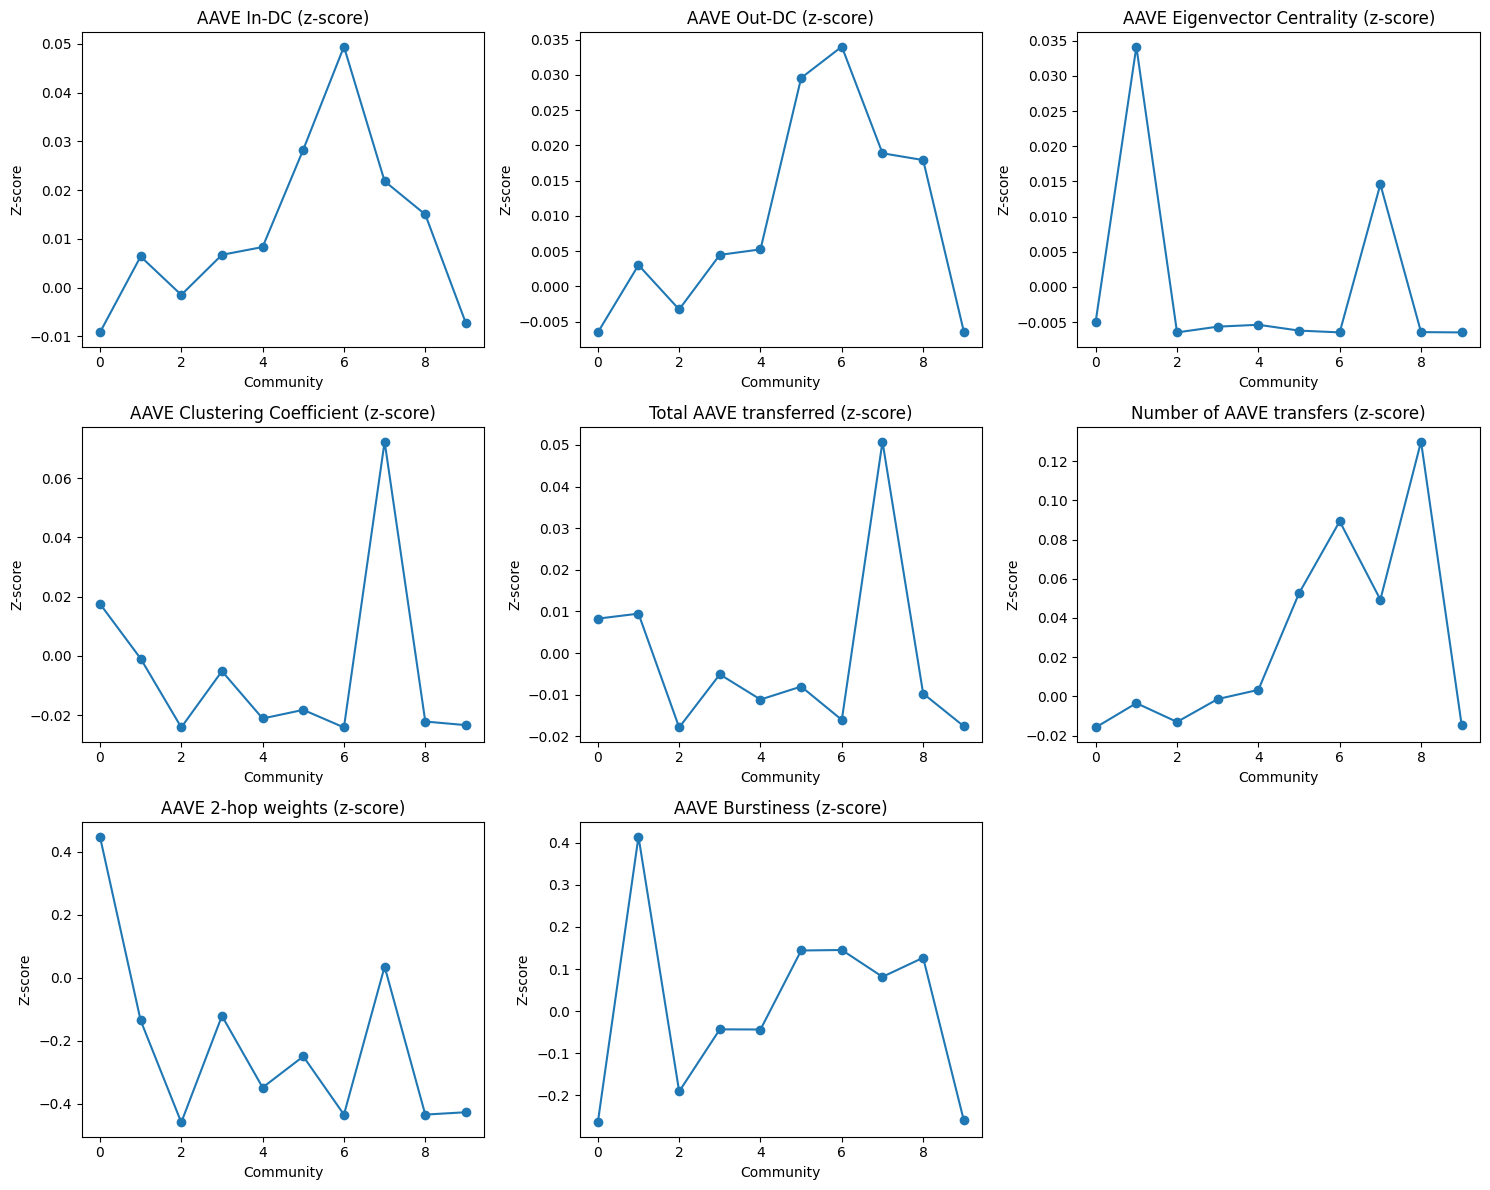

In [106]:
plot_per_community_2(AAVE_mappings)

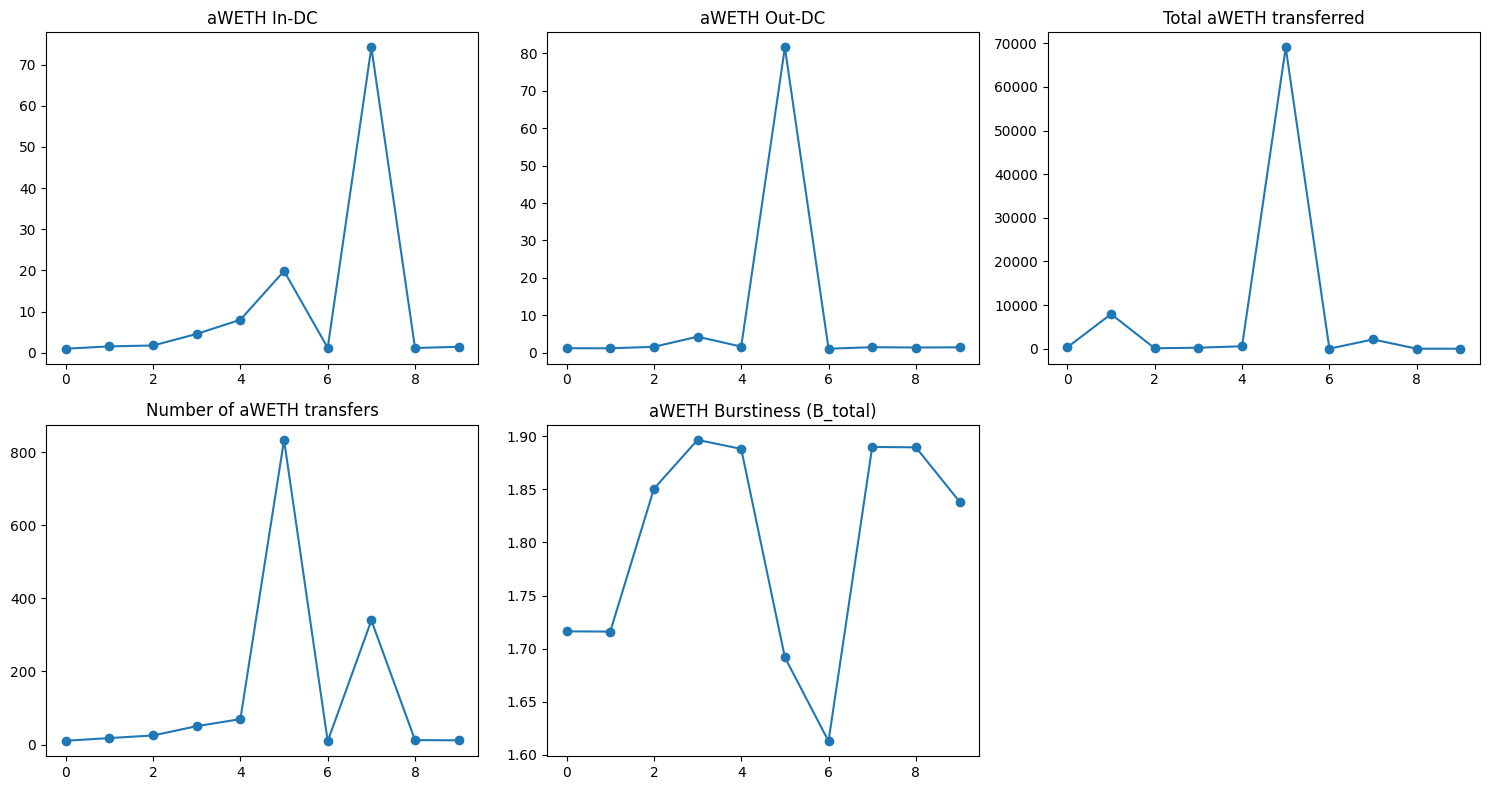

<Figure size 640x480 with 0 Axes>

In [117]:
plot_per_community(aWETH_mappings)

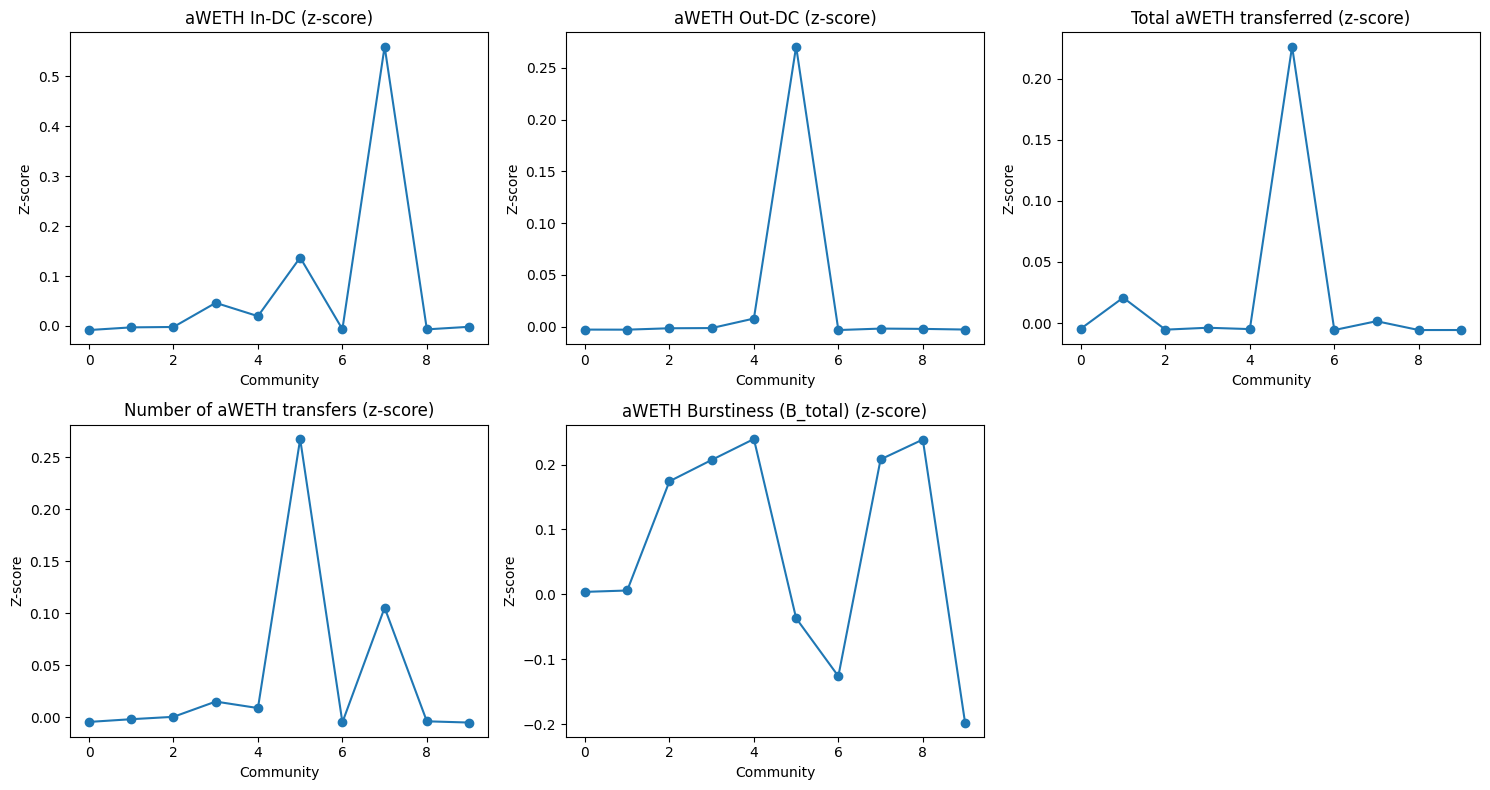

In [107]:
plot_per_community_2(aWETH_mappings)

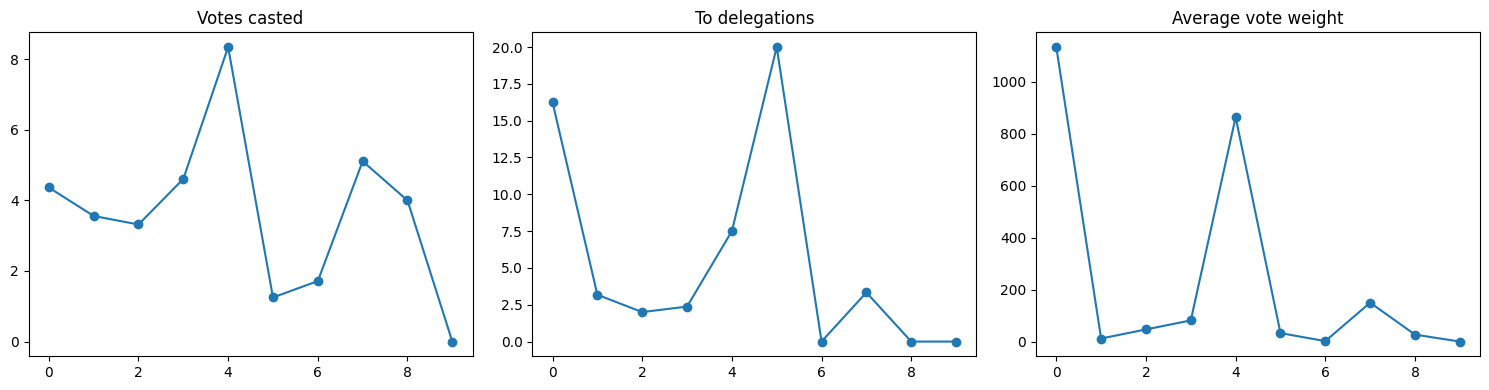

<Figure size 640x480 with 0 Axes>

In [118]:
plot_per_community(gov_mappings)

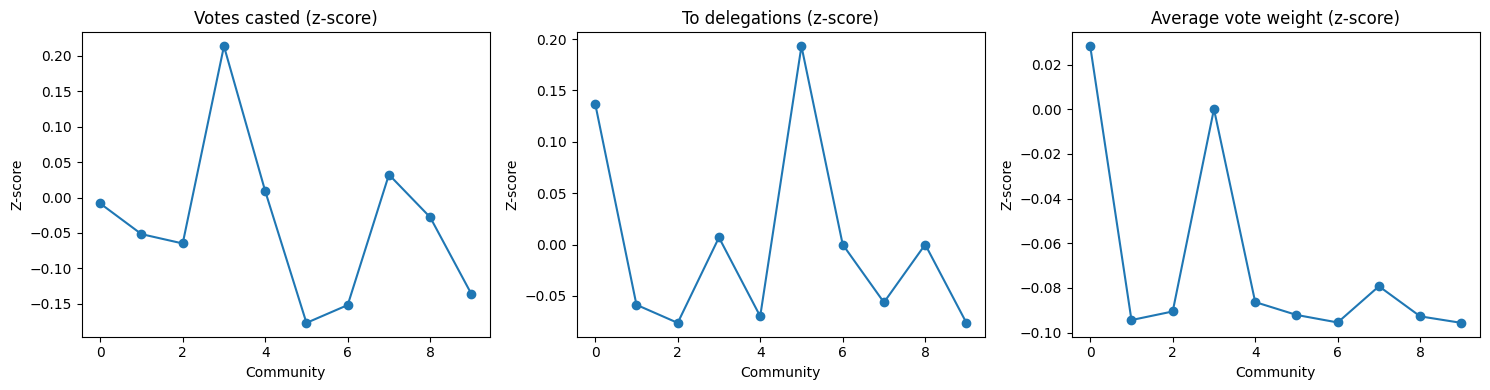

In [108]:
plot_per_community_2(gov_mappings)

##### SI influence comparison

In [144]:
with open('SI_1_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_1_extracted = pickle.load(f)
    
with open('SI_05_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_05_extracted = pickle.load(f)
    
with open('SI_01_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_01_extracted = pickle.load(f)
    
with open('SI_001_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_001_extracted = pickle.load(f)

In [ ]:
def plot_influence_multiple_runs(influence_data_list, beta_labels):
    num_runs = len(influence_data_list)
    num_communities = len(top_communities)

    community_scores = [defaultdict(list) for _ in range(num_runs)]

    for run_idx, influence_data in enumerate(influence_data_list):
        influence_scores = {entry['seed']: entry['avg_infected'] for entry in influence_data}
        for comm_id, community in enumerate(top_communities):
            for node_idx in community:
                node_id = G_aave_count_igraph_largest_wcc.vs[node_idx]['name']
                if node_id in influence_scores:
                    community_scores[run_idx][comm_id].append(influence_scores[node_id])

    # ---- Line Plot: Average Influence ----
    fig, axs = plt.subplots(1, num_runs, figsize=(6 * num_runs, 5))
    if num_runs == 1:
        axs = [axs]
    for i in range(num_runs):
        avg_infs = [
            np.mean(community_scores[i][cid]) if community_scores[i][cid] else 0
            for cid in range(num_communities)
        ]
        axs[i].plot(range(num_communities), avg_infs, marker='o', label=f"β={beta_labels[i]}")
        axs[i].set_title(f"Average influence per community (β={beta_labels[i]})")
        axs[i].set_xlabel("Community")
        axs[i].set_ylabel("Average infected nodes")
        axs[i].set_xticks(range(num_communities))
        axs[i].set_xticklabels([f"{cid}" for cid in range(num_communities)])
        # axs[i].grid(True)
        axs[i].legend()
    plt.tight_layout()
    plt.show()

    # ---- Box Plots ----
    fig, axs = plt.subplots(1, num_runs, figsize=(6 * num_runs, 5))
    if num_runs == 1:
        axs = [axs]

    for i in range(num_runs):
        data = [community_scores[i][cid] for cid in range(num_communities)]
        axs[i].boxplot(data, positions=range(num_communities))
        axs[i].set_title(f"Box plot (β={beta_labels[i]})")
        axs[i].set_xlabel("Community")
        axs[i].set_xticks(range(num_communities))
        axs[i].set_xticklabels([f"{cid}" for cid in range(num_communities)])
        axs[i].set_ylabel("Average infected nodes")

    plt.tight_layout()
    plt.show()

    # ---- Violin Plots ----
    fig, axs = plt.subplots(1, num_runs, figsize=(6 * num_runs, 5))
    if num_runs == 1:
        axs = [axs]

    for i in range(num_runs):
        data = [community_scores[i][cid] for cid in range(num_communities)]
        axs[i].violinplot(data, positions=range(num_communities), showmedians=True)
        axs[i].set_title(f"Violin plot (β={beta_labels[i]})")
        axs[i].set_xlabel("Community")
        axs[i].set_xticks(range(num_communities))
        axs[i].set_xticklabels([f"{cid}" for cid in range(num_communities)])
        axs[i].set_ylabel("Average infected nodes")

    plt.tight_layout()
    plt.show()

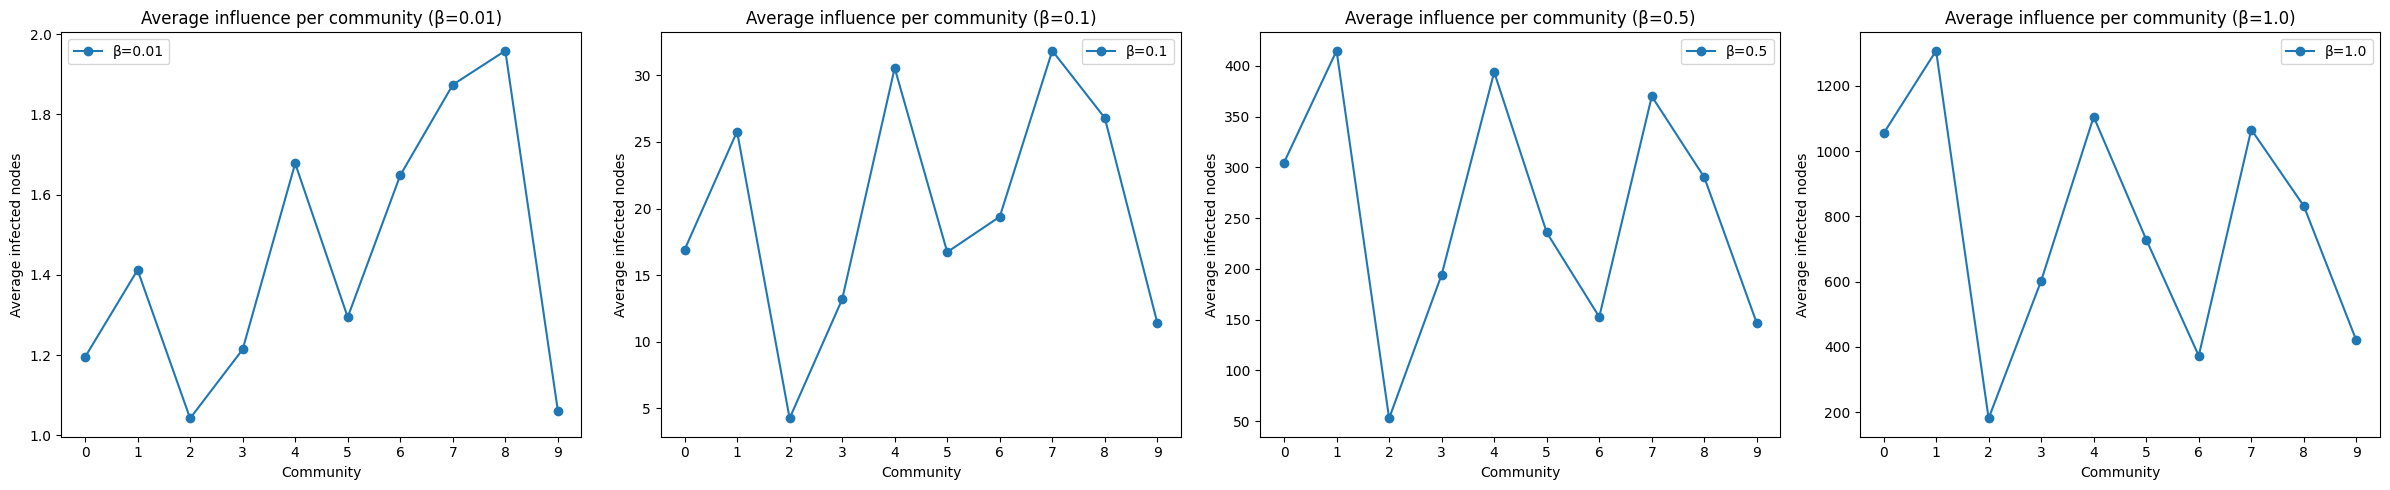

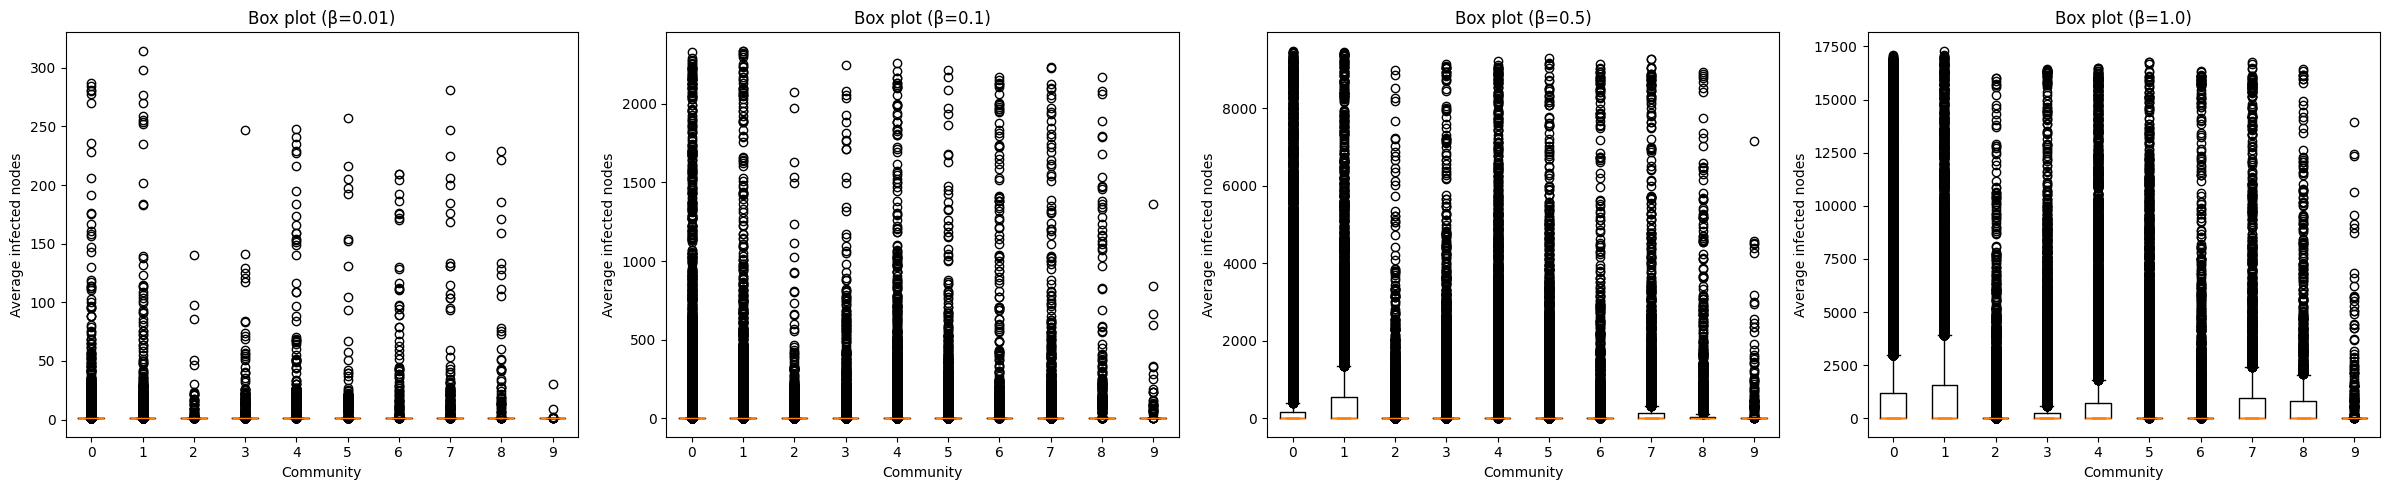

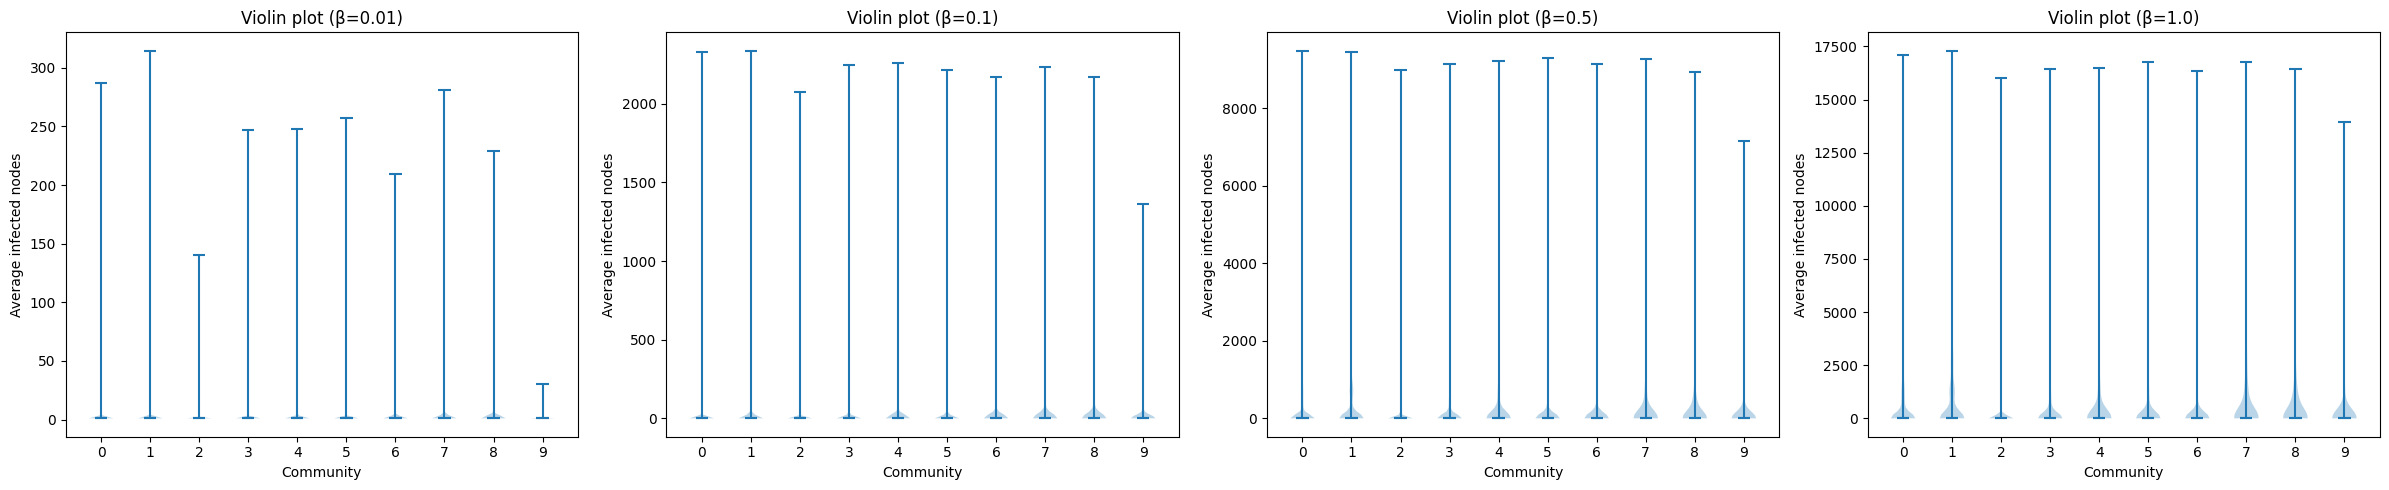

In [159]:
influence_dicts = [SI_001_extracted, SI_01_extracted, SI_05_extracted, SI_1_extracted]
labels = ['0.01', '0.1', '0.5', '1.0']

plot_influence_multiple_runs(influence_dicts, labels)

#### Applied on G_aave

In [ ]:
G_aave_igraph = ig.Graph.from_networkx(G_aave, vertex_attr_hashable='name')

partition = la.find_partition(G_aave_igraph, la.ModularityVertexPartition, weights='weight')

print(len(partition), partition.modularity)

7834 0.6295736003472944


In [16]:
community_sizes = [len(c) for c in partition]

sorted_indices = sorted(range(len(community_sizes)), key=lambda i: community_sizes[i], reverse=True)

sorted_communities = [partition[i] for i in sorted_indices]

top_communities = sorted_communities[:10]

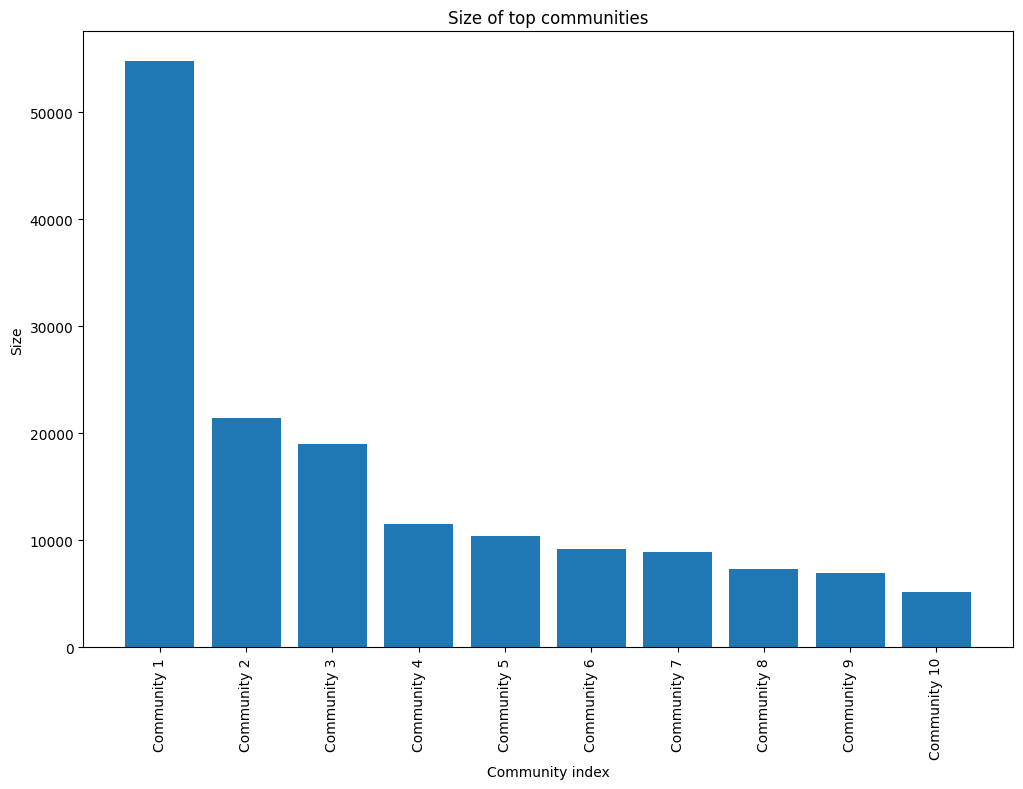

In [125]:
top_communities_sizes = [len(community) for community in top_communities]

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), top_communities_sizes)
plt.xlabel('Community index')
plt.ylabel('Size')
plt.title('Size of top communities')
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

In [ ]:
community_distribution = {
    'Economic': [],
    'Governance': [],
    'Both': [],
    'None': []
}

communities_with_ids = [
    {G_aave_igraph.vs[idx]["name"] for idx in community} for community in top_communities
]

total_economic_percentage = 0
total_governance_percentage = 0

economic_percentages = []
governance_percentages = []

id = 1
for community in communities_with_ids:
    economic_count = len(only_economic_users_in_G_aave & community)
    voter_count = len(only_voters_in_G_aave & community)
    both_count = len(both_economic_and_governance_users & community)
    none_count = len(community) - economic_count - voter_count - both_count
    
    # total_count = economic_count + voter_count + both_count + none_count
    
    # percentage = ((economic_count + voter_count + both_count) / total_count)*100
    
    economic_count_2 = len(all_economic_users_in_G_aave & community)
    governance_count_2 = len(all_voters_in_G_aave & community)
    
    economic_percentage = (economic_count_2 / len(all_economic_users_in_G_aave)) * 100
    governance_percentage = (governance_count_2 / len(all_voters_in_G_aave)) * 100
    
    economic_percentages.append(economic_percentage)
    governance_percentages.append(governance_percentage)
    
    total_economic_percentage += economic_percentage
    total_governance_percentage += governance_percentage
    
    print(f'Percentage of all the users in community {id}, economic: {economic_percentage:.0f}%, governance: {governance_percentage:.0f}%')
    
    id += 1
    
    community_distribution['Economic'].append(economic_count)
    community_distribution['Governance'].append(voter_count)
    community_distribution['Both'].append(both_count)
    community_distribution['None'].append(none_count)

print(f'{total_economic_percentage:.1f}%, {total_governance_percentage:.1f}%')

Percentage of all the users in community 1, economic: 53%, governance: 6%
Percentage of all the users in community 2, economic: 8%, governance: 31%
Percentage of all the users in community 3, economic: 1%, governance: 21%
Percentage of all the users in community 4, economic: 1%, governance: 1%
Percentage of all the users in community 5, economic: 7%, governance: 8%
Percentage of all the users in community 6, economic: 1%, governance: 1%
Percentage of all the users in community 7, economic: 10%, governance: 0%
Percentage of all the users in community 8, economic: 13%, governance: 15%
Percentage of all the users in community 9, economic: 1%, governance: 0%
Percentage of all the users in community 10, economic: 0%, governance: 0%
93.9%, 84.7%


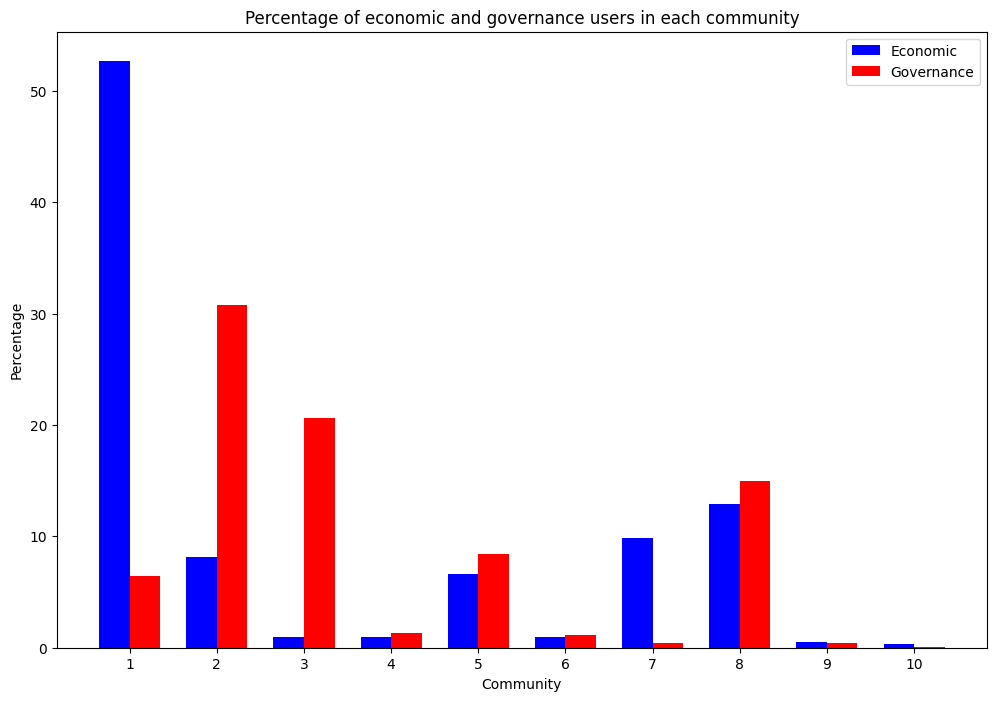

In [18]:
communities = list(range(1, 11))

bar_width = 0.35

r1 = np.arange(len(top_communities))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 8))
plt.bar(r1, economic_percentages, color='b', width=bar_width, label='Economic')
plt.bar(r2, governance_percentages, color='r', width=bar_width, label='Governance')
plt.xlabel('Community')
plt.ylabel('Percentage')
plt.xticks([r + bar_width/2 for r in range(len(communities))], communities)
plt.title('Percentage of economic and governance users in each community')
plt.legend()
plt.show()

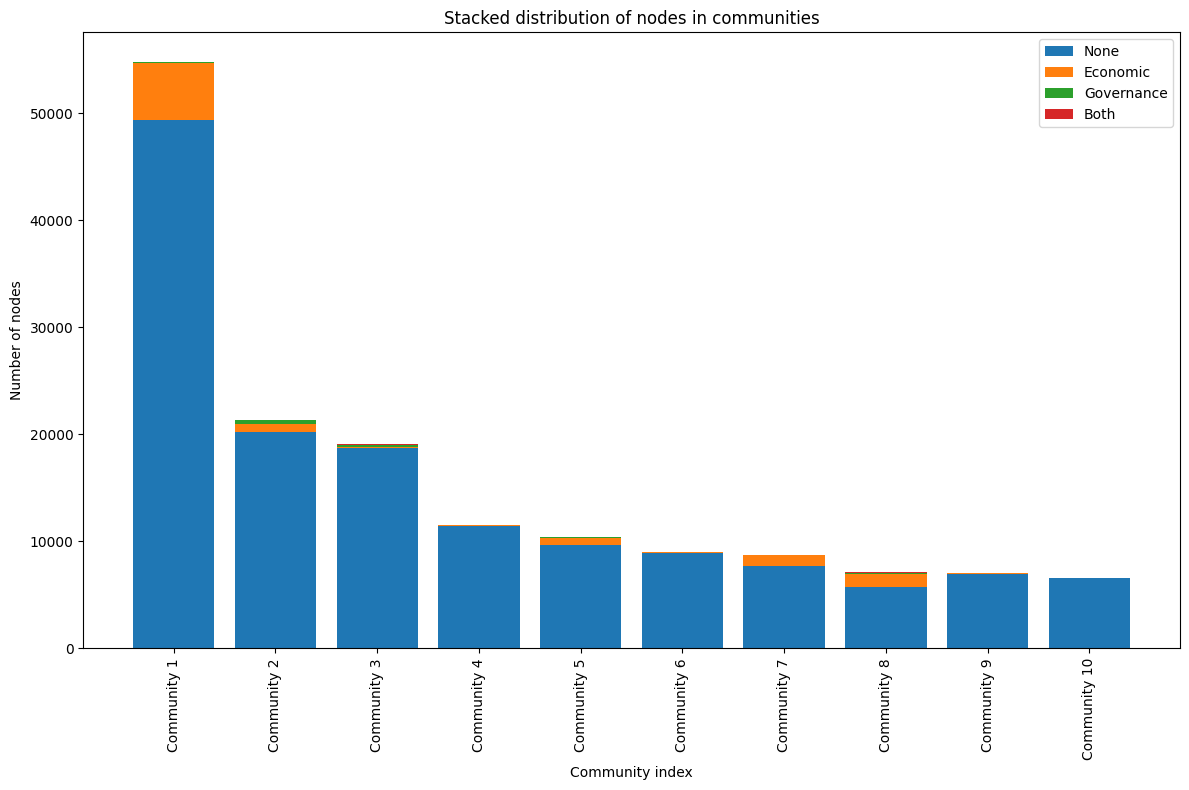

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

bar_width = 0.8
index = np.arange(len(communities_with_ids))

economic_array = np.array(community_distribution['Economic'])
governance_array = np.array(community_distribution['Governance'])
both_array = np.array(community_distribution['Both'])
none_array = np.array(community_distribution['None'])

bar1 = ax.bar(index, none_array, bar_width, label='None')
bar2 = ax.bar(index, economic_array, bar_width, bottom=none_array, label='Economic')
bar3 = ax.bar(index, governance_array, bar_width, bottom=none_array + economic_array, label='Governance')
bar4 = ax.bar(index, both_array, bar_width, bottom=none_array + economic_array + governance_array, label='Both')

ax.set_xlabel('Community index')
ax.set_ylabel('Number of nodes')
ax.set_title('Stacked distribution of nodes in communities')
ax.set_xticks(index)
ax.set_xticklabels([f'Community {i+1}' for i in range(len(communities_with_ids))], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

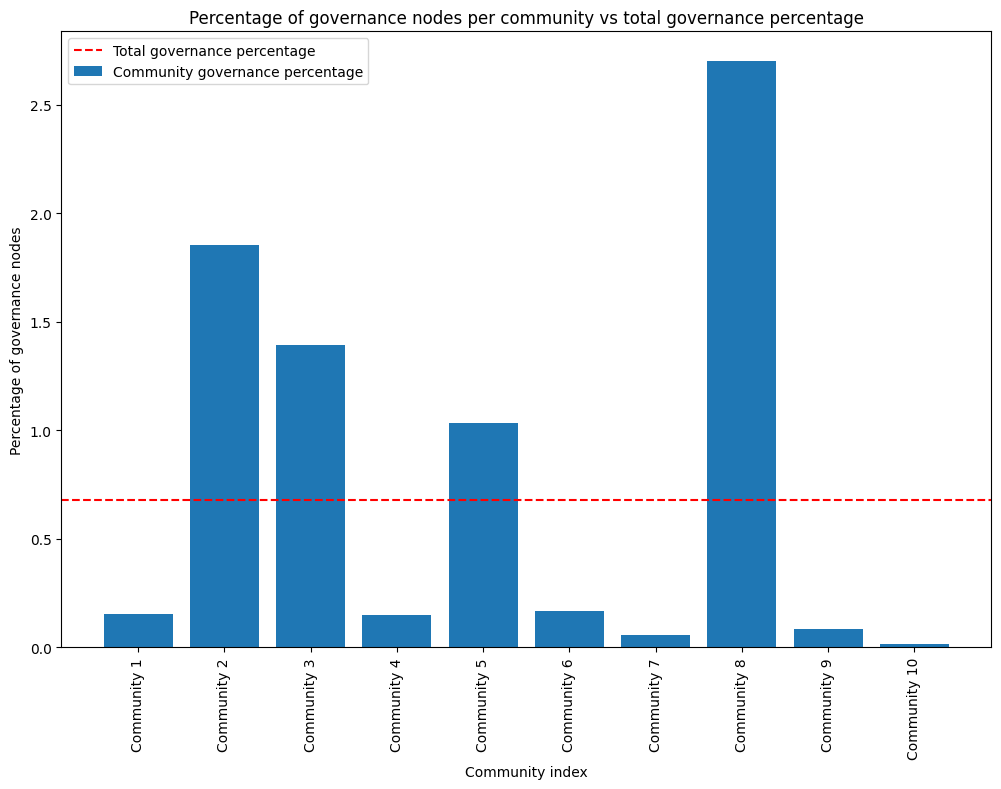

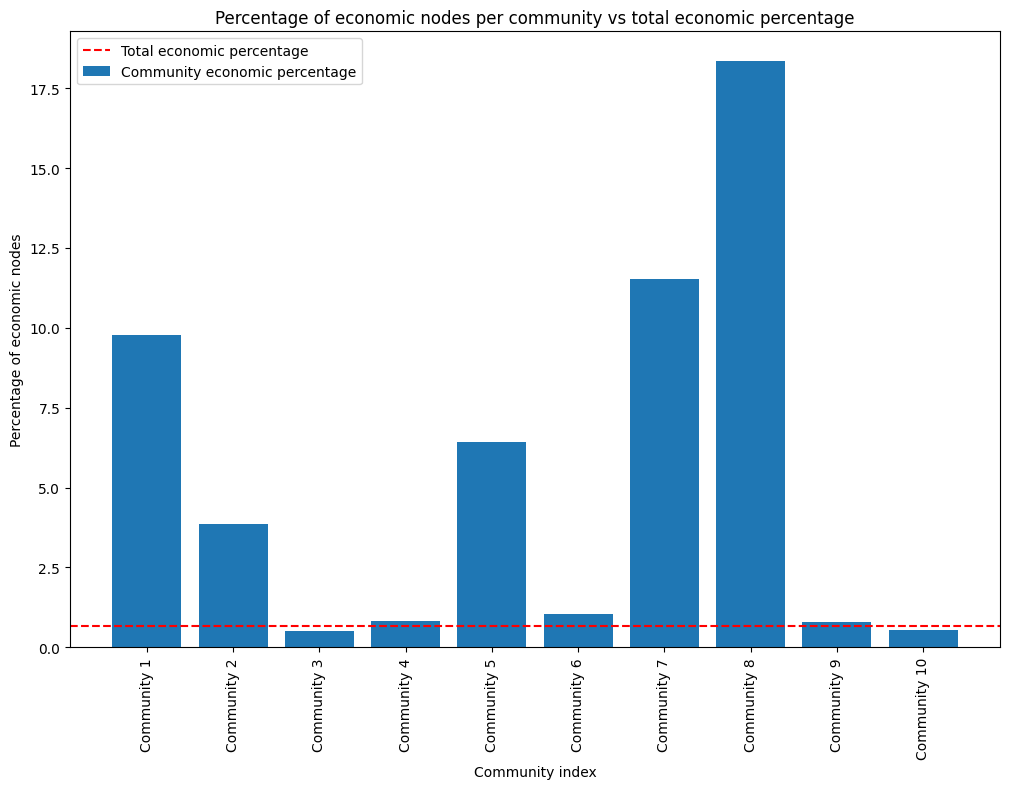

In [20]:
total_governance_percentage = (len(all_voters_in_G_aave) / len(G_aave_nodes)) * 100
total_economic_percentage = (len(all_economic_users_in_G_aave) / len(G_aave_nodes)) * 100

community_governance_percentages = []
community_economic_percentages = []
for community in communities_with_ids:
    governance_count = len(community & all_voters_in_G_aave)
    community_percentage = (governance_count / len(community)) * 100
    community_governance_percentages.append(community_percentage)
    
    economic_count = len(community & all_economic_users_in_G_aave)
    economic_percentage = (economic_count / len(community)) * 100
    community_economic_percentages.append(economic_percentage)

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), community_governance_percentages, label='Community governance percentage')
plt.axhline(y=total_governance_percentage, color='r', linestyle='--', label='Total governance percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of governance nodes')
plt.title('Percentage of governance nodes per community vs total governance percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), community_economic_percentages, label='Community economic percentage')
plt.axhline(y=total_governance_percentage, color='r', linestyle='--', label='Total economic percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of economic nodes')
plt.title('Percentage of economic nodes per community vs total economic percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

## Temporal analysis

In [39]:
aave_price_data = pd.read_csv('data/AAVE_daily_USD.csv', parse_dates=['snapped_at'])
aave_price_data['date'] = aave_price_data['snapped_at'].dt.date

WETH_price_data = pd.read_csv('data/WETH_daily_USD.csv', parse_dates=['snapped_at'])
WETH_price_data['date'] = WETH_price_data['snapped_at'].dt.date

aave_df['date'] = pd.to_datetime(aave_df['timestamp'], unit='s').dt.date
aToken_df['date'] = pd.to_datetime(aToken_df['timestamp'], unit='s').dt.date

aave_daily_transfers = aave_df.groupby('date').agg(
    num_transfers=('value', 'count'),
    total_transferred=('value', 'sum')
).reset_index()

aWETH_daily_transfers = aToken_df.groupby('date').agg(
    num_transfers=('value', 'count'),
    total_transferred=('value', 'sum')
).reset_index()

aave_merged_data = aave_daily_transfers.merge(aave_price_data[['date', 'price']], on='date', how='left')
aWETH_merged_data = aWETH_daily_transfers.merge(WETH_price_data[['date', 'price']], on='date', how='left')

aave_causation_data = aave_merged_data[['price', 'num_transfers', 'total_transferred']].dropna()
aWETH_causation_data = aWETH_merged_data[['price', 'num_transfers', 'total_transferred']].dropna()

C:\Users\Sam\AppData\Local\Temp\ipykernel_16916\3739260312.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aToken_df['date'] = pd.to_datetime(aToken_df['timestamp'], unit='s').dt.date


In [134]:
# aave_df['date'] = pd.to_datetime(aave_df['timestamp'], unit='s').dt.date
aave_df['date'] = pd.to_datetime(aave_df['date'])

In [ ]:
graphs_per_day = {}
graphs_per_week = {}
graphs_per_month = {}

def aggregate_graph(group):
    G = nx.DiGraph()
    for _, row in group.iterrows():
        from_address = row['from'].lower()
        to_address = row['to'].lower()
        value = row['value']
        if G.has_edge(from_address, to_address):
            G[from_address][to_address]['weight'] += value
        else:
            G.add_edge(from_address, to_address, weight=value)
    
    return G

grouped_by_day = aave_df.groupby(pd.Grouper(freq='D'))
for date, grouped_df in grouped_by_day:
    graphs_per_day[date] = aggregate_graph(grouped_df)

grouped_by_week = aave_df.groupby(pd.Grouper(freq='W'))
for date, grouped_df in grouped_by_week:
    graphs_per_week[date] = aggregate_graph(grouped_df)

grouped_by_month = aave_df.groupby(pd.Grouper(freq='ME'))
for date, grouped_df in grouped_by_month:
    graphs_per_month[date] = aggregate_graph(grouped_df)

In [96]:
def gini_coefficient(degrees):
    if len(degrees) == 0:
        return 0

    degrees = np.array(degrees, dtype=np.float64)
    degrees.sort()
    n = len(degrees)
    cumulative = np.cumsum(degrees)
    return (2 * np.sum((np.arange(1, n + 1) * degrees)) - (n + 1) * cumulative[-1]) / (n * cumulative[-1])

def calculate_average_value_per_transfer(grouped_df):
    total_value = grouped_df['value'].sum()
    total_transfers = len(grouped_df)
    return total_value / total_transfers if total_transfers > 0 else 0

def add_average_value_per_transfer(metrics, graphs_per_period):
    metrics['average_value_per_transfer'] = []
    for date, G in graphs_per_period.items():
        grouped_df = aave_df[aave_df['date'] == date]
        avg_value = calculate_average_value_per_transfer(grouped_df)
        metrics['average_value_per_transfer'].append(avg_value)

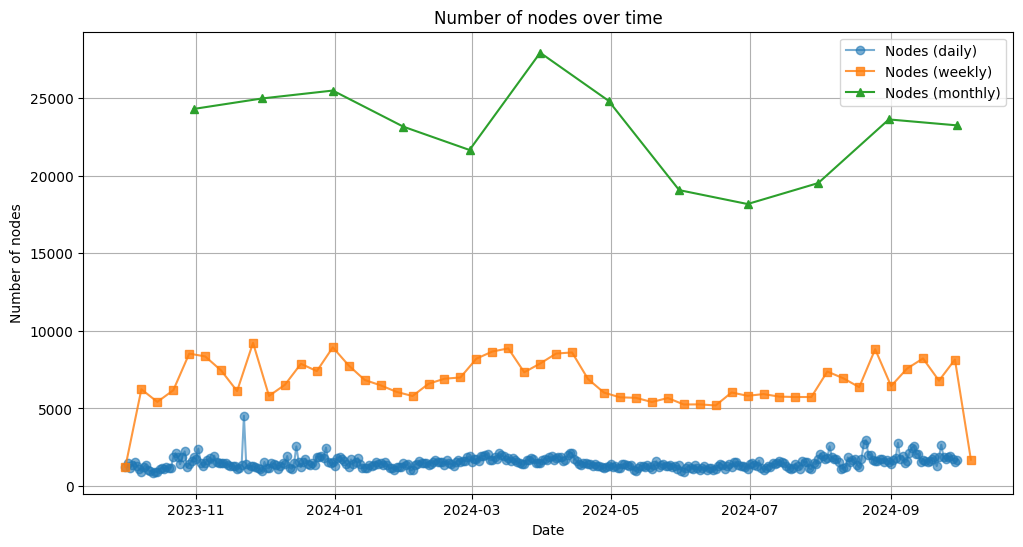

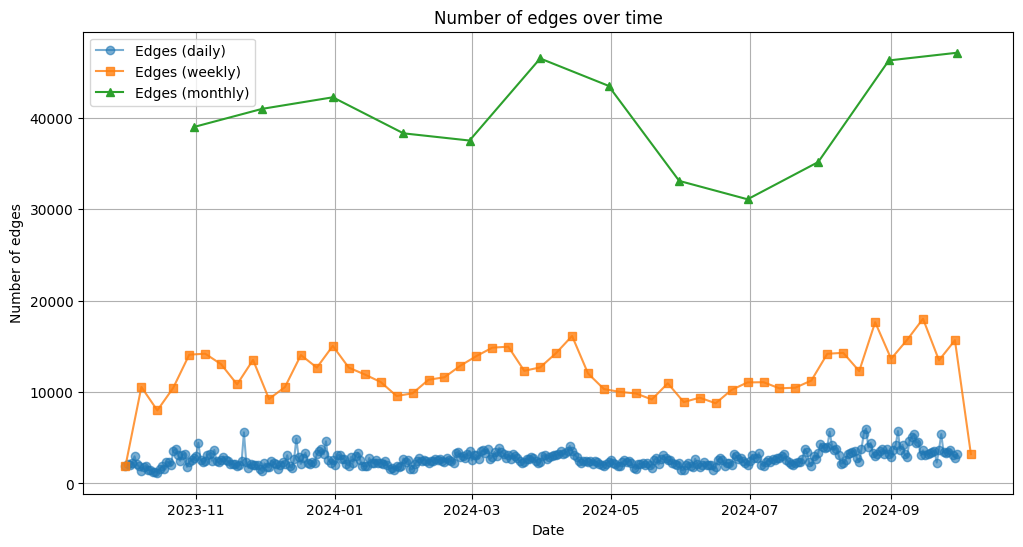

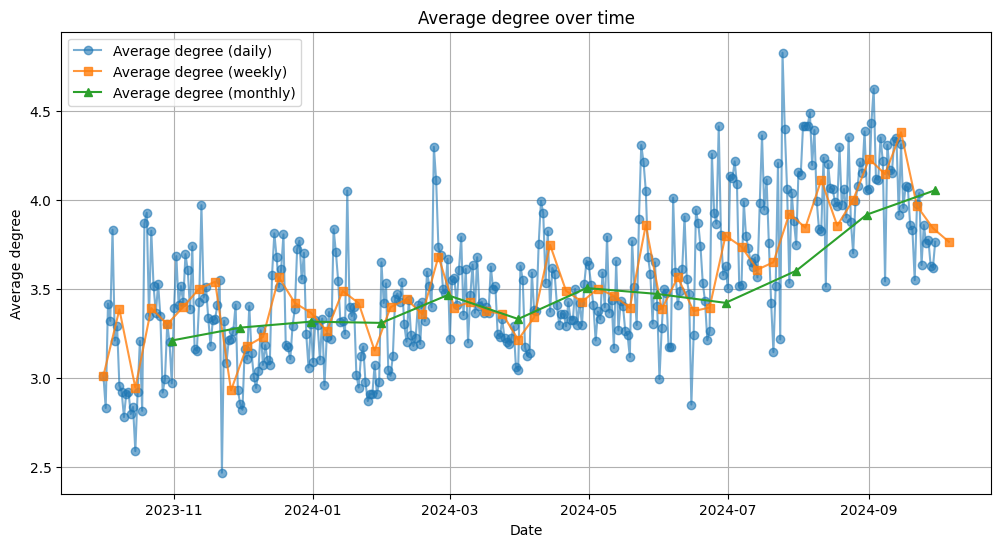

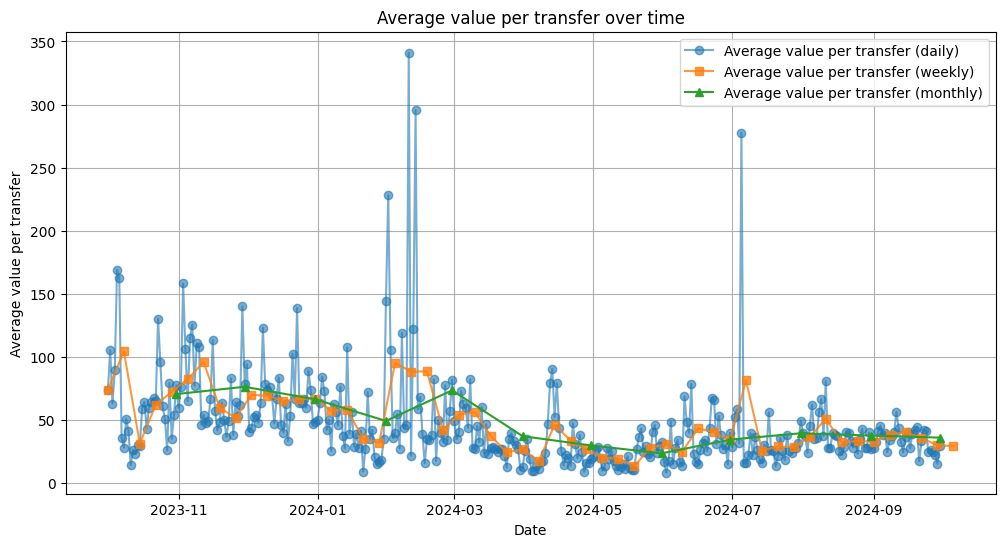

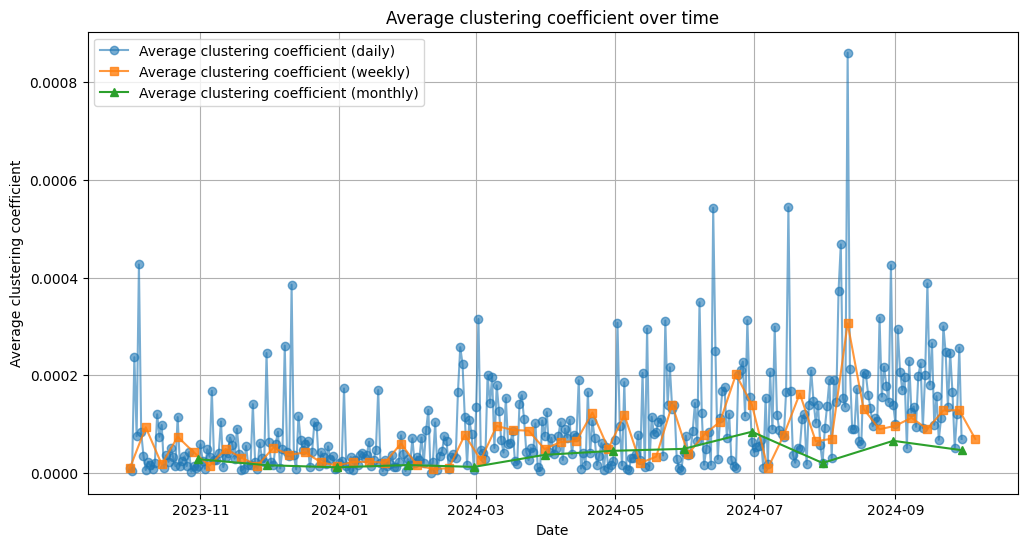

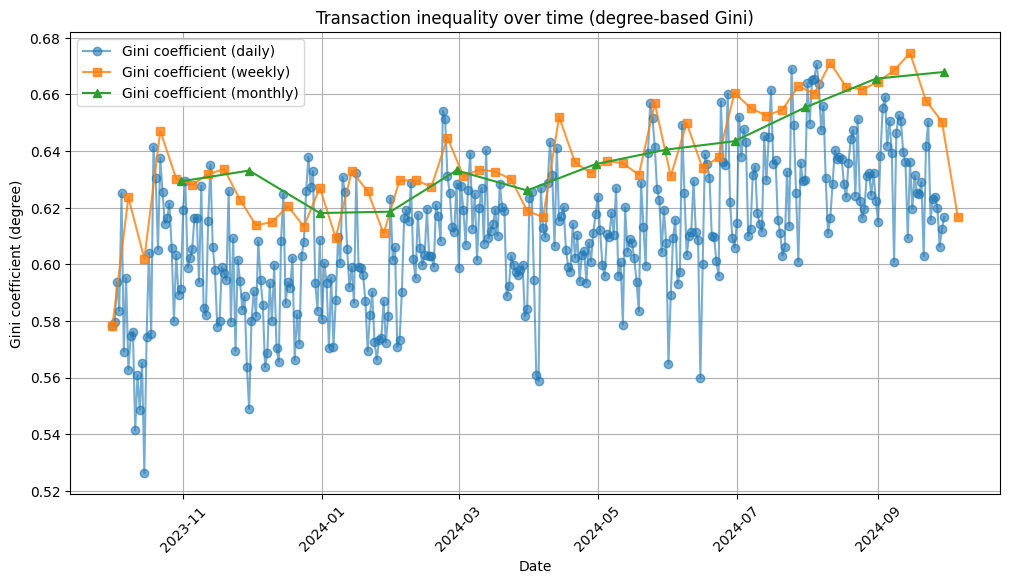

In [136]:
daily_metrics = {
    'date': [],
    'nodes': [],
    'average_degree': [],
    'average_value_per_transfer': [],
    'edges': [],
    'density': [],
    'average_clustering': [],
    'gini': []
}

weekly_metrics = {
    'date': [],
    'nodes': [],
    'average_degree': [],
    'average_value_per_transfer': [],
    'edges': [],
    'density': [],
    'average_clustering': [],
    'gini': []
}

monthly_metrics = {
    'date': [],
    'nodes': [],
    'average_degree': [],
    'average_value_per_transfer': [],
    'edges': [],
    'density': [],
    'average_clustering': [],
    'gini': []
}

for date, G in graphs_per_day.items():
    daily_metrics['date'].append(date)
    daily_metrics['nodes'].append(G.number_of_nodes())
    daily_metrics['edges'].append(G.number_of_edges())
    daily_metrics['density'].append(nx.density(G))
    daily_metrics['average_clustering'].append(nx.average_clustering(G, weight='weight'))
    
    degrees = dict(G.degree())
    average_degree = sum(degrees.values()) / len(degrees)
    daily_metrics['average_degree'].append(average_degree)
    
    avg_value = aave_df[aave_df['date'] == date]['value'].mean()
    daily_metrics['average_value_per_transfer'].append(avg_value)
    
    degrees = [deg for _, deg in G.degree()]
    daily_metrics['gini'].append(gini_coefficient(degrees))
    
for date, G in graphs_per_week.items():
    weekly_metrics['date'].append(date)
    weekly_metrics['nodes'].append(G.number_of_nodes())
    weekly_metrics['edges'].append(G.number_of_edges())
    weekly_metrics['density'].append(nx.density(G))
    weekly_metrics['average_clustering'].append(nx.average_clustering(G, weight='weight'))
    
    degrees = dict(G.degree())
    average_degree = sum(degrees.values()) / len(degrees)
    weekly_metrics['average_degree'].append(average_degree)
    
    avg_value = aave_df[aave_df['date'].dt.to_period('W') == date.to_period('W')]['value'].mean()
    weekly_metrics['average_value_per_transfer'].append(avg_value)
    
    degrees = [deg for _, deg in G.degree()]
    weekly_metrics['gini'].append(gini_coefficient(degrees))
    
for date, G in graphs_per_month.items():
    monthly_metrics['date'].append(date)
    monthly_metrics['nodes'].append(G.number_of_nodes())
    monthly_metrics['edges'].append(G.number_of_edges())
    monthly_metrics['density'].append(nx.density(G))
    monthly_metrics['average_clustering'].append(nx.average_clustering(G, weight='weight'))
    
    degrees = dict(G.degree())
    average_degree = sum(degrees.values()) / len(degrees)
    monthly_metrics['average_degree'].append(average_degree)
    
    avg_value = aave_df[aave_df['date'].dt.to_period('M') == date.to_period('M')]['value'].mean()
    monthly_metrics['average_value_per_transfer'].append(avg_value)
    
    degrees = [deg for _, deg in G.degree()]
    monthly_metrics['gini'].append(gini_coefficient(degrees))

daily_metrics_df = pd.DataFrame(daily_metrics).sort_values(by='date')
weekly_metrics_df = pd.DataFrame(weekly_metrics).sort_values(by='date')
monthly_metrics_df = pd.DataFrame(monthly_metrics).sort_values(by='date')

plt.figure(figsize=(12, 6))
plt.plot(daily_metrics_df['date'], daily_metrics_df['nodes'], marker='o', label='Nodes (daily)', alpha=0.6)
plt.plot(weekly_metrics_df['date'], weekly_metrics_df['nodes'], marker='s', label='Nodes (weekly)', alpha=0.8)
plt.plot(monthly_metrics_df['date'], monthly_metrics_df['nodes'], marker='^', label='Nodes (monthly)', alpha=1.0)
plt.xlabel('Date')
plt.ylabel('Number of nodes')
plt.title('Number of nodes over time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(daily_metrics_df['date'], daily_metrics_df['edges'], marker='o', label='Edges (daily)', alpha=0.6)
plt.plot(weekly_metrics_df['date'], weekly_metrics_df['edges'], marker='s', label='Edges (weekly)', alpha=0.8)
plt.plot(monthly_metrics_df['date'], monthly_metrics_df['edges'], marker='^', label='Edges (monthly)', alpha=1.0)
plt.xlabel('Date')
plt.ylabel('Number of edges')
plt.title('Number of edges over time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(daily_metrics_df['date'], daily_metrics_df['average_degree'], marker='o', label='Average degree (daily)', alpha=0.6)
plt.plot(weekly_metrics_df['date'], weekly_metrics_df['average_degree'], marker='s', label='Average degree (weekly)', alpha=0.8)
plt.plot(monthly_metrics_df['date'], monthly_metrics_df['average_degree'], marker='^', label='Average degree (monthly)', alpha=1.0)
plt.xlabel('Date')
plt.ylabel('Average degree')
plt.title('Average degree over time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(daily_metrics_df['date'], daily_metrics_df['average_value_per_transfer'], marker='o', label='Average value per transfer (daily)', alpha=0.6)
plt.plot(weekly_metrics_df['date'], weekly_metrics_df['average_value_per_transfer'], marker='s', label='Average value per transfer (weekly)', alpha=0.8)
plt.plot(monthly_metrics_df['date'], monthly_metrics_df['average_value_per_transfer'], marker='^', label='Average value per transfer (monthly)', alpha=1.0)
plt.xlabel('Date')
plt.ylabel('Average value per transfer')
plt.title('Average value per transfer over time')
plt.legend()
plt.grid()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(daily_metrics_df['date'], daily_metrics_df['density'], marker='o', label='Density (daily)', alpha=0.6)
# plt.plot(weekly_metrics_df['date'], weekly_metrics_df['density'], marker='s', label='Density (weekly)', alpha=0.8)
# plt.plot(monthly_metrics_df['date'], monthly_metrics_df['density'], marker='^', label='Density (monthly)', alpha=1.0)
# plt.xlabel('Date')
# plt.ylabel('Density')
# plt.title('Network density over time')
# plt.legend()
# plt.grid()
# plt.show()

plt.figure(figsize=(12, 6))
plt.plot(daily_metrics_df['date'], daily_metrics_df['average_clustering'], marker='o', label='Average clustering coefficient (daily)', alpha=0.6)
plt.plot(weekly_metrics_df['date'], weekly_metrics_df['average_clustering'], marker='s', label='Average clustering coefficient (weekly)', alpha=0.8)
plt.plot(monthly_metrics_df['date'], monthly_metrics_df['average_clustering'], marker='^', label='Average clustering coefficient (monthly)', alpha=1.0)
plt.xlabel('Date')
plt.ylabel('Average clustering coefficient')
plt.title('Average clustering coefficient over time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(daily_metrics_df['date'], daily_metrics_df['gini'], marker='o', linestyle='-', label='Gini coefficient (daily)', alpha=0.6)
plt.plot(weekly_metrics_df['date'], weekly_metrics_df['gini'], marker='s', linestyle='-', label='Gini coefficient (weekly)', alpha=0.8)
plt.plot(monthly_metrics_df['date'], monthly_metrics_df['gini'], marker='^', linestyle='-', label='Gini coefficient (monthly)', alpha=1.0)
plt.xlabel('Date')
plt.ylabel('Gini coefficient (degree)')
plt.title('Transaction inequality over time (degree-based Gini)')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [52]:
aave_df["timestamp"] = pd.to_datetime(aave_df["timestamp"], unit="s")

aave_df["date"] = aave_df["timestamp"].dt.date
aave_df["hour"] = aave_df["timestamp"].dt.hour

## Proposal analysis

In [ ]:
for_against_ratio = {
    proposal_id: for_votes[proposal_id] / against_votes[proposal_id] if against_votes[proposal_id] != 0 else None
    for proposal_id in for_votes
}

for i in for_against_ratio:
    if for_against_ratio[i] is not None and for_against_ratio[i] < 100:
        print(i, for_against_ratio[i])

In [81]:
# Filter proposals where the number of votes against was greater than 100000
proposals_against_gt_100k = [
    proposal for proposal in aave_v2_proposals if float(proposal['currentNoVote']) > 100000
] + [
    proposal for proposal in aave_v3_proposals if proposal['votes'] and float(proposal['votes']['againstVotes']) > 100000
]

print("Proposals with votes against greater than 100,000:")
for proposal in proposals_against_gt_100k:
    print(proposal)

# Filter proposals where the number of voters was greater than 300
# proposals_voters_gt_300 = [
#     proposal for proposal in aave_v2_proposals if proposal['totalCurrentVoters'] > 300
# ] + [
#     proposal for proposal in aave_v3_proposals if proposal['totalCurrentVoters'] > 300
# ]

# print("\nProposals with voters greater than 300:")
# for proposal in proposals_voters_gt_300:
#     print(proposal)

Proposals with votes against greater than 100,000:
{'currentNoVote': '351525.2273101236', 'currentYesVote': '551489.7022624846', 'id': '396', 'state': 'Executed', 'timestamp': 1701720191, 'totalCurrentVoters': 23, 'user': {'aaveTotalPropositionPower': '168268.375842634783263112', 'aaveTotalVotingPower': '1601.70038171', 'id': '0x683a4f9915d6216f73d6df50151725036bd26c02', 'stkAaveTotalPropositionPower': '0', 'stkAaveTotalVotingPower': '0', 'totalPropositionPower': '168268.375842634783263112', 'totalVotingPower': '1601.70038171'}, 'title': '#  Gauntlet <> Aave Renewal 2023', 'description': '#  Gauntlet <> Aave Renewal 2023\n\n---\ntitle: "Gauntlet <> Aave Renewal 2023"\nauthor: "Gauntlet"\ndiscussions: "https://governance.aave.com/t/arfc-gauntlet-aave-renewal-2023/15380"\n---\n\n## Summary\n\nA proposal to renew Gauntlet’s 12-month engagement with Aave on continuous market risk management to maximize capital efficiency while minimizing the risk of insolvency and liquidations to create lo

In [ ]:
for p in aave_v2_proposals:
    id = p['id']
    title = p['title']
    print(f'{id}: {title}')
    
for p in aave_v3_proposals:
    id = p['id']
    title = p['proposalMetadata']['title']
    print(f'{id}: {title}')

In [59]:
CATEGORIES = {
    "Treasury & Financial Management": [
        "treasury", "funding", "gho", "liquidity", 
        "safety module", "emissions", "finance update"
    ],
    "Governance Ops & Service Providers": [
        "emission manager", "governance", "tokenlogic", 
        "chaos labs", "gauntlet", "service provider", "proposal activation"
    ],
    "Risk & Parameter Updates": [
        "risk parameter", "reserve factor", "interest rate", "borrow cap", 
        "lt/ltv", "debt ceiling", "onboard", "offboard", "deprecate"
    ],
    "Protocol/Technical Upgrades": [
        "upgrade", "activation", "maintenance", "deprecation", 
        "periphery", "adapter", "implementation", "bug"
    ],
    "Security": [
        "security", "sentinel", "emergency admin", 
        "freeze", "bug bounty"
    ],
    "Misc/Experimental": [
        "orbit program", "event", "competition", 
        "strategy", "liquidity incentive", "embassy"
    ]
}

# CATEGORIES = {
#     "Treasury & Financial Management": [
#         "treasury", "funding", "gho", "liquidity", "allowance", 
#         "transfer", "financial", "payment", "revenue"
#     ],
#     "Governance & Service Providers": [
#         "governance", "emission manager", "provider", "tokenlogic", 
#         "gauntlet", "chaos labs", "aci", "delegate", "committee"
#     ],
#     "Risk & Parameter Updates": [
#         "risk parameter", "lt/ltv", "lt reduction", "debt ceiling",
#         "reserve factor", "interest rate", "borrow cap", 
#         "supply cap", "price feed", "curve amendment"
#     ],
#     "Protocol/Technical Upgrades": [
#         "upgrade", "activation", "implementation", "periphery", 
#         "adapter", "robot", "migration", "scroll", "maintenance", 
#         "freeze", "deprecation", "bug"
#     ],
#     "Security & Emergency": [
#         "security", "sentinel", "emergency", "bounty", "admin", "incident"
#     ],
#     "Miscellaneous / Ecosystem": [
#         "orbit", "event", "competition", "embassy", 
#         "strategy", "superfest", "program", "grant"
#     ]
# }

def categorize_proposal(title):
    title_lower = title.lower()
    matched = [cat for cat, keys in CATEGORIES.items() if any(k in title_lower for k in keys)]
    return matched if matched else [""]

In [ ]:
category_dicts = defaultdict(dict)

for proposal in aave_v2_proposals:
    id = proposal['id']
    title = proposal['title']
    # if categorize_proposal(title) == ['None']:
    #     print(id, categorize_proposal(proposal['description']))
    # print(f'{id}: {categorize_proposal(title)}')
    
    categories = categorize_proposal(title)
    
    if categories == [""]:
        continue
    
    cat = categories[0]
    category_dicts[cat][proposal['id']] = {
        "timestamp": proposal['timestamp'],
        "voters": proposal['totalCurrentVoters'],
        "state": proposal['state'],
        "for_votes": proposal['currentYesVote'],
        "against_votes": proposal['currentNoVote']
    }
    
# print('')
    
for proposal in aave_v3_proposals:
    id = proposal['id']
    title = proposal['proposalMetadata']['title']
    # if categorize_proposal(title) == ['None']:
    #     print(id, categorize_proposal(proposal['proposalMetadata']['rawContent']))
    # print(f'{id}: {categorize_proposal(title)}')
    
    categories = categorize_proposal(title)
    
    if categories == [""]:
        continue
    
    cat = categories[0]
    category_dicts[cat][proposal['id']] = {
        "timestamp": int(proposal['transactions']['created']['timestamp']),
        "voters": proposal['totalCurrentVoters'],
        "state": proposal['state'],
        "for_votes": proposal['votes']['forVotes'] if proposal['votes'] else 0,
        "against_votes": proposal['votes']['againstVotes'] if proposal['votes'] else 0
    }

In [67]:
governance_service_dict = category_dicts['Governance Ops & Service Providers']
treasury_dict = category_dicts['Treasury & Financial Management']

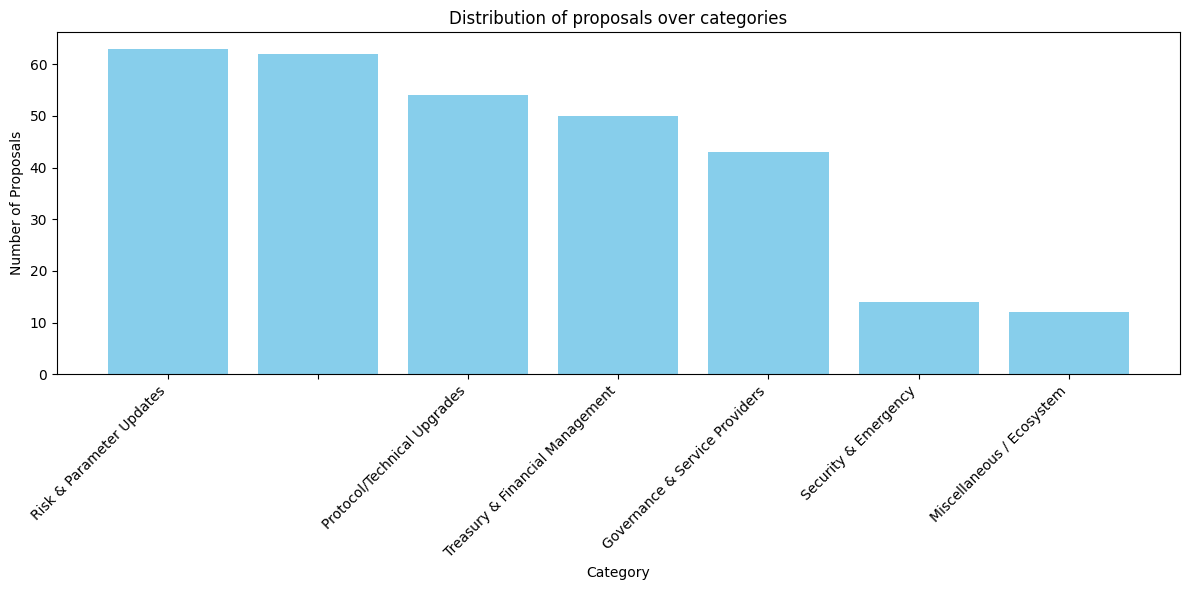

In [53]:
category_counts = Counter()
for proposal in aave_v2_proposals + aave_v3_proposals:
    title = proposal['title'] if 'title' in proposal else proposal['proposalMetadata']['title']
    categories = categorize_proposal(title)
    for category in categories:
        category_counts[category] += 1

categories, counts = zip(*sorted(category_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Proposals')
plt.title('Distribution of proposals over categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [79]:
aave_price_data = pd.read_csv('data/AAVE_daily_USD.csv')#, parse_dates=['snapped_at'])

                 avg_price  total_transfers  num_transfers    voters  \
avg_price         1.000000         0.079149       0.500419 -0.432059   
total_transfers   0.079149         1.000000       0.629843 -0.026197   
num_transfers     0.500419         0.629843       1.000000 -0.219016   
voters           -0.432059        -0.026197      -0.219016  1.000000   
for_votes         0.114204         0.042543       0.170837  0.108554   
against_votes    -0.025478        -0.066225      -0.149657 -0.081231   

                 for_votes  against_votes  
avg_price         0.114204      -0.025478  
total_transfers   0.042543      -0.066225  
num_transfers     0.170837      -0.149657  
voters            0.108554      -0.081231  
for_votes         1.000000      -0.292823  
against_votes    -0.292823       1.000000  


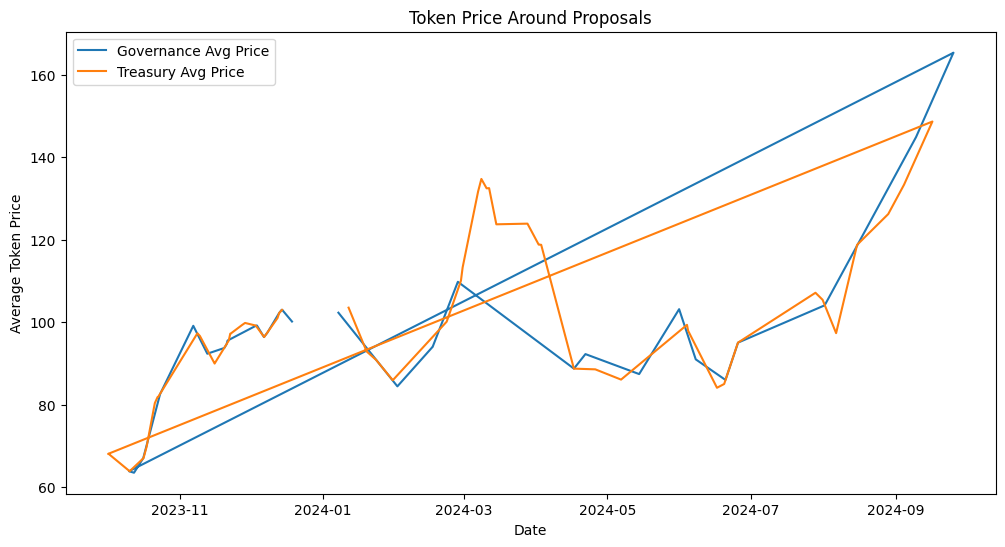

In [ ]:
for category_dict in [governance_service_dict, treasury_dict]:
    for proposal_id, proposal_data in category_dict.items():
        proposal_data['date'] = pd.to_datetime(proposal_data['timestamp'], unit='s')

token_data = aave_df.groupby('date').agg(
    total_transfers=('value', 'sum'),
    num_transfers=('value', 'count')
).reset_index()

aave_price_data['snapped_at'] = pd.to_datetime(aave_price_data['snapped_at'].str.replace(' UTC', ''))
aave_price_data.rename(columns={'snapped_at': 'date'}, inplace=True)

token_data['date'] = pd.to_datetime(token_data['date'])
aave_price_data['date'] = pd.to_datetime(aave_price_data['date'])

token_data = token_data.merge(aave_price_data[['date', 'price']], on='date', how='left')

proposal_windows = []
for category_dict in [governance_service_dict, treasury_dict]:
    for proposal_id, proposal_data in category_dict.items():
        proposal_date = proposal_data['date']
        window_start = proposal_date - pd.Timedelta(days=1)
        window_end = proposal_date + pd.Timedelta(days=6)
        window_data = token_data[(token_data['date'] >= window_start) & (token_data['date'] <= window_end)]
        proposal_windows.append({
            'proposal_id': proposal_id,
            'category': 'Governance' if category_dict is governance_service_dict else 'Treasury',
            'window_start': window_start,
            'window_end': window_end,
            'avg_price': window_data['price'].mean(),
            'total_transfers': window_data['total_transfers'].sum(),
            'num_transfers': window_data['num_transfers'].sum(),
            'voters': proposal_data['voters'],
            'for_votes': float(proposal_data['for_votes']),
            'against_votes': float(proposal_data['against_votes']),
            'state': proposal_data['state']
        })

proposal_windows_df = pd.DataFrame(proposal_windows)

correlations = proposal_windows_df[['avg_price', 'total_transfers', 'num_transfers', 'voters', 'for_votes', 'against_votes']].corr()
print(correlations)

plt.figure(figsize=(12, 6))
for category in ['Governance', 'Treasury']:
    subset = proposal_windows_df[proposal_windows_df['category'] == category]
    plt.plot(subset['window_start'], subset['avg_price'], label=f'{category} Avg Price')
plt.xlabel('Date')
plt.ylabel('Average Token Price')
plt.title('Token Price Around Proposals')
plt.legend()
plt.show()

### Temp

In [ ]:
# governance_service_dict
# treasury_dict

combined_dicts = governance_service_dict | treasury_dict | category_dicts['Risk & Parameter Updates'] | category_dicts['Protocol/Technical Upgrades'] | category_dicts['Security'] | category_dicts['Misc/Experimental']

In [128]:
proposals_df = pd.DataFrame.from_dict(combined_dicts, orient='index')
proposals_df['date'] = pd.to_datetime(proposals_df['timestamp'], unit='s')
proposals_df['vote_start'] = proposals_df['date'] + timedelta(days=1)
proposals_df['vote_end'] = proposals_df['vote_start'] + timedelta(days=5)  # approx
proposals_df['execution'] = proposals_df['vote_end']

# token_data['date'] = pd.to_datetime(token_data['date'])
# token_data.set_index('date', inplace=True)

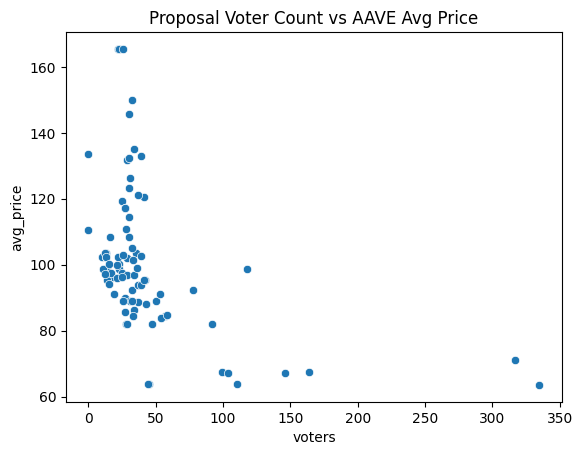

In [133]:
event_window_data = []

for _, row in proposals_df.iterrows():
    window = token_data.loc[row['date']: row['execution']]
    if not window.empty:
        avg_price = window['price'].mean()
        total_transfers = window['total_transfers'].sum()
        event_window_data.append({
            'proposal_id': row.name,
            'voters': row['voters'],
            'avg_price': avg_price,
            'total_transfers': total_transfers
        })

event_df = pd.DataFrame(event_window_data)

sns.scatterplot(data=event_df, x='voters', y='avg_price')
plt.title("Proposal Voter Count vs AAVE Avg Price")
plt.show()

In [161]:
control_data = []
window_len = timedelta(days=6)

for _ in range(1000):
    random_start = token_data.sample(1).index[0]
    random_end = random_start + window_len

    if random_end in token_data.index:
        window = token_data.loc[random_start:random_end]
        control_data.append({
            'avg_price': window['price'].mean(),
            'total_transfers': window['total_transfers'].sum()
        })

control_df = pd.DataFrame(control_data)

In [162]:
t_stat, p_val_price = ttest_ind(event_df['avg_price'], control_df['avg_price'], equal_var=False)

t_stat2, p_val_transfers = ttest_ind(event_df['total_transfers'], control_df['total_transfers'], equal_var=False)

print(f"Price effect p-value: {p_val_price}")
print(f"Transfer effect p-value: {p_val_transfers}")

Price effect p-value: 0.8380796996878661
Transfer effect p-value: 2.313530942692755e-05


In [116]:
X = event_df[['voters']]
X = sm.add_constant(X)
y = event_df['avg_price']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              avg_price   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     4.940
Date:                Mon, 14 Apr 2025   Prob (F-statistic):             0.0332
Time:                        16:33:02   Log-Likelihood:                -159.61
No. Observations:                  35   AIC:                             323.2
Df Residuals:                      33   BIC:                             326.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        106.4292      5.024     21.183      0.0

## SI

In [128]:
def normalize_weights(G):
    max_weight = max(data['weight'] for _, _, _, data in G.edges(keys=True, data=True))
    
    for _, _, _, data in G.edges(keys=True, data=True):
        data['norm_weight'] = data['weight'] / max_weight
    
    return G

def log_normalize_weights(G):
    max_weight = np.log1p(max(data['weight'] for _, _, _, data in G.edges(keys=True, data=True)))
    
    for _, _, _, data in G.edges(keys=True, data=True):
        data['norm_weight'] = np.log1p(data['weight']) / max_weight
    
    return G

### Simple SI model

In [ ]:
G = copy.deepcopy(G_aave_complete)
# G_T = copy.deepcopy(G_aave_complete)

G = log_normalize_weights(G)
# G_T = normalize_weights(G_T)

In [125]:
def preprocess_out_edges(G, beta=1.0):
    out_edges = defaultdict(list)
    
    for u, v, k, d in G.edges(keys=True, data=True):
        out_edges[u].append((v, d['timestamp'], beta * d['norm_weight']))
    
    return out_edges

def simulate_SI(G, seed_node, beta=1.0, cached_edges=None):
    infected = {}
    infection_queue = []

    infected[seed_node] = 1696118400
    heapq.heappush(infection_queue, (1696118400, seed_node))

    while infection_queue:
        curr_time, node = heapq.heappop(infection_queue)
        
        if node not in cached_edges:
            continue
        
        for neighbor, ts, prob in cached_edges[node]:
        # for _, neighbor, _, data in G.out_edges(node, keys=True, data=True):
            if neighbor in infected:
                continue
            
            # ts = data['timestamp']
            # prob = beta * data['norm_weight']

            if ts >= curr_time:
                if np.random.rand() < prob:
                    infected[neighbor] = ts
                    heapq.heappush(infection_queue, (ts, neighbor))

    return infected

def run_multiple_iterations(G, num_iterations=100, beta=1.0):
    all_nodes = list(G.nodes)
    infection_counts = defaultdict(list)
    infections_per_iteration = defaultdict(list)
    
    cached_edges = preprocess_out_edges(G, beta)

    for i in range(num_iterations):
        print(f"Iteration {i+1}/{num_iterations}")
        # for seed in tqdm(all_nodes, desc=f"SI iteration {i+1}"):
        for seed in all_nodes:
            infected = simulate_SI(G, seed, beta, cached_edges)
            infection_counts[seed].append(len(infected))
            infections_per_iteration[seed].append(infected)

    avg_results = [{
        'seed': node,
        'avg_infected': sum(counts) / len(counts),
        'infections_per_iteration': infections_per_iteration[node]
        # 'all_infected_counts': counts
    } for node, counts in infection_counts.items()]

    top_avg_influencers = sorted(avg_results, key=lambda x: x['avg_infected'], reverse=True)

    return top_avg_influencers

### Simulations

In [ ]:
SI_T_001 = run_multiple_iterations(G_T, num_iterations=10, beta=0.01)

In [19]:
with open('SI_T_001.pkl', 'wb') as file:
    pickle.dump(SI_T_001, file)

In [ ]:
SI_T_01 = run_multiple_iterations(G_T, num_iterations=10, beta=0.1)

In [21]:
with open('SI_T_01.pkl', 'wb') as file:
    pickle.dump(SI_T_01, file)

In [ ]:
SI_T_05 = run_multiple_iterations(G_T, num_iterations=10, beta=0.5)

In [23]:
with open('SI_T_05.pkl', 'wb') as file:
    pickle.dump(SI_T_05, file)

In [ ]:
SI_T_1 = run_multiple_iterations(G_T, num_iterations=10, beta=1.0)

In [25]:
with open('SI_T_1.pkl', 'wb') as file:
    pickle.dump(SI_T_1, file)

In [ ]:
SI_001 = run_multiple_iterations(G, num_iterations=10, beta=0.01)

In [56]:
with open('SI_001_1.pkl', 'wb') as file:
    pickle.dump(SI_001, file)

In [ ]:
SI_01 = run_multiple_iterations(G, num_iterations=10, beta=0.1)

In [58]:
with open('SI_01_1.pkl', 'wb') as file:
    pickle.dump(SI_01, file)

In [ ]:
SI_05 = run_multiple_iterations(G, num_iterations=10, beta=0.5)

In [9]:
with open('SI_05.pkl', 'wb') as file:
    pickle.dump(SI_05, file)

### Analysis

In [133]:
with open('SI_1_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_1_extracted = pickle.load(f)
    
with open('SI_1_7_extracted.pkl', 'rb') as f:
    SI_1_7_extracted = pickle.load(f)

In [134]:
combined_data = {}

def update_combined_data(data, iterations):
    for entry in data:
        seed = entry['seed']
        avg_infected = entry['avg_infected']
        if seed not in combined_data:
            combined_data[seed] = {'total_infected': 0, 'iterations': 0}
        combined_data[seed]['total_infected'] += avg_infected * iterations

update_combined_data(SI_1_extracted, 9)
update_combined_data(SI_1_7_extracted, 1)

SI_1_extracted_new = [
    {'seed': seed, 'avg_infected': data['total_infected'] / 10}
    for seed, data in combined_data.items()
]

In [136]:
with open('SI_1_extracted_seeds_avg_infected.pkl', 'wb') as new_file:
    pickle.dump(sorted(SI_1_extracted_new, key=lambda x: x['avg_infected'], reverse=True), new_file)

In [2]:
with open('SI_05.pkl', 'rb') as f:
    SI_05 = pickle.load(f)
    
extracted_data = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_05]

with open('SI_05_extracted_seeds_avg_infected.pkl', 'wb') as new_file:
    pickle.dump(extracted_data, new_file)

In [ ]:
SI_1 = joblib.load('SI_1.pkl')

extracted_data = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_1]

with open('extracted_seeds_avg_infected.pkl', 'wb') as new_file:
    pickle.dump(extracted_data, new_file)

In [5]:
SI_01_outcome = joblib.load('SI_01.pkl')
SI_01_1_outcome = joblib.load('SI_01_1.pkl')

In [8]:
SI_01_1_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_01_1_outcome]

In [138]:
SI_001_outcome = joblib.load('SI_001_1.pkl')
SI_01_outcome = joblib.load('SI_01_1.pkl')
SI_05_outcome = joblib.load('SI_05_extracted_seeds_avg_infected.pkl')
SI_1_outcome = joblib.load('SI_1_extracted_seeds_avg_infected.pkl')

# SI_T_01_outcome = joblib.load('SI_T_01.pkl')
# SI_T_001_outcome = joblib.load('SI_T_001.pkl')
# SI_T_05_outcome = joblib.load('SI_T_05.pkl')
# SI_T_1_outcome = joblib.load('SI_T_1.pkl')

In [139]:
avg_infected_001 = [entry['avg_infected'] for entry in SI_001_outcome]
avg_infected_01 = [entry['avg_infected'] for entry in SI_01_outcome]
avg_infected_05 = [entry['avg_infected'] for entry in SI_05_outcome]
avg_infected_1 = [entry['avg_infected'] for entry in SI_1_outcome]

# avg_infected_001_T = [entry['avg_infected'] for entry in SI_T_001_outcome]
# avg_infected_01_T = [entry['avg_infected'] for entry in SI_T_01_outcome]
# avg_infected_05_T = [entry['avg_infected'] for entry in SI_T_05_outcome]
# avg_infected_1_T = [entry['avg_infected'] for entry in SI_T_1_outcome]

In [140]:
influence_scores = {
    '0.01': {seed['seed']: seed['avg_infected'] for seed in SI_001_outcome},
    '0.1': {seed['seed']: seed['avg_infected'] for seed in SI_01_outcome},
    '0.5': {seed['seed']: seed['avg_infected'] for seed in SI_05_outcome},
    '1.0': {seed['seed']: seed['avg_infected'] for seed in SI_1_outcome}
}

influence_df = pd.DataFrame(influence_scores)

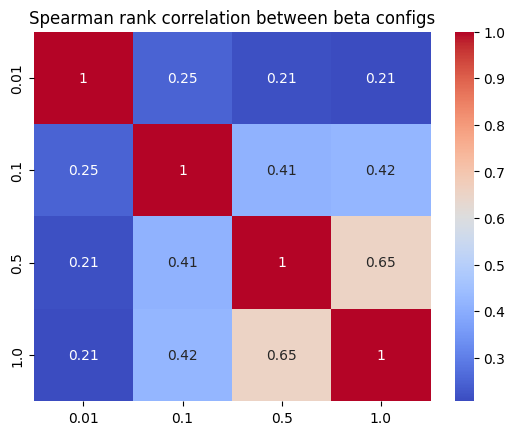

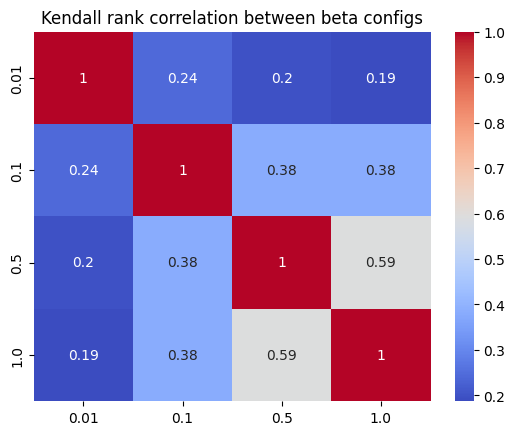

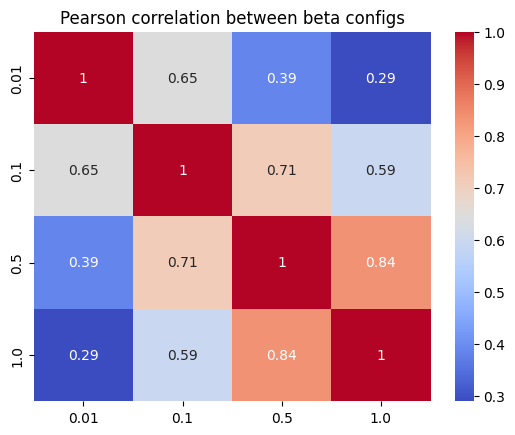

In [141]:
spearman_corr = influence_df.corr(method='spearman')
kendall_corr = influence_df.corr(method='kendall')
pearson_corr = influence_df.corr(method='pearson')

sns.heatmap(spearman_corr, annot=True, cmap="coolwarm")
plt.title("Spearman rank correlation between beta configs")
plt.show()

sns.heatmap(kendall_corr, annot=True, cmap="coolwarm")
plt.title("Kendall rank correlation between beta configs")
plt.show()

sns.heatmap(pearson_corr, annot=True, cmap="coolwarm")
plt.title("Pearson correlation between beta configs")
plt.show()

In [ ]:
def compute_infection_curves(all_results, bin_size=3600, seed_time=1696118400):
    all_timestamps = []

    for result in all_results:
        for infection_dict in result['infections_per_iteration']:
            for ts in infection_dict.values():
                if ts != seed_time:
                    all_timestamps.append(ts)

    if not all_timestamps:
        return [], []

    min_time = min(all_timestamps)
    max_time = max(all_timestamps)
    
    num_runs = len(all_results[0]['infections_per_iteration'])
    
    bins = np.arange(min_time, max_time + bin_size, bin_size)
    hist, bin_edges = np.histogram(all_timestamps, bins=bins)
    
    hist = hist / num_runs
    
    cumulative = np.cumsum(hist) / num_runs
    time_bins_cumulative = bins[1:]

    time_bins_general = bin_edges[1:]

    return time_bins_general, hist, time_bins_cumulative, cumulative

def plot_infection_rates(beta, results_dict, bin_size=3600):
    time_bins_gen, hist, time_bins_cum, cum = compute_infection_curves(results_dict, bin_size)

    plt.plot(time_bins_gen, hist, label=f"β={beta}")
    plt.xlabel("Timestamp")
    plt.ylabel("New infections")
    plt.title("Infection rate over time")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.plot(time_bins_cum, cum, label=f"β={beta}")
    plt.xlabel("Timestamp")
    plt.ylabel("Cumulative infections")
    plt.title("Infection growth over time")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
daily_counts = aave_df.groupby("date").size().reset_index()
daily_counts.columns = ["date", "count"]

daily_counts["date"] = pd.to_datetime(daily_counts["date"])

daily_counts["month"] = daily_counts["date"].dt.strftime("%Y-%m")
daily_counts["day"] = daily_counts["date"].dt.day

heatmap_data = daily_counts.pivot(index="month", columns="day", values="count")

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap="Blues", linewidths=0.5)
plt.xlabel("Day of month")
plt.ylabel("Month")
plt.title("Daily transaction heatmap (aggregated by month)")
plt.show()

10


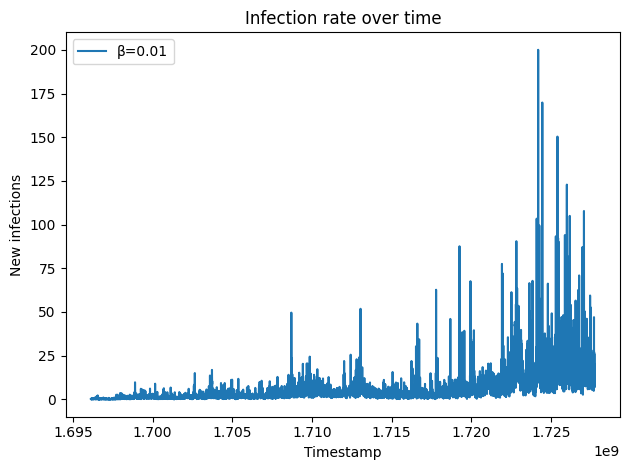

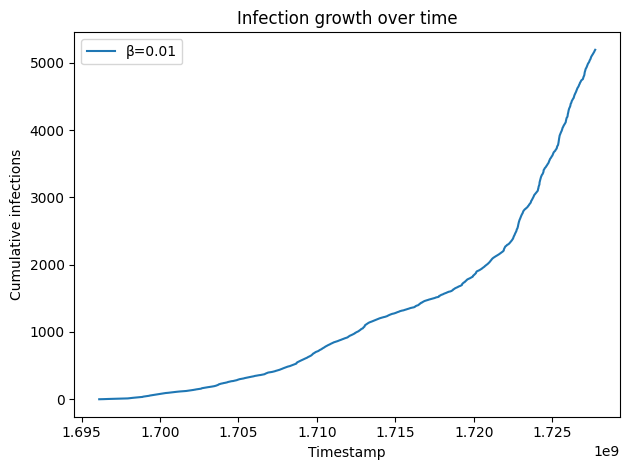

In [60]:
plot_infection_rates(0.01, SI_001_outcome)

10


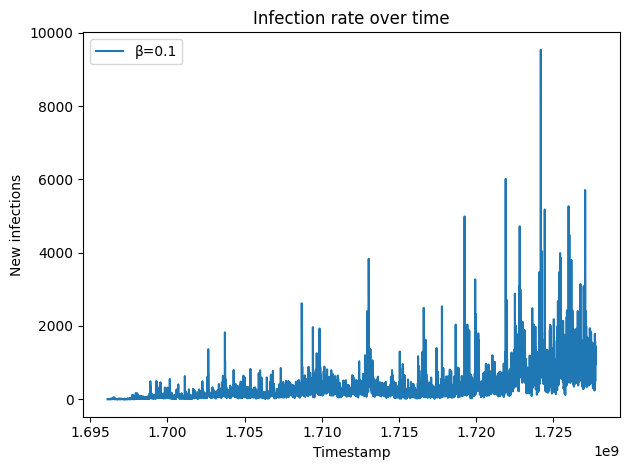

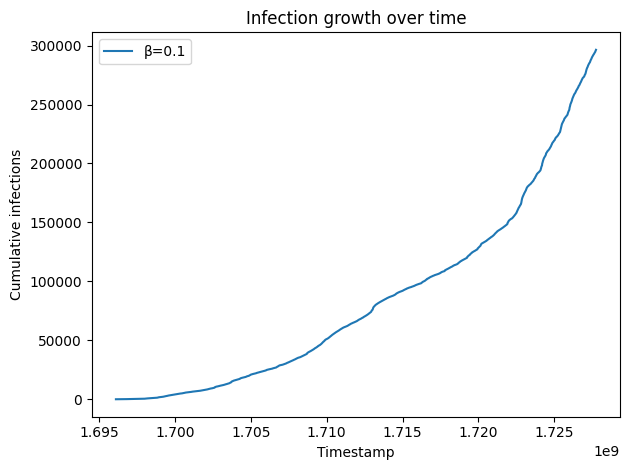

In [61]:
plot_infection_rates(0.1, SI_01_outcome)

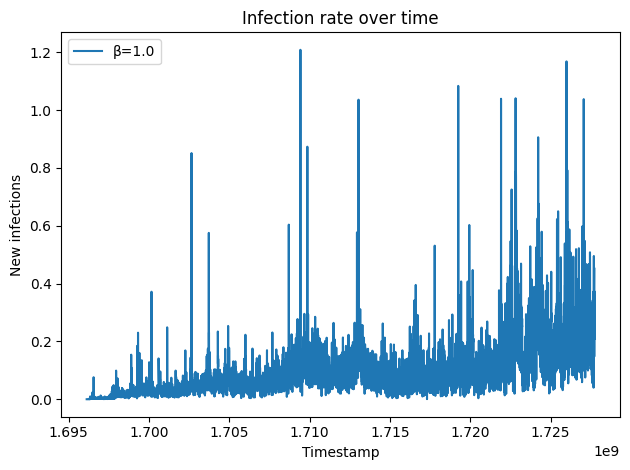

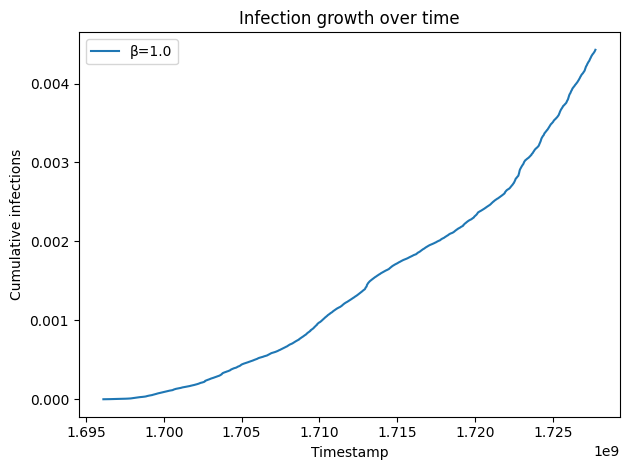

In [56]:
plot_infection_rates(1.0, SI_1_1_outcome)

In [191]:
def hist_comparison(data1, data2, data3, data4, normalization):    
    plt.figure(figsize=(12, 6))
    plt.hist(data1, bins=30, alpha=0.6, label='Beta = 0.01', edgecolor='black', log=True)
    plt.xlabel('Average number of infected nodes')
    plt.ylabel('Frequency (log scale)')
    plt.title(normalization)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.hist(data2, bins=30, alpha=0.6, label='Beta = 0.1', edgecolor='black', log=True)
    plt.xlabel('Average number of infected nodes')
    plt.ylabel('Frequency (log scale)')
    plt.title(normalization)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.hist(data3, bins=30, alpha=0.6, label='Beta = 0.5', edgecolor='black', log=True)
    plt.xlabel('Average number of infected nodes')
    plt.ylabel('Frequency (log scale)')
    plt.title(normalization)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.hist(data4, bins=30, alpha=0.6, label='Beta = 1.0', edgecolor='black', log=True)
    plt.xlabel('Average number of infected nodes')
    plt.ylabel('Frequency (log scale)')
    plt.title(normalization)
    plt.legend()
    plt.show()

    for beta, avg_infected in zip([0.01, 0.1, 0.5, 1.0], 
                                   [avg_infected_001, avg_infected_01, avg_infected_05, avg_infected_1]):
        mean = np.mean(avg_infected)
        std_dev = np.std(avg_infected)
        print(f"Beta = {beta}: Mean = {mean:.2f}, Std Dev = {std_dev:.2f}")

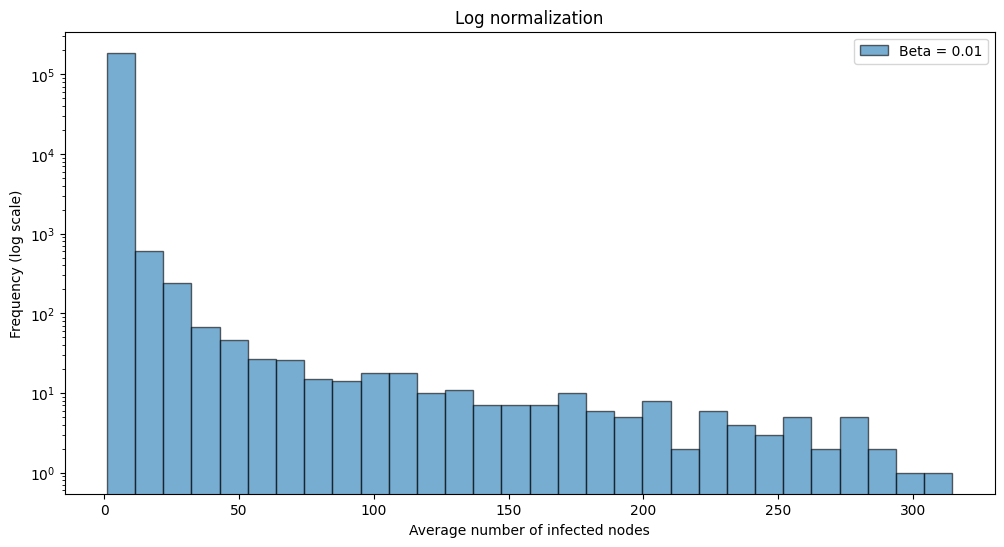

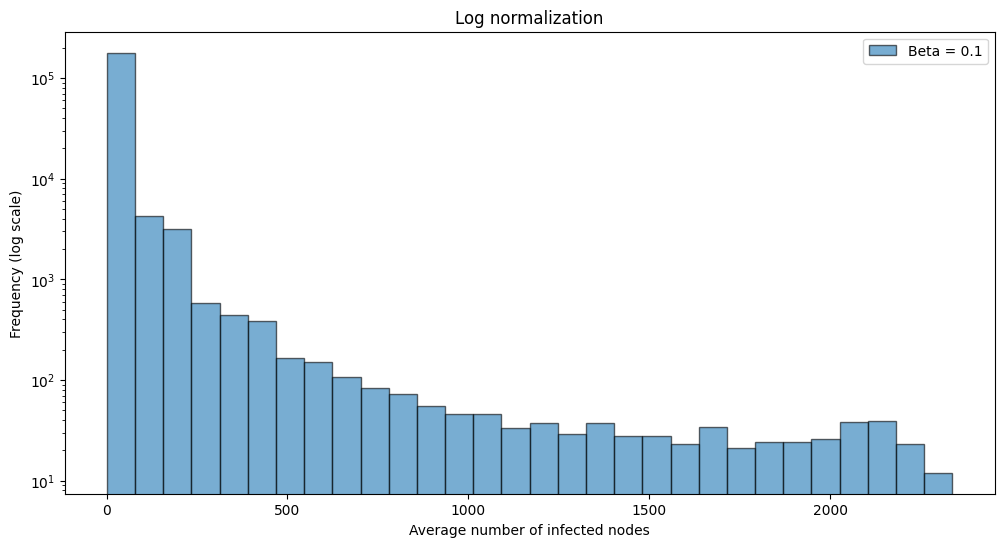

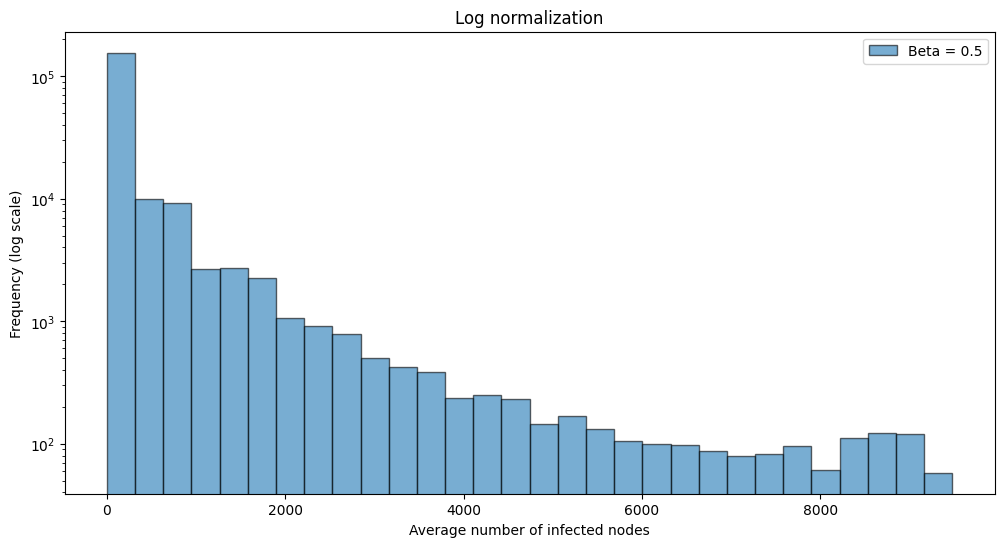

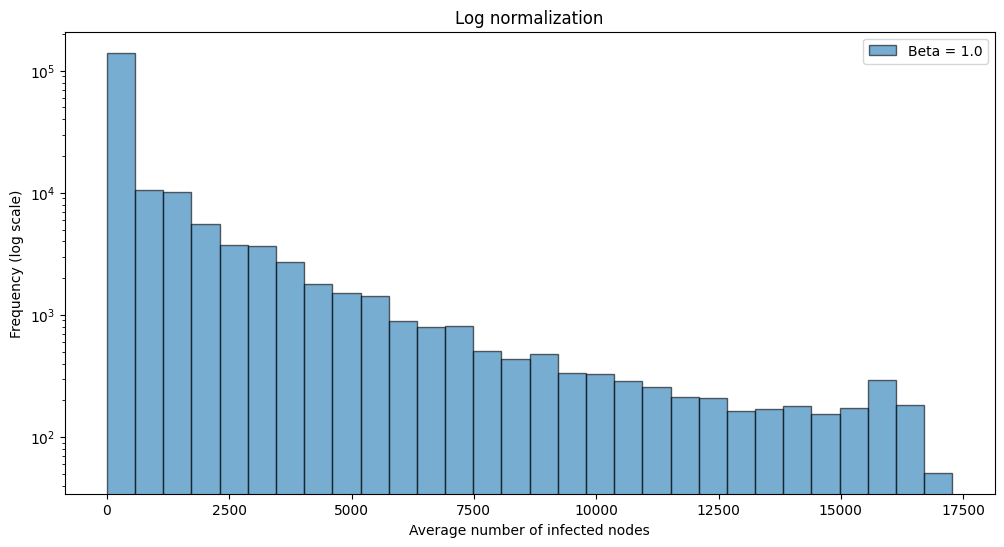

Beta = 0.01: Mean = 1.28, Std Dev = 5.22
Beta = 0.1: Mean = 16.73, Std Dev = 103.33
Beta = 0.5: Mean = 258.44, Std Dev = 834.79
Beta = 1.0: Mean = 836.57, Std Dev = 2102.97


In [192]:
hist_comparison(avg_infected_001, avg_infected_01, avg_infected_05, avg_infected_1, "Log normalization")

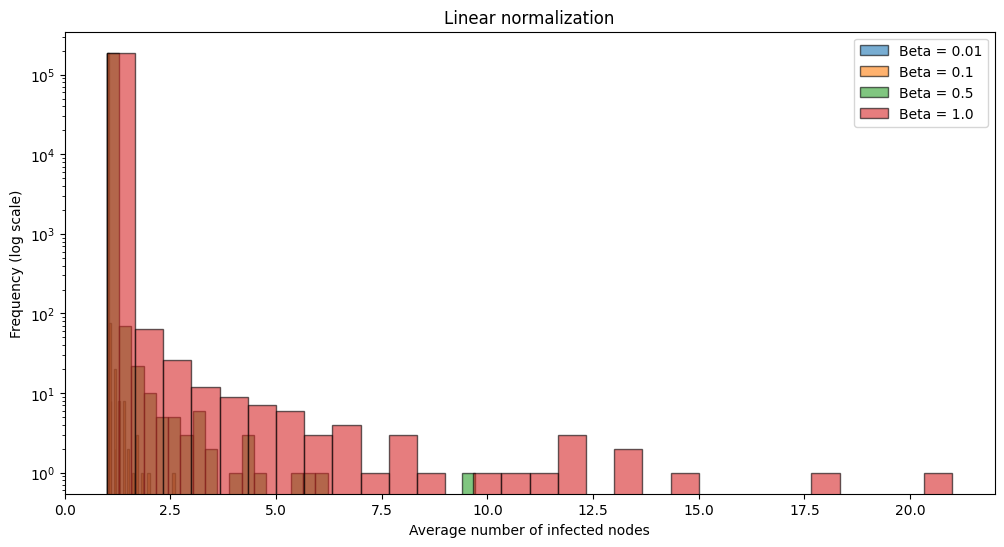

Beta = 0.01: Mean = 1.27, Std Dev = 5.25
Beta = 0.1: Mean = 16.83, Std Dev = 103.12
Beta = 0.5: Mean = 258.44, Std Dev = 834.79
Beta = 1.0: Mean = 836.39, Std Dev = 2358.95


In [43]:
hist_comparison(avg_infected_001_T, avg_infected_01_T, avg_infected_05_T, avg_infected_1_T, "Linear normalization")

In [71]:
sets = {
    'Governance only': SI_governance_users,
    'Economic only': SI_economic_users,
    'Both': SI_both_users,
    'None': SI_none_users
}

color_map = {
    'Governance only': 'blue',
    'Economic only': 'orange',
    'Both': 'green',
    'None': 'red'
}

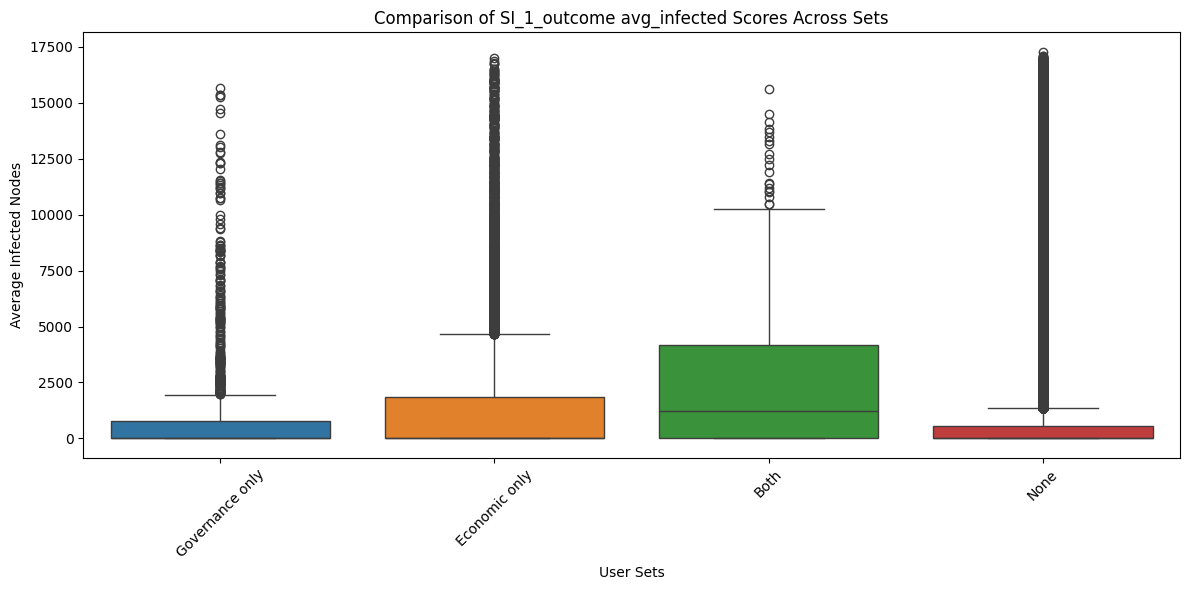

In [ ]:
set_avg_infected = {
    set_name: [entry['avg_infected'] for entry in SI_1_outcome if entry['seed'] in user_set]
    for set_name, user_set in sets.items()
}

plt.figure(figsize=(12, 6))
sns.boxplot(data=list(set_avg_infected.values()))#palette=color_map.values())
plt.xticks(ticks=range(len(set_avg_infected)), labels=set_avg_infected.keys(), rotation=45)
plt.xlabel('User Sets')
plt.ylabel('Average Infected Nodes')
plt.title('Comparison of SI_1_outcome avg_infected Scores Across Sets')
plt.tight_layout()
plt.show()

In [72]:
def get_color(node):
    for set_name, node_set in sets.items():
        if node in node_set:
            return color_map[set_name]
    return 'gray'

def plot_and_compute_correlations(si_outcome, igraph_data, feature_name):
    si_data = {entry['seed']: entry['avg_infected'] for entry in si_outcome}
    common_nodes = set(si_data.keys()) & set(igraph_data.keys())

    si_values = [si_data[node] for node in common_nodes]
    igraph_values = [igraph_data[node] for node in common_nodes]
    colors = [get_color(node) for node in common_nodes]

    plt.figure(figsize=(10, 6))
    plt.scatter(igraph_values, si_values, c=colors, alpha=0.4)
    plt.xlabel(f'{feature_name} (igraph)')
    plt.ylabel('Average infected (SI)')
    plt.title(f'Scatterplot of {feature_name} vs. average infected')
    plt.show()

    spearman_corr, _ = spearmanr(igraph_values, si_values)
    kendall_corr, _ = kendalltau(igraph_values, si_values)

    print(f"Spearman correlation: {spearman_corr:.4f}")
    print(f"Kendall correlation: {kendall_corr:.4f}")

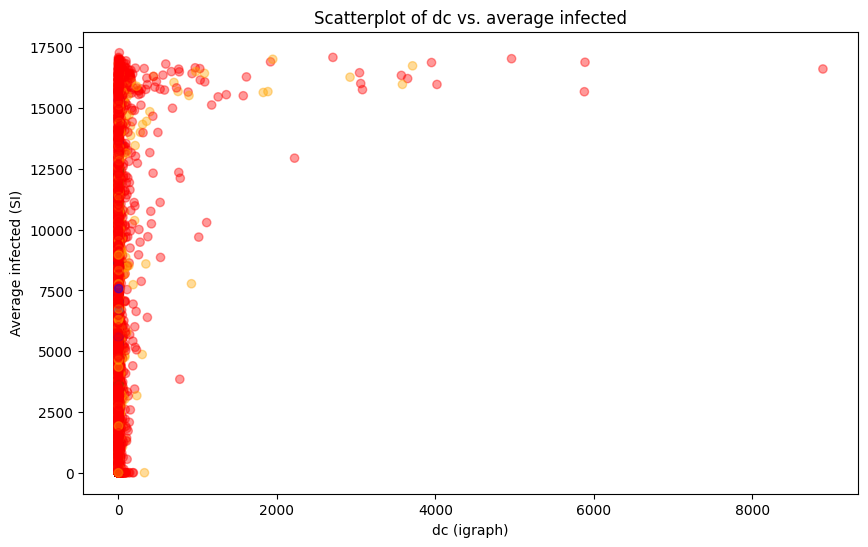

Spearman correlation: 0.1714
Kendall correlation: 0.1467


In [73]:
plot_and_compute_correlations(SI_1_outcome, aave_igraph_in_dc, 'dc')

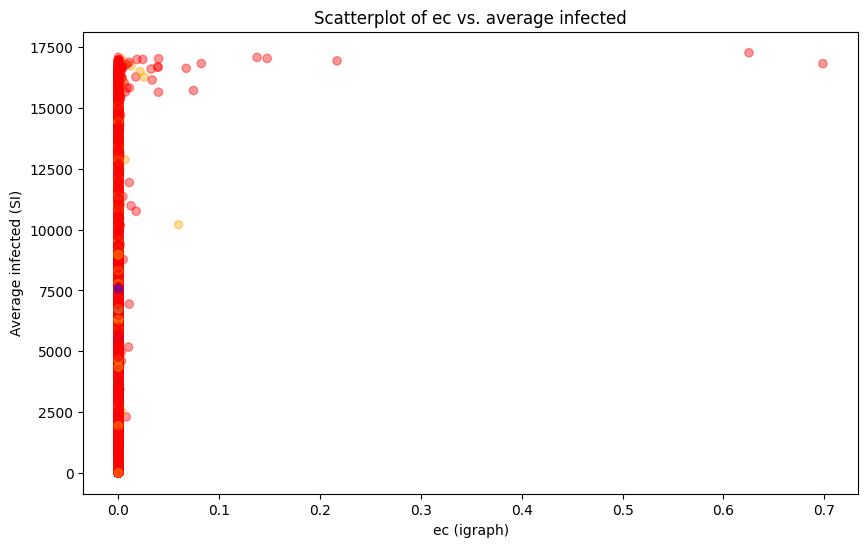

Spearman correlation: 0.2205
Kendall correlation: 0.1670


In [74]:
plot_and_compute_correlations(SI_1_outcome, aave_igraph_ec, 'ec')

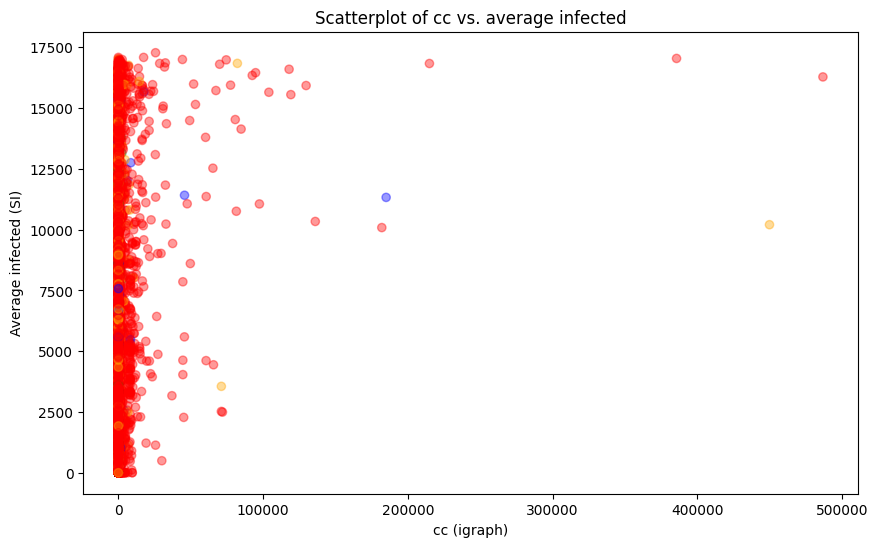

Spearman correlation: 0.5594
Kendall correlation: 0.4624


In [75]:
plot_and_compute_correlations(SI_1_outcome, aave_igraph_cc, 'cc')

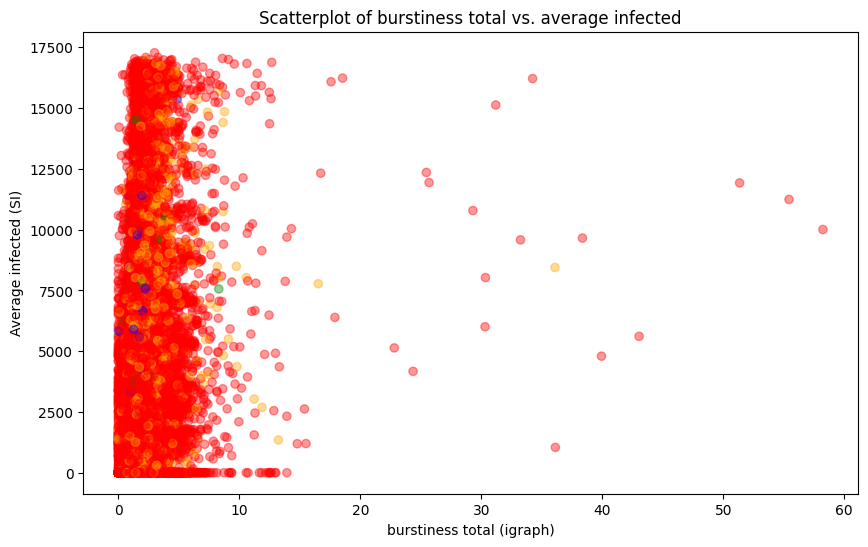

Spearman correlation: 0.2847
Kendall correlation: 0.2006


In [76]:
plot_and_compute_correlations(SI_1_outcome, aave_burstiness_total, 'burstiness total')

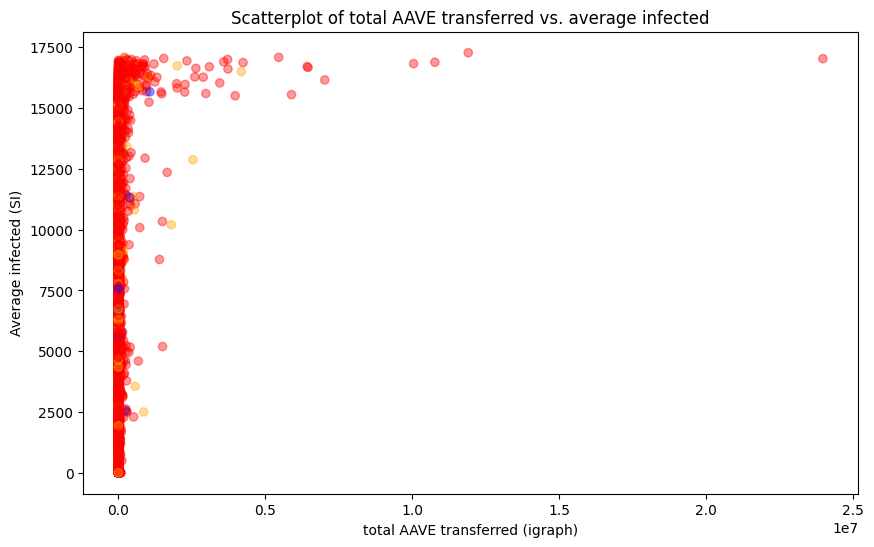

Spearman correlation: 0.6911
Kendall correlation: 0.5388


In [77]:
plot_and_compute_correlations(SI_1_outcome, total_AAVE_transferred_mapping, 'total AAVE transferred')

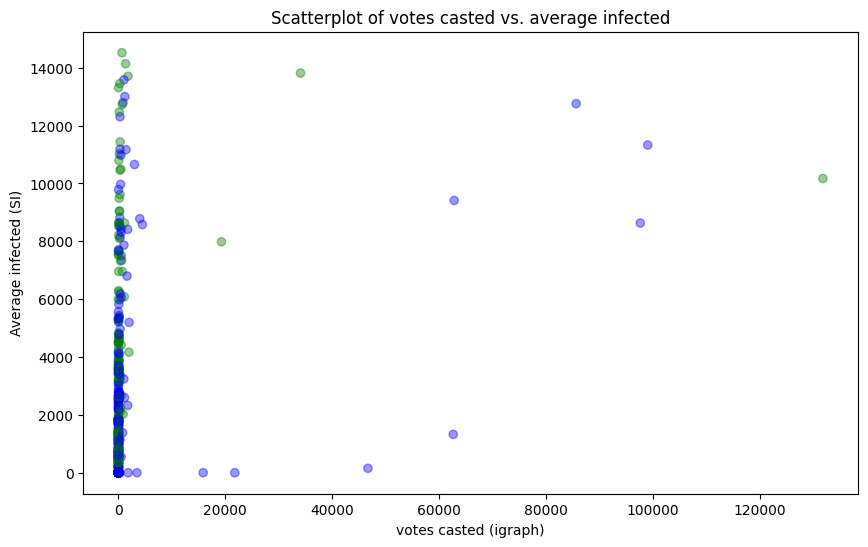

Spearman correlation: 0.6961
Kendall correlation: 0.5642


In [78]:
plot_and_compute_correlations(SI_1_outcome, average_vote_weights_mapping, 'votes casted')

In [37]:
def plot_infections_with_beta(data1, data2, data3, data4, normalization):
    betas = [0.01, 0.1, 0.5, 1.0]
    avg_infected_lists = [data1, data2, data3, data4]

    avg_infected_means = [np.mean(avg_list) for avg_list in avg_infected_lists]
    avg_infected_max = [np.max(avg_list) for avg_list in avg_infected_lists]
    
    plt.figure(figsize=(10, 6))
    plt.plot(betas, avg_infected_means, marker='o', label='Average Infected Nodes')
    plt.plot(betas, avg_infected_max, marker='s', label='Maximum Infected Nodes')
    plt.xlabel('Beta')
    plt.ylabel('Number of Infected Nodes')
    plt.title(normalization)
    plt.legend()
    plt.grid()
    plt.show()

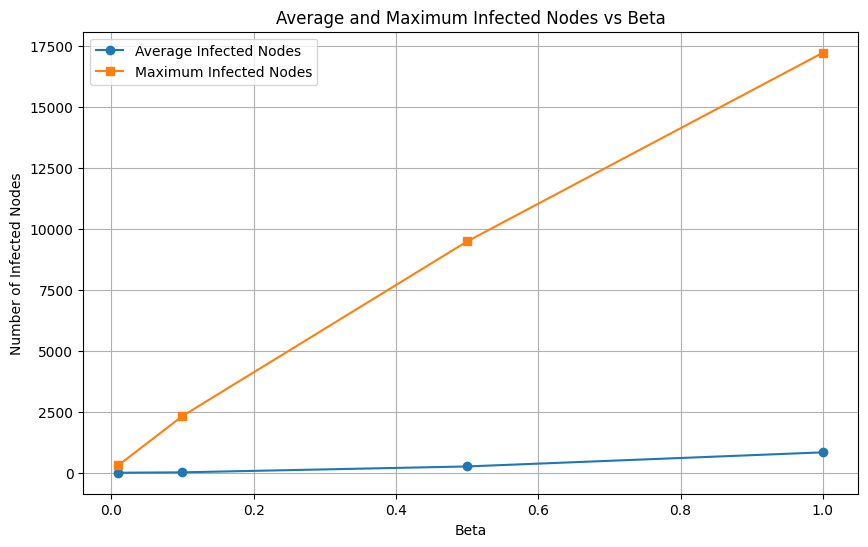

In [33]:
plot_infections_with_beta(avg_infected_001, avg_infected_01, avg_infected_05, avg_infected_1, "Log normalization")

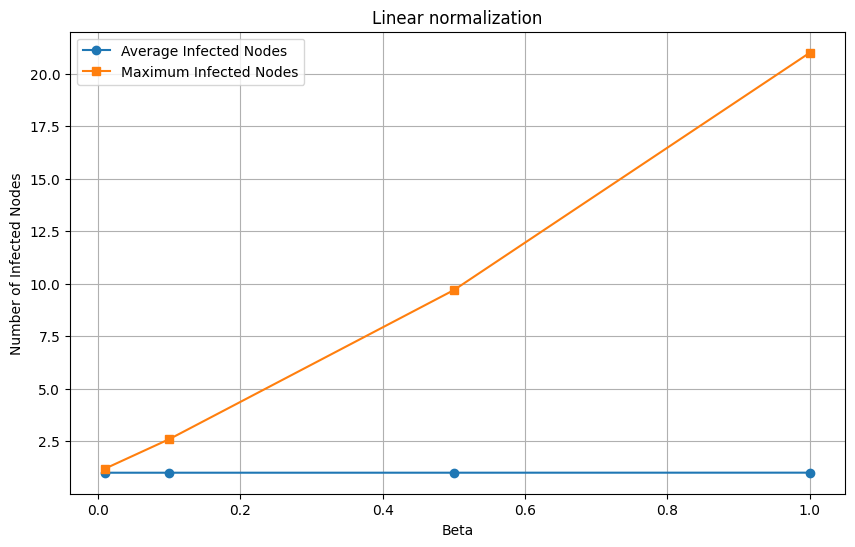

In [38]:
plot_infections_with_beta(avg_infected_001_T, avg_infected_01_T, avg_infected_05_T, avg_infected_1_T, "Linear normalization")

### Multilayer SI model

In [9]:
G_1 = copy.deepcopy(G_aave_complete)
G_2 = copy.deepcopy(G_aWETH_complete)

G_1 = normalize_weights(G_1)
G_2 = normalize_weights(G_2)

In [10]:
G_1_log = copy.deepcopy(G_aave_complete)
G_2_log = copy.deepcopy(G_aWETH_complete)

G_1_log = log_normalize_weights(G_1_log)
G_2_log = log_normalize_weights(G_2_log)

In [11]:
G_SI_combined = nx.MultiDiGraph()

for u, v, data in G_1.edges(data=True):
    G_SI_combined.add_edge((u, "gov"), (v, "gov"), **data)
    
for u, v, data in G_2.edges(data=True):
    G_SI_combined.add_edge((u, "fin"), (v, "fin"), **data)

users_in_both = set(G_1.nodes()).intersection(set(G_2.nodes()))

for user in users_in_both:
    G_SI_combined.add_edge((user, "gov"), (user, "fin"), layer_bridge=True)
    G_SI_combined.add_edge((user, "fin"), (user, "gov"), layer_bridge=True)

In [12]:
G_SI_log = nx.MultiDiGraph()

for u, v, data in G_1_log.edges(data=True):
    G_SI_log.add_edge((u, "gov"), (v, "gov"), **data)
    
for u, v, data in G_2_log.edges(data=True):
    G_SI_log.add_edge((u, "fin"), (v, "fin"), **data)

users_in_both = set(G_1_log.nodes()).intersection(set(G_2_log.nodes()))

for user in users_in_both:
    G_SI_log.add_edge((user, "gov"), (user, "fin"), layer_bridge=True)
    G_SI_log.add_edge((user, "fin"), (user, "gov"), layer_bridge=True)

In [13]:
def run_si_multilayer_simulation(G, seed_nodes, p_inter=0.2, weight_attr='norm_weight', timestamp_attr='timestamp', max_time=None):
    # infection_info = {node: {"time": 1696118400, "layer": node[1]} for node in seed_nodes}
    infection_info = {node: 1696118400 for node in seed_nodes}
    visited_interlayer = set()

    queue = []

    for u in seed_nodes:
        for _, v, data in G.out_edges(u, data=True):
            if data.get('layer_bridge'):
                continue
            
            t_edge = data[timestamp_attr]
            
            if max_time is None or t_edge <= max_time:
                heapq.heappush(queue, (t_edge, u, v, False))
                
        for _, v, data in G.out_edges(u, data=True):
            if data.get('layer_bridge') and v not in infection_info:
                    heapq.heappush(queue, (1696118400, u, v, True))

    while queue:
        t, u, v, is_inter = heapq.heappop(queue)
        
        if v in infection_info:
            continue

        if infection_info.get(u, float('inf')) > t:
            continue

        if is_inter:
            if v in visited_interlayer:
                continue

            if random.random() <= p_inter:
                infection_info[v] = t
                visited_interlayer.add(v)

                for _, w, data in G.out_edges(v, data=True):
                    if data.get('layer_bridge'):
                        continue
                    
                    t_edge = data[timestamp_attr]
                    
                    if max_time is not None and t_edge > max_time:
                        continue
                    
                    heapq.heappush(queue, (t_edge, v, w, False))

        else:
            # Use the edge with the earliest timestamp (choose the first if multiple)
            edge_data = G.get_edge_data(u, v)
            if not edge_data:
                continue

            p = edge_data[0].get(weight_attr, 0)
            if random.random() <= p:
                infection_info[v] = t

                # Immediately try inter-layer infection
                for _, cross_v, data in G.out_edges(v, data=True):
                    if data.get('layer_bridge') and cross_v not in infection_info:
                        heapq.heappush(queue, (t, v, cross_v, True))

                # Schedule intra-layer infections
                for _, w, data in G.out_edges(v, data=True):
                    if data.get('layer_bridge'):
                        continue
                    
                    t_edge = data[timestamp_attr]
                    
                    if max_time is not None and t_edge > max_time:
                        continue
                    
                    heapq.heappush(queue, (t_edge, v, w, False))

    return infection_info

In [20]:
# seed_nodes = random.sample([n for n in G_SI_combined.nodes if n[1] == "gov"], 100)
seed_nodes = [(node['seed'], "gov") for node in top_spreaders_AAVE[:100]]
# seed_nodes = [(node, "gov") for node in G_1.nodes]
# seed_nodes = [("0x6980a47bee930a4584b09ee79ebe46484fbdbdd0", "gov")] #("0x28c6c06298d514db089934071355e5743bf21d60", "gov")]

# result = run_si_multilayer_simulation(G_SI_combined, seed_nodes, p_inter=0.5)
result = run_si_multilayer_simulation(G_SI_log, seed_nodes, p_inter=0.5)

len(result)

32015

#### Results

Text(0, 0.5, 'New infections')

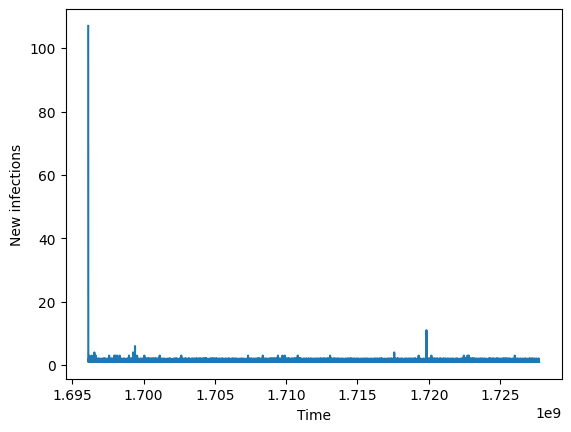

In [21]:
times = list(result.values())
counts = Counter(times)
xs = sorted(counts)
ys = [counts[x] for x in xs]
plt.plot(xs, ys)
plt.xlabel("Time")
plt.ylabel("New infections")

In [41]:
layer_counts = defaultdict(int)
for node in result:
    layer = node[1]
    layer_counts[layer] += 1
print(layer_counts)

defaultdict(<class 'int'>, {'gov': 18249, 'fin': 13766})


In [26]:
def prepare_infection_df(infection_times):
    records = []
    for (user, layer), t in infection_times.items():
        records.append({"user": user, "layer": layer, "timestamp": t})
    return pd.DataFrame(records)

df_infections = prepare_infection_df(result)


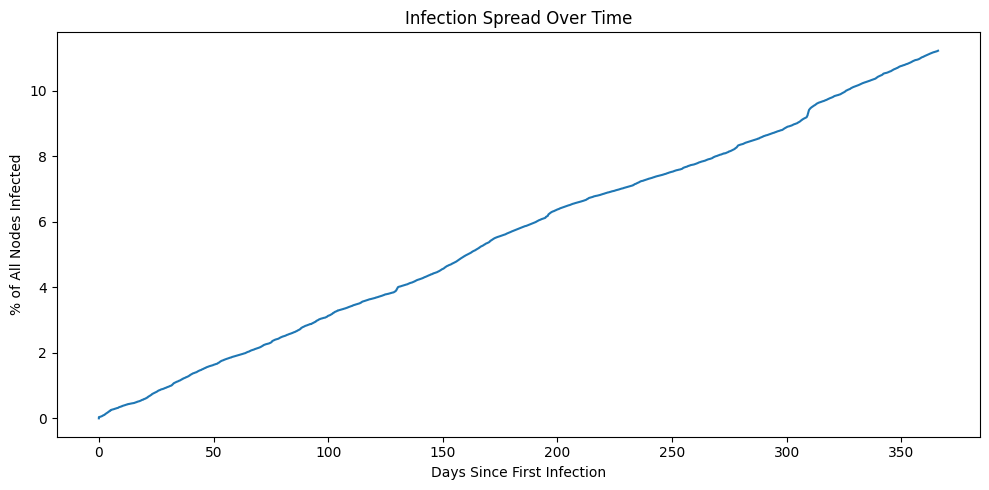

In [38]:
def plot_infection_curve(df, total_nodes):
    df_sorted = df.sort_values("timestamp")
    t0 = df_sorted["timestamp"].min()
    df_sorted["days"] = (df_sorted["timestamp"] - t0) / 86400
    df_sorted["cumulative"] = range(1, len(df_sorted)+1)

    plt.figure(figsize=(10, 5))
    plt.plot(df_sorted["days"], df_sorted["cumulative"] / total_nodes * 100, label="Total")

    plt.xlabel("Days Since First Infection")
    plt.ylabel("% of All Nodes Infected")
    plt.title("Infection Spread Over Time")
    # plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_infection_curve(df_infections, total_nodes=G_SI_log.number_of_nodes())

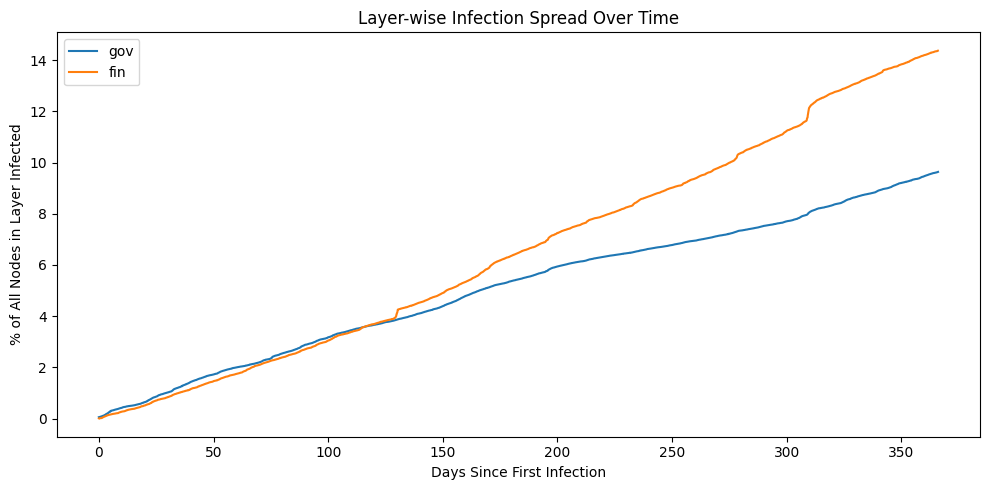

In [40]:
def plot_layerwise_infection(df, total_node_dict):
    df = df.sort_values("timestamp")
    t0 = df["timestamp"].min()
    df["days"] = (df["timestamp"] - t0) / 86400

    df["count"] = 1
    df_grouped = df.groupby(["days", "layer"]).count().reset_index()
    df_grouped["cumulative"] = df_grouped.groupby("layer")["count"].cumsum()

    plt.figure(figsize=(10, 5))
    for layer in df["layer"].unique():
        subset = df_grouped[df_grouped["layer"] == layer]
        total_layer_nodes = total_node_dict.get(layer, 1)  # avoid division by 0
        plt.plot(subset["days"], subset["cumulative"] / total_layer_nodes * 100, label=layer)

    plt.xlabel("Days Since First Infection")
    plt.ylabel("% of All Nodes in Layer Infected")
    plt.title("Layer-wise Infection Spread Over Time")
    plt.legend()
    # plt.grid(True)
    plt.tight_layout()
    plt.show()

total_node_dict = {
    "gov": len([n for n in G_SI_log.nodes if n[1] == "gov"]),
    "fin": len([n for n in G_SI_log.nodes if n[1] == "fin"]),
}

plot_layerwise_infection(df_infections, total_node_dict)

In [29]:
def analyze_layer_transfers(df):
    # Keep only users who appear in both layers
    cross_users = df.groupby("user").layer.nunique()
    both_layer_users = cross_users[cross_users > 1].index

    transfer_data = df[df["user"].isin(both_layer_users)].sort_values("timestamp")

    records = []
    for user in both_layer_users:
        user_df = transfer_data[transfer_data["user"] == user]
        if len(user_df) == 2:
            row = user_df.sort_values("timestamp")
            source, target = row["layer"].values
            records.append((source, target))

    return pd.Series(records).value_counts()

print("Layer-to-layer transitions:")
print(analyze_layer_transfers(df_infections))

Layer-to-layer transitions:
(gov, fin)    1028
(fin, gov)     952
Name: count, dtype: int64


In [30]:
def get_bridge_users(df):
    bridge_users = df.groupby("user").layer.nunique()
    return bridge_users[bridge_users > 1].index.tolist()

bridge_users = get_bridge_users(df_infections)
print("Number of bridge users infected in both layers:", len(bridge_users))

Number of bridge users infected in both layers: 1980


## Temporal Random Walk

In [ ]:
def eta_minus_ranking(timestamps):
    """
    η− : newer → larger value, then normalised 0‑1
    """
    sorted_ts = sorted(timestamps, reverse=True)
    rank_map   = {ts: idx + 1 for idx, ts in enumerate(sorted_ts)}
    max_rank   = len(timestamps)
    return [(max_rank - rank_map[ts] + 1) / max_rank for ts in timestamps]

def eta_plus_linear(weights, eps=1e-9):
    """
    η+ : linear but attenuated (√) so small‑weight edges still get probability.
    """
    max_w = max(weights)# + eps
    return [math.sqrt(w / max_w) for w in weights]

In [ ]:
def temporal_random_walk_multilayer(G, start_node, steps, p_switch=0.2, alpha=0.5, weight_attr='weight', timestamp_attr='timestamp'):
    current_node = start_node
    walk = [current_node]

    for _ in range(steps):
        neighbors = list(G.successors(current_node))
        if not neighbors:
            break

        # Separate inter-layer and intra-layer edges
        intra_layer_edges = []
        inter_layer_edges = []
        for neighbor in neighbors:
            edge_data = G.get_edge_data(current_node, neighbor)
            if edge_data:
                if edge_data[0].get('layer_bridge', False):
                    inter_layer_edges.append((neighbor, edge_data[0]))
                else:
                    intra_layer_edges.append((neighbor, edge_data[0]))

        # Decide whether to switch layers or stay in the current layer
        if inter_layer_edges and random.random() < p_switch:
            # Switch layers
            next_node = random.choice(inter_layer_edges)[0]
        elif intra_layer_edges:
            # Stay in the current layer
            # Calculate probabilities based on weights and timestamps
            weights = [edge[1][weight_attr] for edge in intra_layer_edges]
            timestamps = [edge[1][timestamp_attr] for edge in intra_layer_edges]
            
            eta_t  = eta_minus_ranking(timestamps)
            P_T    = [x / sum(eta_t) for x in eta_t]
            
            eta_w  = eta_plus_linear(weights)
            P_W    = [x / sum(eta_w) for x in eta_w]
            
            P_e = [(p_t**alpha)*(p_w**(1-alpha)) for p_t,p_w in zip(P_T,P_W)]
            P_e = [p/sum(P_e) for p in P_e]      # normalise
            next_node = random.choices(intra_layer_edges, weights=P_e)[0]
        else:
            # No valid edges to follow
            break

        walk.append(next_node)
        current_node = next_node

    return walk

## Plots

### AAVE

In [ ]:
price_data = pd.read_csv('data/AAVE_daily_USD.csv', parse_dates=['snapped_at'])

price_data['date'] = price_data['snapped_at'].dt.date

aave_df['date'] = pd.to_datetime(aave_df['timestamp'], unit='s')
aave_df['date'] = aave_df['date'].dt.date

merged_data_aave = aave_df.groupby('date').size().reset_index(name='num_entries')
merged_data_aave = aave_df.groupby('date').agg(num_entries=('value', 'count'), total_value=('value', 'sum')).reset_index()
merged_data_aave = merged_data_aave.merge(price_data[['date', 'price']], on='date', how='left')
merged_data_aave['total_traded_value'] = merged_data_aave['total_value'] * merged_data_aave['price']

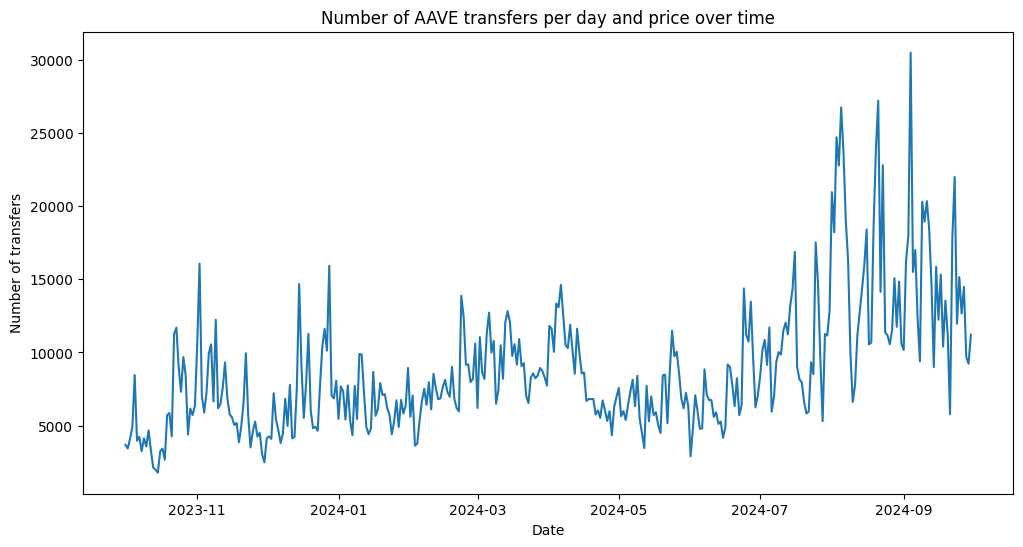

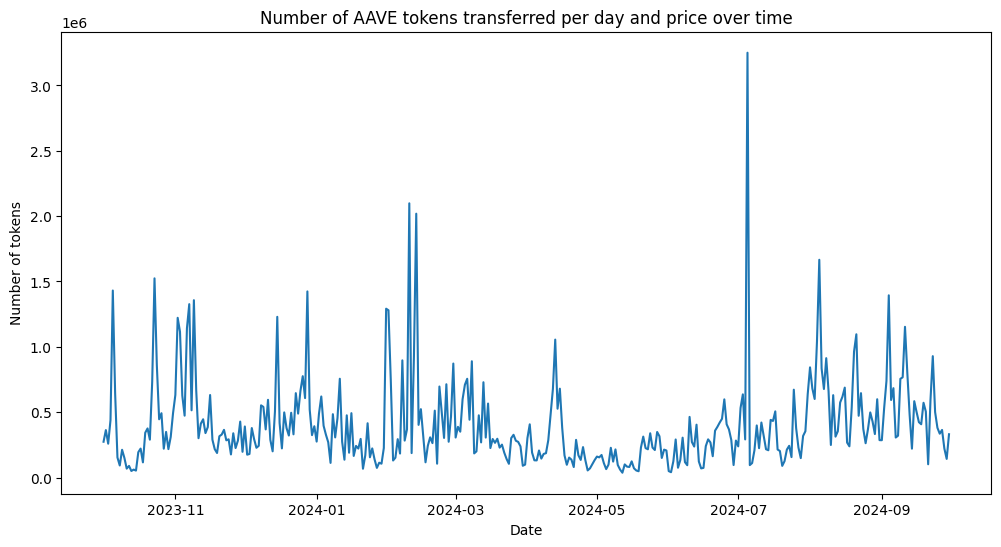

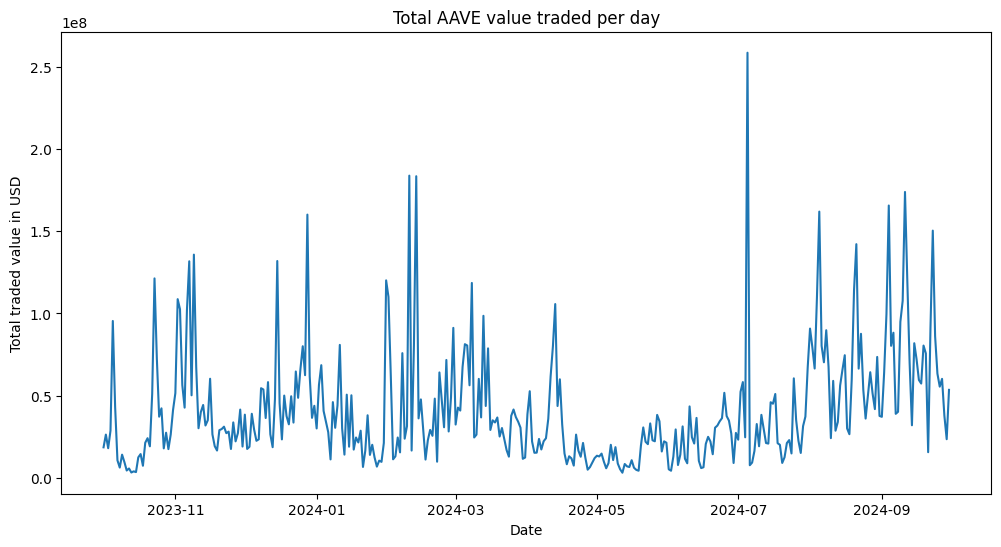

In [43]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data_aave['date'], merged_data_aave['num_entries'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of transfers')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# ax2.plot(merged_data_aave['date'], merged_data_aave['price'], color='red')
# ax2.set_ylabel('Price', color='red')
# ax2.tick_params(axis='y', labelcolor='red')

plt.title('Number of AAVE transfers per day and price over time')
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data_aave['date'], merged_data_aave['total_value'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of tokens')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# ax2.plot(merged_data_aave['date'], merged_data_aave['price'], color='red')
# ax2.set_ylabel('Price', color='red')
# ax2.tick_params(axis='y', labelcolor='red')

plt.title('Number of AAVE tokens transferred per day and price over time')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data_aave['date'], merged_data_aave['total_traded_value'])
plt.xlabel('Date')
plt.ylabel('Total traded value in USD')
plt.title('Total AAVE value traded per day')
plt.show()

In [20]:
aave_addresses = pd.concat([aave_df['from'], aave_df['to']])
aToken_addresses = pd.concat([aToken_df['from'], aToken_df['to']])

aave_transaction_counts = aave_addresses.value_counts()
aToken_transaction_counts = aToken_addresses.value_counts()

voters_set = set(vote_counts.keys())

aave_voters_transaction_counts = aave_transaction_counts[aave_transaction_counts.index.isin(voters_set)]
aave_non_voters_transaction_counts = aave_transaction_counts[~aave_transaction_counts.index.isin(voters_set)]

aWETH_voters_transaction_counts = aToken_transaction_counts[aToken_transaction_counts.index.isin(voters_set)]
aWETH_non_voters_transaction_counts = aToken_transaction_counts[~aToken_transaction_counts.index.isin(voters_set)]

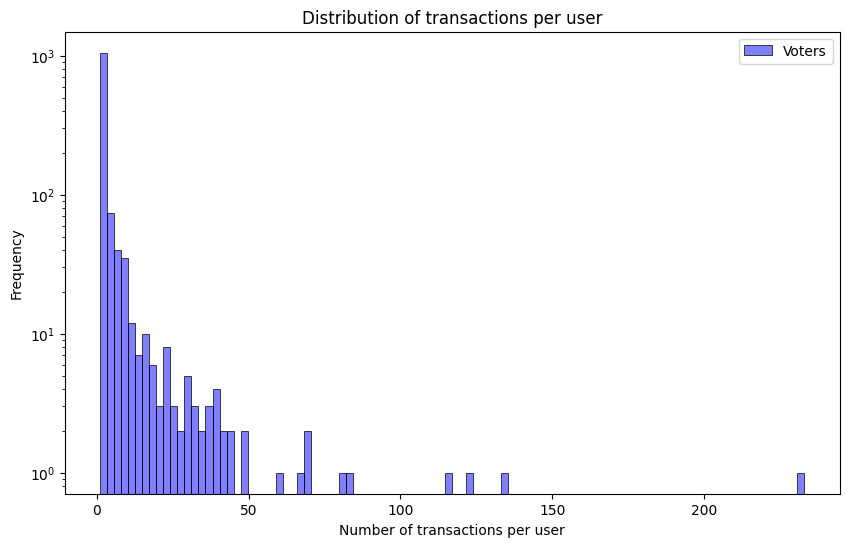

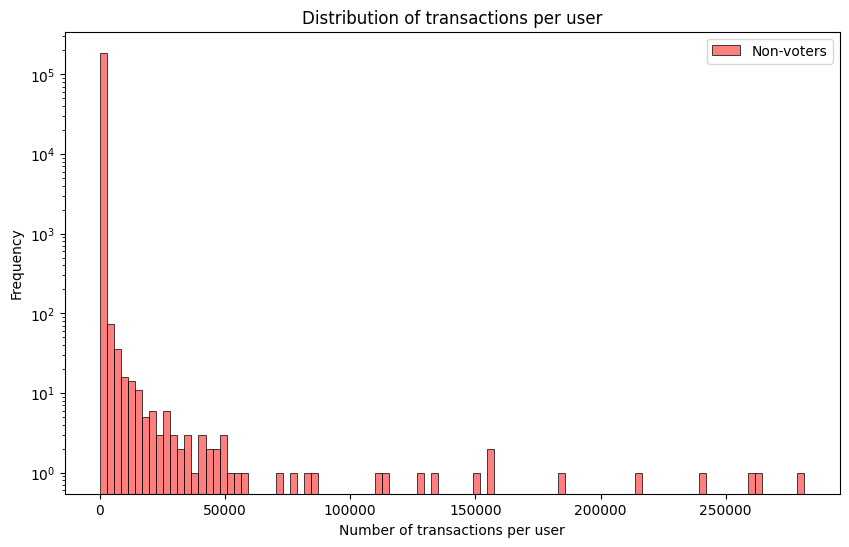

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(aave_voters_transaction_counts, bins=100, color='blue', label='Voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Number of transactions per user")
plt.ylabel("Frequency")
plt.title("Distribution of transactions per user")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(aave_non_voters_transaction_counts, bins=100, color='red', label='Non-voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Number of transactions per user")
plt.ylabel("Frequency")
plt.title("Distribution of transactions per user")
plt.legend()
plt.show()

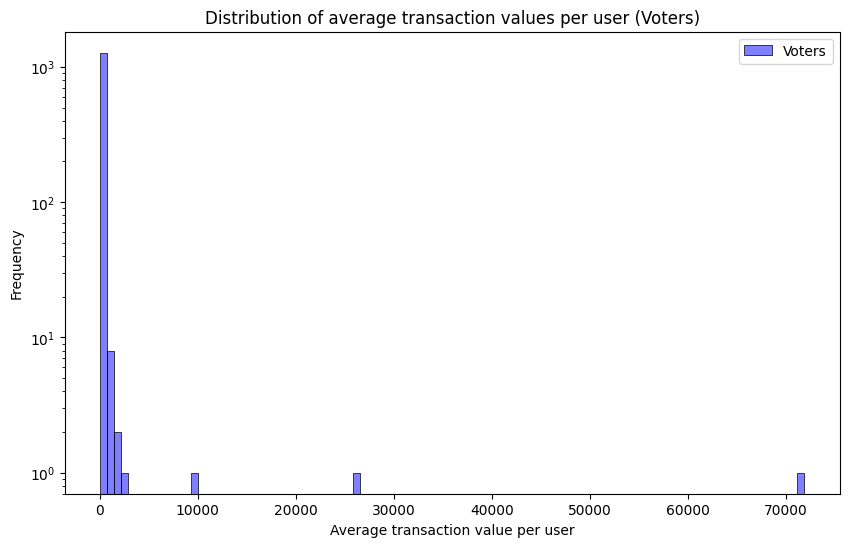

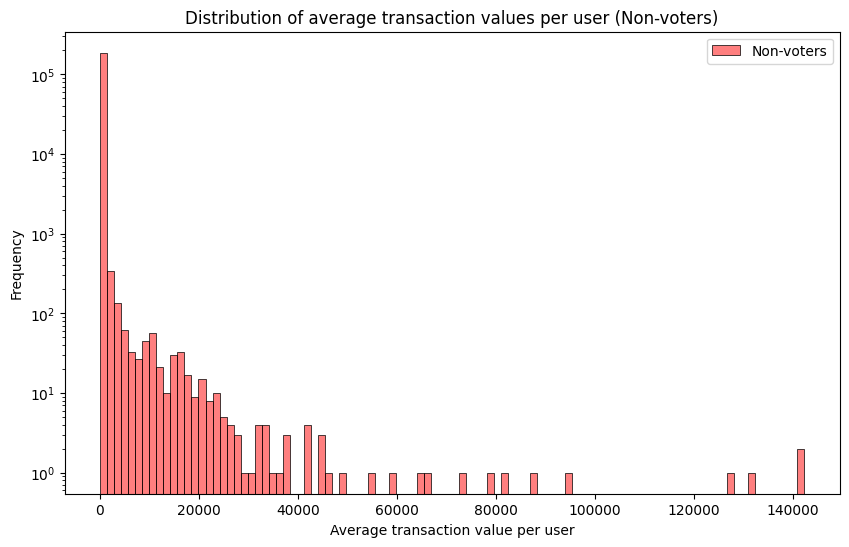

In [23]:
aave_avg_transaction_values = aave_df.groupby('from')['value'].mean().add(
    aave_df.groupby('to')['value'].mean(), fill_value=0
) / 2

aave_voters_avg_transaction_values = aave_avg_transaction_values[aave_avg_transaction_values.index.isin(voters_set)]
aave_non_voters_avg_transaction_values = aave_avg_transaction_values[~aave_avg_transaction_values.index.isin(voters_set)]

plt.figure(figsize=(10, 6))
sns.histplot(aave_voters_avg_transaction_values, bins=100, color='blue', label='Voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Average transaction value per user")
plt.ylabel("Frequency")
plt.title("Distribution of average transaction values per user (Voters)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(aave_non_voters_avg_transaction_values, bins=100, color='red', label='Non-voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Average transaction value per user")
plt.ylabel("Frequency")
plt.title("Distribution of average transaction values per user (Non-voters)")
plt.legend()
plt.show()

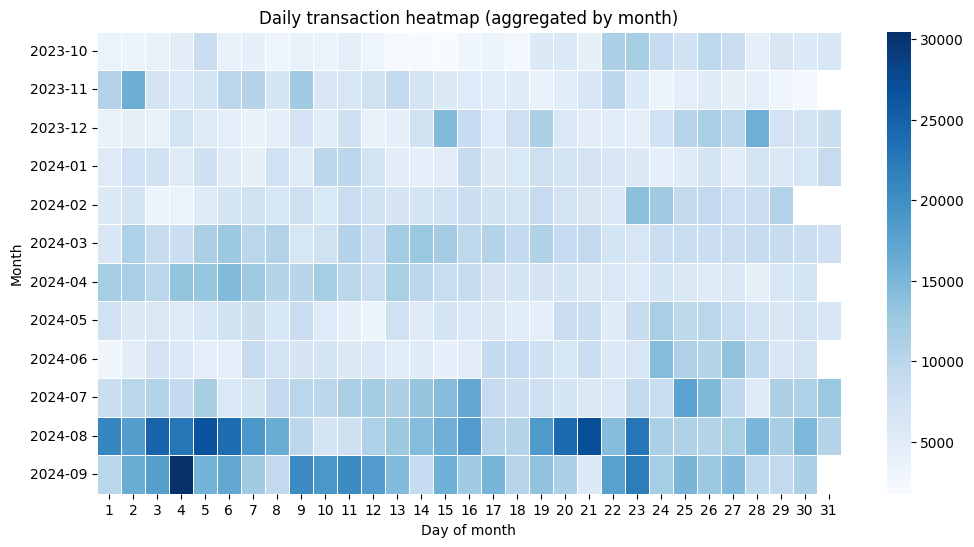

In [ ]:
daily_counts = aave_df.groupby("date").size().reset_index()
daily_counts.columns = ["date", "count"]

daily_counts["date"] = pd.to_datetime(daily_counts["date"])

daily_counts["month"] = daily_counts["date"].dt.strftime("%Y-%m")
daily_counts["day"] = daily_counts["date"].dt.day

heatmap_data = daily_counts.pivot(index="month", columns="day", values="count")

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap="Blues", linewidths=0.5)
plt.xlabel("Day of month")
plt.ylabel("Month")
plt.title("Daily transaction heatmap (aggregated by month)")
plt.show()

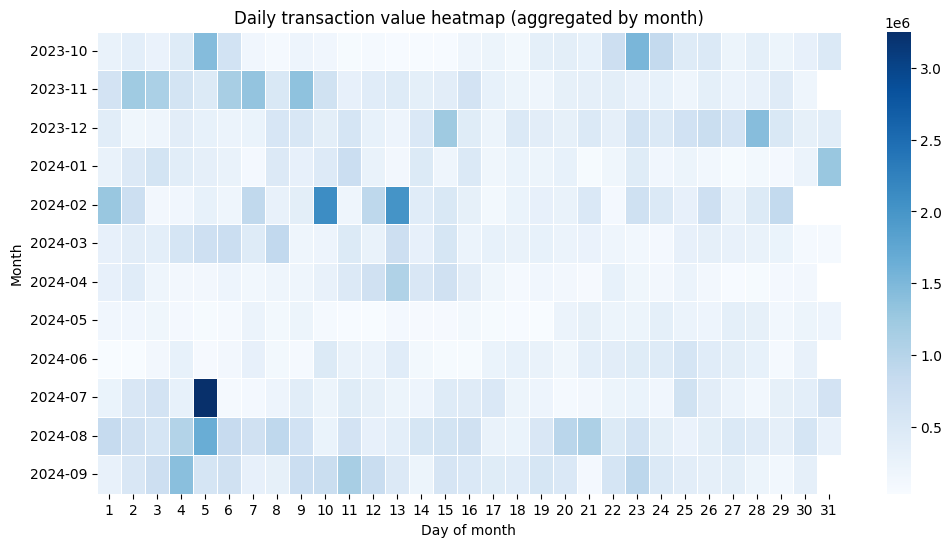

In [ ]:
daily_values = aave_df.groupby("date")["value"].sum().reset_index()
daily_values.columns = ["date", "total_value"]

daily_values["date"] = pd.to_datetime(daily_values["date"])

daily_values["month"] = daily_values["date"].dt.strftime("%Y-%m")
daily_values["day"] = daily_values["date"].dt.day

heatmap_data_values = daily_values.pivot(index="month", columns="day", values="total_value")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data_values, cmap="Blues", linewidths=0.5)
plt.xlabel("Day of month")
plt.ylabel("Month")
plt.title("Daily transaction value heatmap (aggregated by month)")
plt.show()

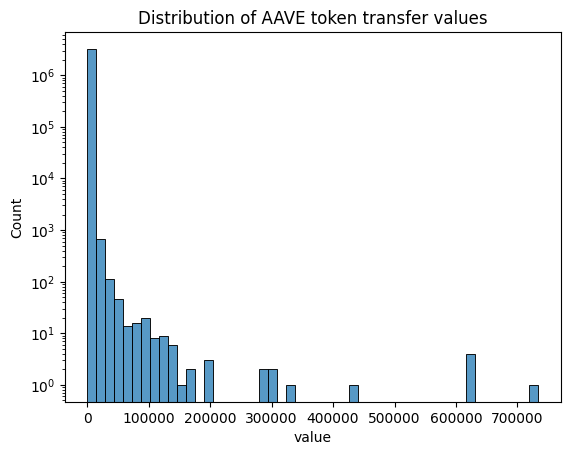

In [99]:
sns.histplot(aave_df['value'], bins=50)#, log_scale=(True, False))
plt.yscale('log')
plt.title('Distribution of AAVE token transfer values')
plt.show()

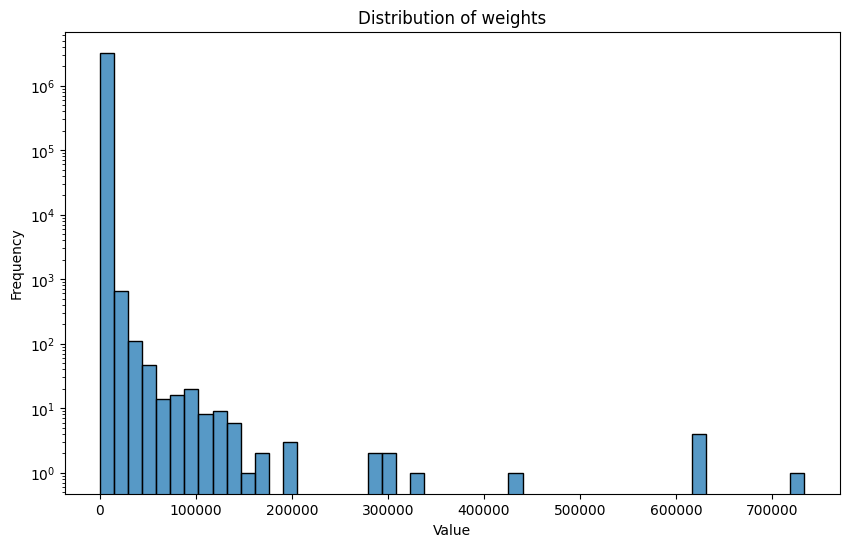

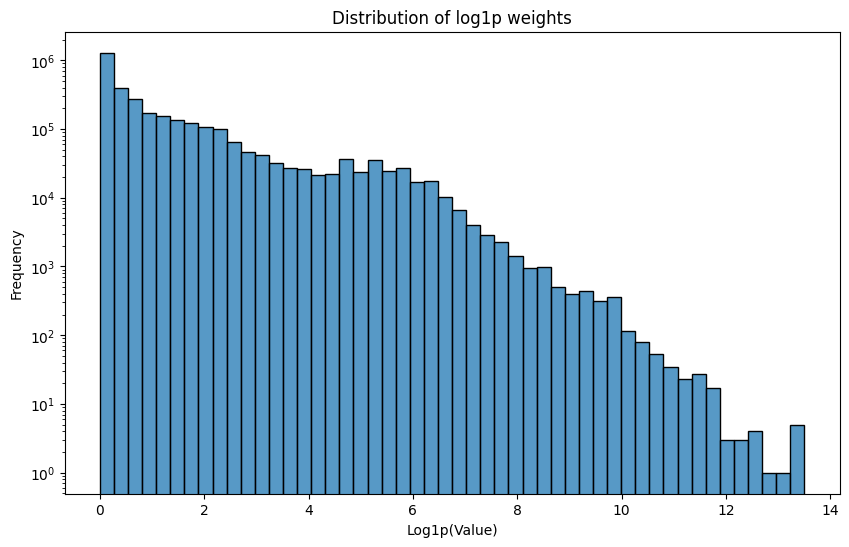

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(aave_df['value'], bins=50, edgecolor='black')
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of weights')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(aave_df['value']), bins=50)
plt.yscale('log')
plt.xlabel('Log1p(Value)')
plt.ylabel('Frequency')
plt.title('Distribution of log1p weights')
plt.show()

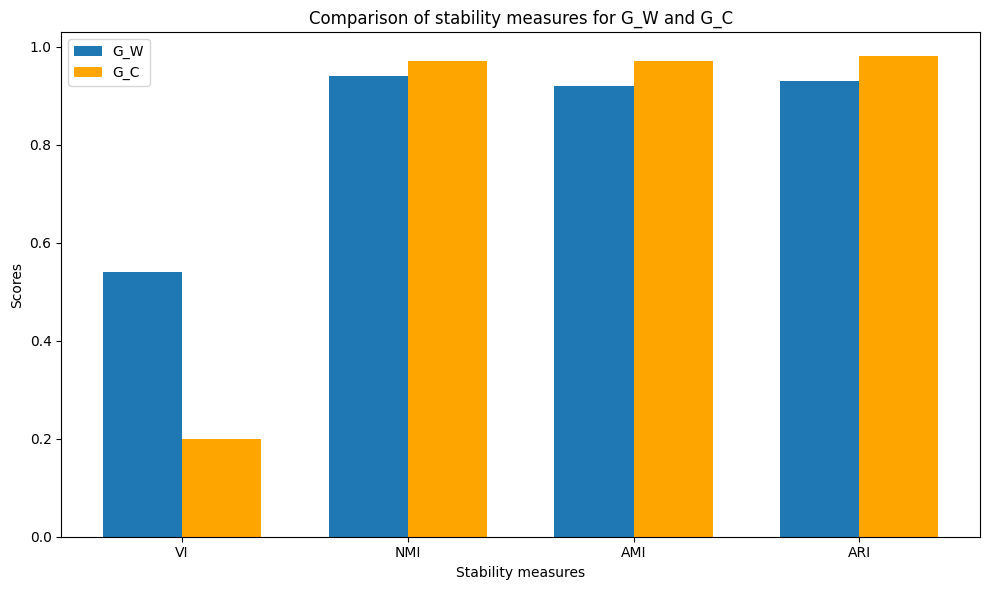

In [ ]:
stability_outcomes = {
    'G_W': {
        'VI': 0.54,
        'NMI': 0.94,
        'AMI': 0.92,
        'ARI': 0.93
    },
    'G_C': {
        'VI': 0.20,
        'NMI': 0.97,
        'AMI': 0.97,
        'ARI': 0.98
    }
}

measures = list(stability_outcomes['G_W'].keys())
scores_G_W = [stability_outcomes['G_W'][measure] for measure in measures]
scores_G_C = [stability_outcomes['G_C'][measure] for measure in measures]

x = np.arange(len(measures))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars_G_W = ax.bar(x - width/2, scores_G_W, width, label='G_W')
bars_G_C = ax.bar(x + width/2, scores_G_C, width, label='G_C', color='orange')

ax.set_xlabel('Stability measures')
ax.set_ylabel('Scores')
ax.set_title('Comparison of stability measures for G_W and G_C')
ax.set_xticks(x)
ax.set_xticklabels(measures)
ax.legend()

plt.tight_layout()
plt.show()

### aWETH

In [44]:
price_data = pd.read_csv('data/WETH_daily_USD.csv', parse_dates=['snapped_at'])

price_data['date'] = price_data['snapped_at'].dt.date

aToken_df['date'] = pd.to_datetime(aToken_df['timestamp'], unit='s')
aToken_df['date'] = aToken_df['date'].dt.date

merged_data_WETH = aToken_df.groupby('date').size().reset_index(name='num_entries')
merged_data_WETH = aToken_df.groupby('date').agg(num_entries=('value', 'count'), total_value=('value', 'sum')).reset_index()
merged_data_WETH = merged_data_WETH.merge(price_data[['date', 'price']], on='date', how='left')
merged_data_WETH['total_traded_value'] = merged_data_WETH['total_value'] * merged_data_WETH['price']

C:\Users\Sam\AppData\Local\Temp\ipykernel_3340\3857162676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aToken_df['date'] = pd.to_datetime(aToken_df['timestamp'], unit='s')
C:\Users\Sam\AppData\Local\Temp\ipykernel_3340\3857162676.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aToken_df['date'] = aToken_df['date'].dt.date


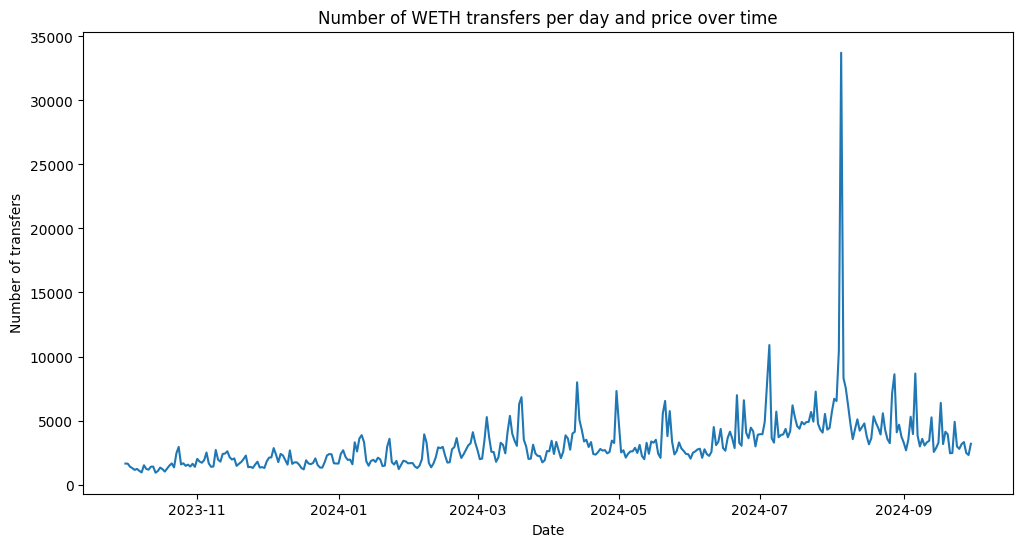

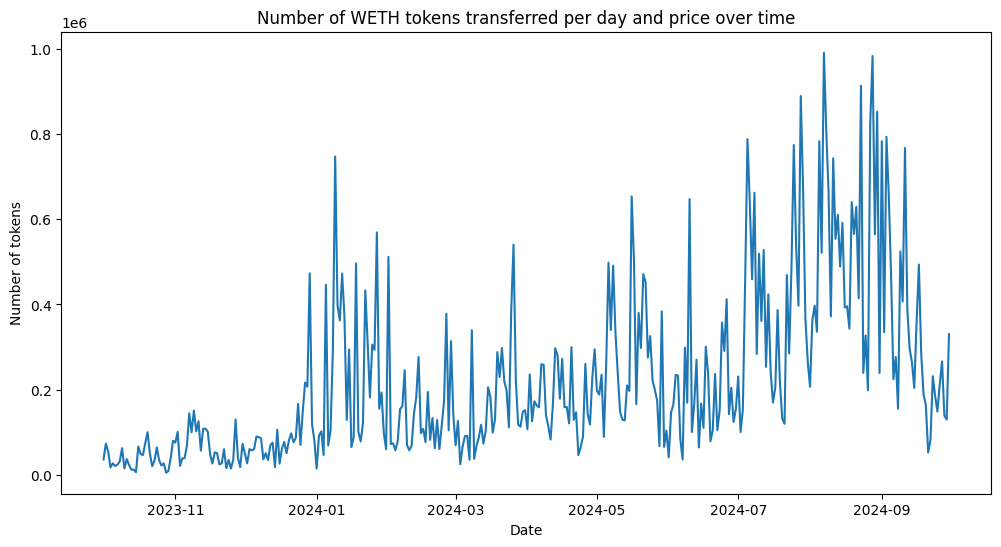

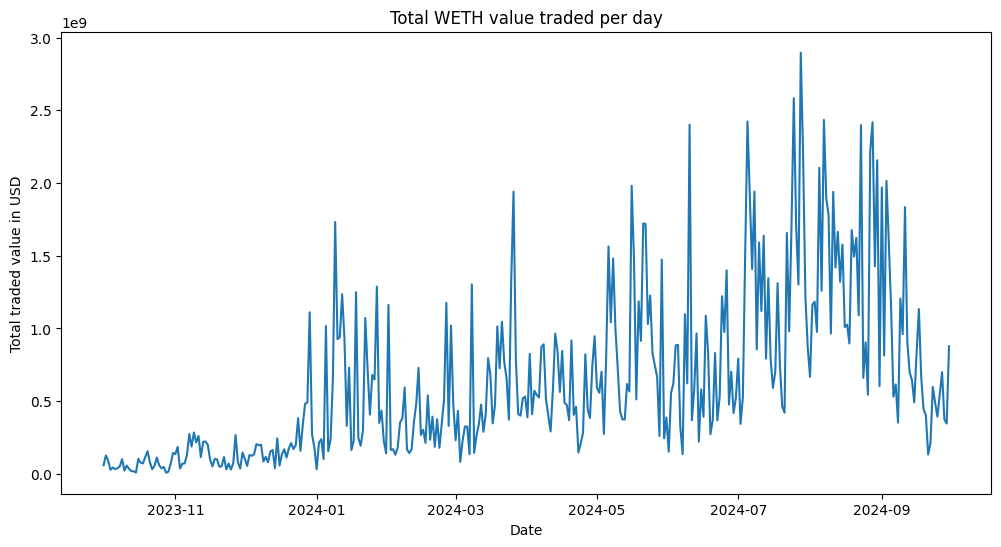

In [45]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data_WETH['date'], merged_data_WETH['num_entries'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of transfers')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# ax2.plot(merged_data_WETH['date'], merged_data_WETH['price'], color='red')
# ax2.set_ylabel('Price', color='red')
# ax2.tick_params(axis='y', labelcolor='red')

plt.title('Number of WETH transfers per day and price over time')
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data_WETH['date'], merged_data_WETH['total_value'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of tokens')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# ax2.plot(merged_data_WETH['date'], merged_data_WETH['price'], color='red')
# ax2.set_ylabel('Price', color='red')
# ax2.tick_params(axis='y', labelcolor='red')

plt.title('Number of WETH tokens transferred per day and price over time')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data_WETH['date'], merged_data_WETH['total_traded_value'])
plt.xlabel('Date')
plt.ylabel('Total traded value in USD')
plt.title('Total WETH value traded per day')
plt.show()

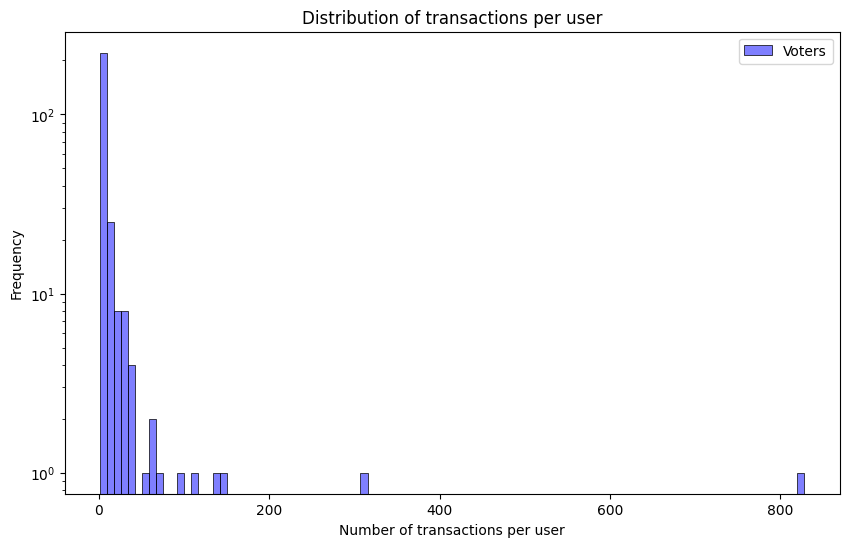

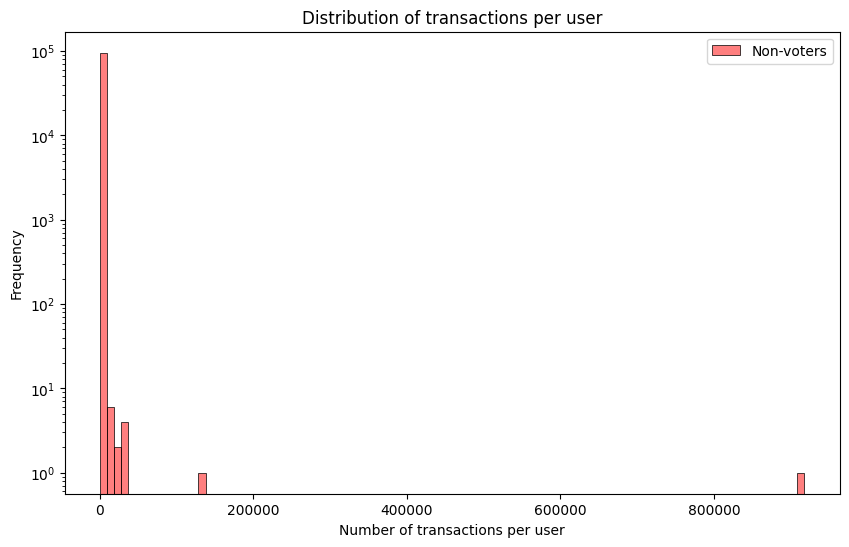

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(aWETH_voters_transaction_counts, bins=100, color='blue', label='Voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Number of transactions per user")
plt.ylabel("Frequency")
plt.title("Distribution of transactions per user")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(aWETH_non_voters_transaction_counts, bins=100, color='red', label='Non-voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Number of transactions per user")
plt.ylabel("Frequency")
plt.title("Distribution of transactions per user")
plt.legend()
plt.show()

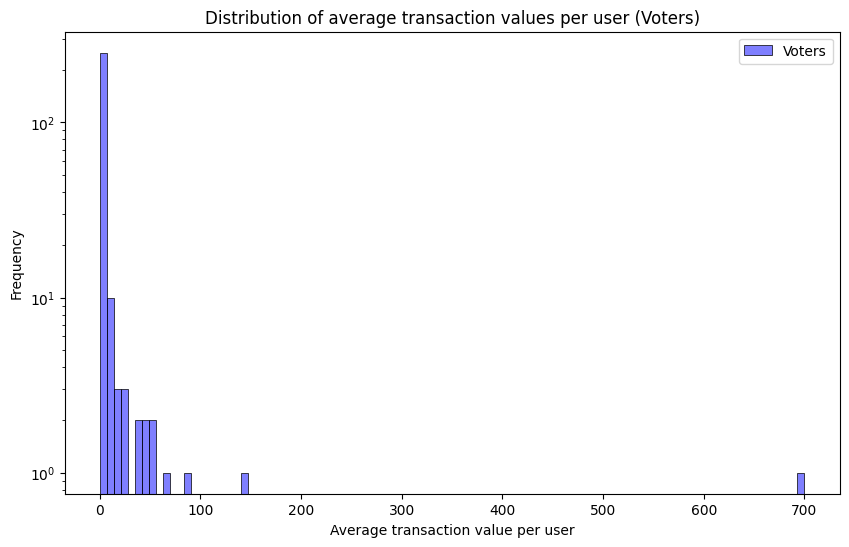

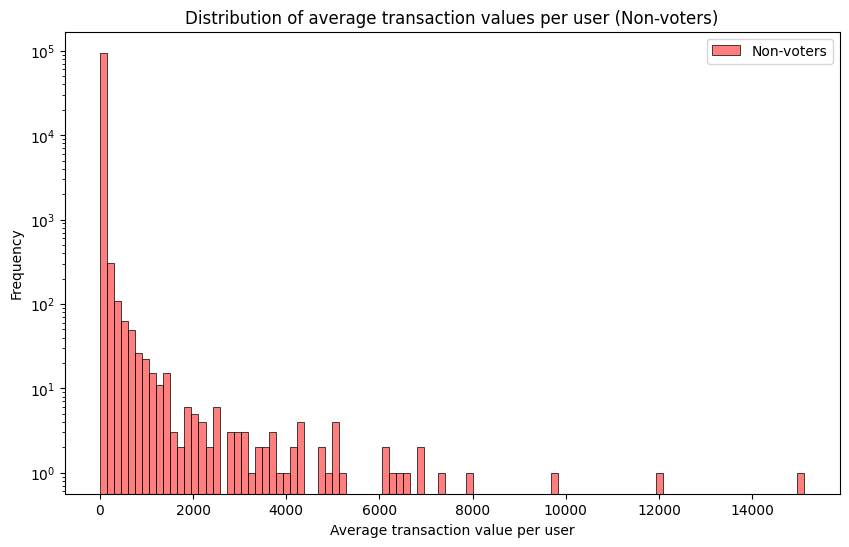

In [47]:
aWETH_avg_transaction_values = aToken_df.groupby('from')['value'].mean().add(
    aToken_df.groupby('to')['value'].mean(), fill_value=0
) / 2

aWETH_voters_avg_transaction_values = aWETH_avg_transaction_values[aWETH_avg_transaction_values.index.isin(voters_set)]
aWETH_non_voters_avg_transaction_values = aWETH_avg_transaction_values[~aWETH_avg_transaction_values.index.isin(voters_set)]

plt.figure(figsize=(10, 6))
sns.histplot(aWETH_voters_avg_transaction_values, bins=100, color='blue', label='Voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Average transaction value per user")
plt.ylabel("Frequency")
plt.title("Distribution of average transaction values per user (Voters)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(aWETH_non_voters_avg_transaction_values, bins=100, color='red', label='Non-voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Average transaction value per user")
plt.ylabel("Frequency")
plt.title("Distribution of average transaction values per user (Non-voters)")
plt.legend()
plt.show()

### Governance

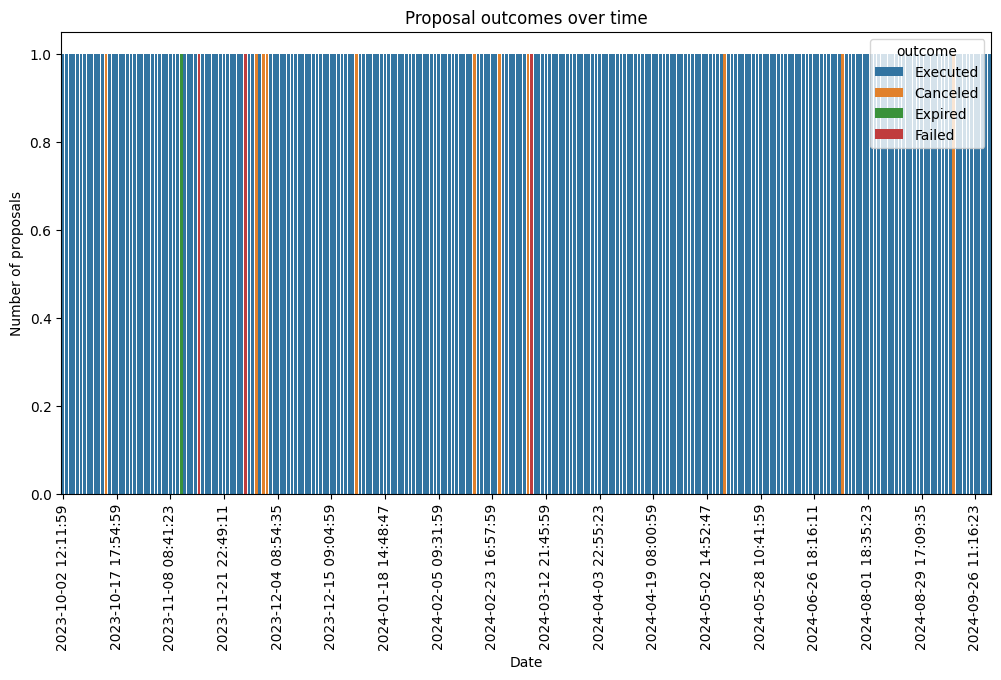

<Figure size 1200x600 with 0 Axes>

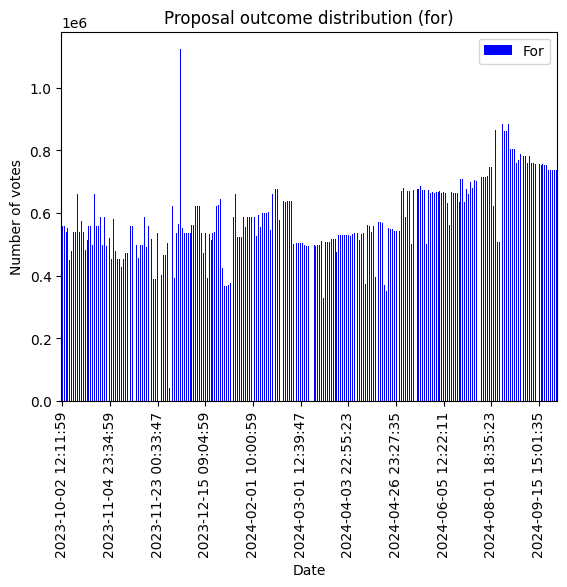

<Figure size 1200x600 with 0 Axes>

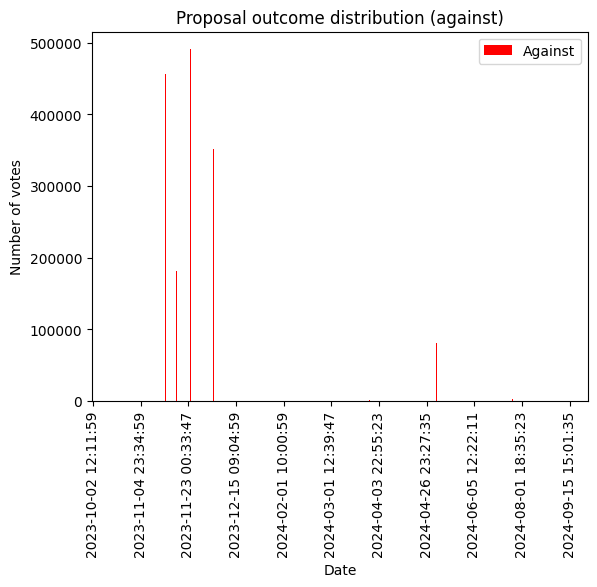

In [30]:
proposal_dates = [datetime.fromtimestamp(proposal['timestamp']) for proposal in aave_v2_proposals] + \
                 [datetime.fromtimestamp(int(proposal['transactions']['created']['timestamp'])) for proposal in aave_v3_proposals]

proposal_outcomes_df = pd.DataFrame({
    'date': proposal_dates,
    'outcome': [proposal['state'] for proposal in aave_v2_proposals] + [proposal['state'] for proposal in aave_v3_proposals]
})

proposal_outcomes_df = proposal_outcomes_df.sort_values(by='date')
# proposal_outcomes_df['date'] = proposal_outcomes_df['date'].dt.date

proposal_outcome_distribution = pd.DataFrame({
    'date': proposal_dates,
    'For': [float(proposal['currentYesVote']) for proposal in aave_v2_proposals] +
           [float(proposal['votes']['forVotes']) if proposal['votes'] else 0 for proposal in aave_v3_proposals],
    'Against': [float(proposal['currentNoVote']) for proposal in aave_v2_proposals] +
               [float(proposal['votes']['againstVotes']) if proposal['votes'] else 0 for proposal in aave_v3_proposals]
})

proposal_outcome_distribution = proposal_outcome_distribution.sort_values(by='date')
# proposal_outcome_distribution['date'] = proposal_outcome_distribution['date'].dt.date

plt.figure(figsize=(12, 6))
sns.countplot(data=proposal_outcomes_df, x='date', hue='outcome')
plt.xlabel('Date')
plt.ylabel('Number of proposals')
plt.title('Proposal outcomes over time')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(24))
plt.show()

# plt.figure(figsize=(12, 6))
# proposal_outcome_distribution.plot(kind='bar', stacked=True)
# plt.xlabel('Proposal')
# plt.ylabel('Number of votes')
# plt.title('Proposal outcome distribution')
# plt.show()

plt.figure(figsize=(12, 6))
proposal_outcome_distribution.plot(x='date', y='For', kind='bar', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of votes')
plt.title('Proposal outcome distribution (for)')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.show()

plt.figure(figsize=(12, 6))
proposal_outcome_distribution.plot(x='date', y='Against', kind='bar', color='red')
plt.xlabel('Date')
plt.ylabel('Number of votes')
plt.title('Proposal outcome distribution (against)')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.show()

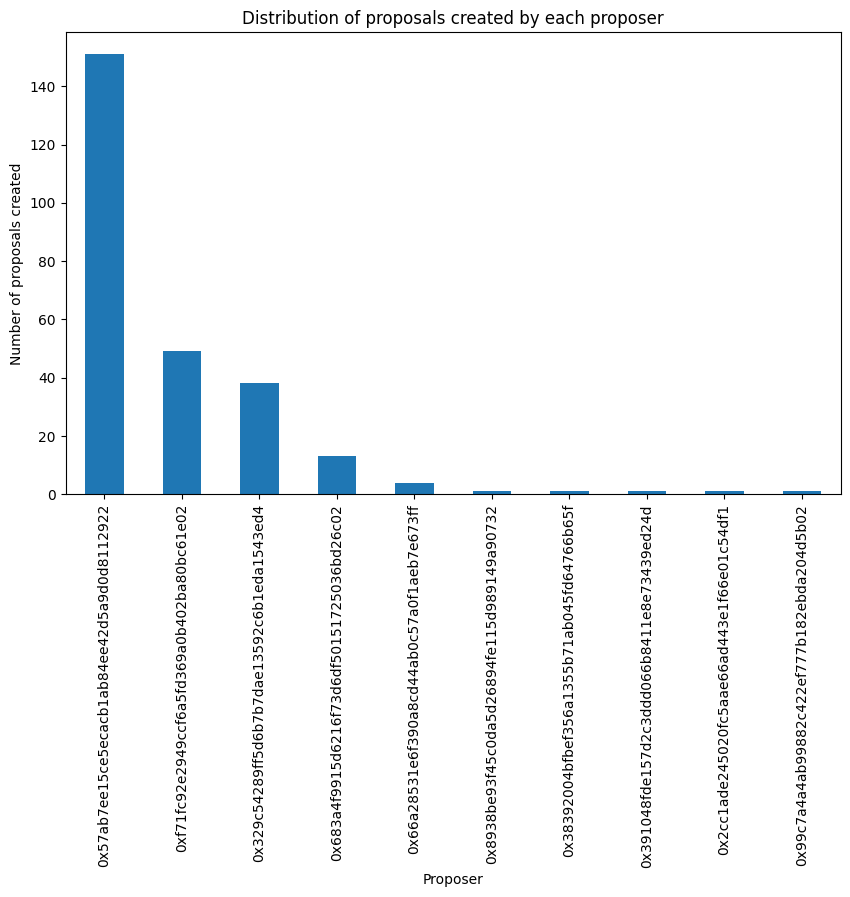

In [31]:
proposer_counts = pd.Series([proposal['user']['id'] for proposal in aave_v2_proposals] + 
                            [proposal['creator'] for proposal in aave_v3_proposals]).value_counts()

plt.figure(figsize=(10, 6))
proposer_counts.plot(kind='bar')
plt.xlabel('Proposer')
plt.ylabel('Number of proposals created')
plt.title('Distribution of proposals created by each proposer')
plt.show()

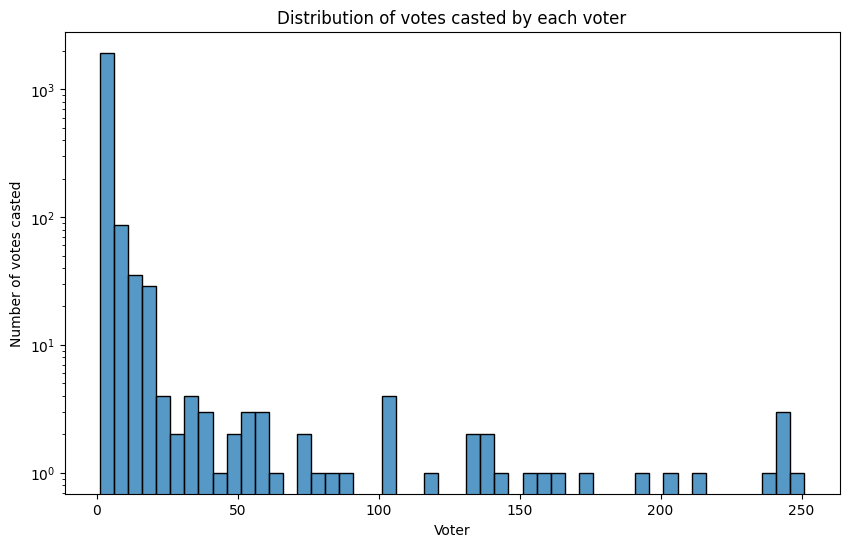

In [ ]:
voter_counts = pd.Series([vote['id'].split('-')[0] for votes in aave_v2_votes for vote in votes['votes']] + 
                         [vote['voter'].lower() for votes in aave_v3_votes for vote in votes['votes']]).value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(voter_counts, bins=50)
plt.yscale('log')
plt.xlabel('Voter')
plt.ylabel('Number of votes casted')
plt.title('Distribution of votes casted by each voter')
plt.show()

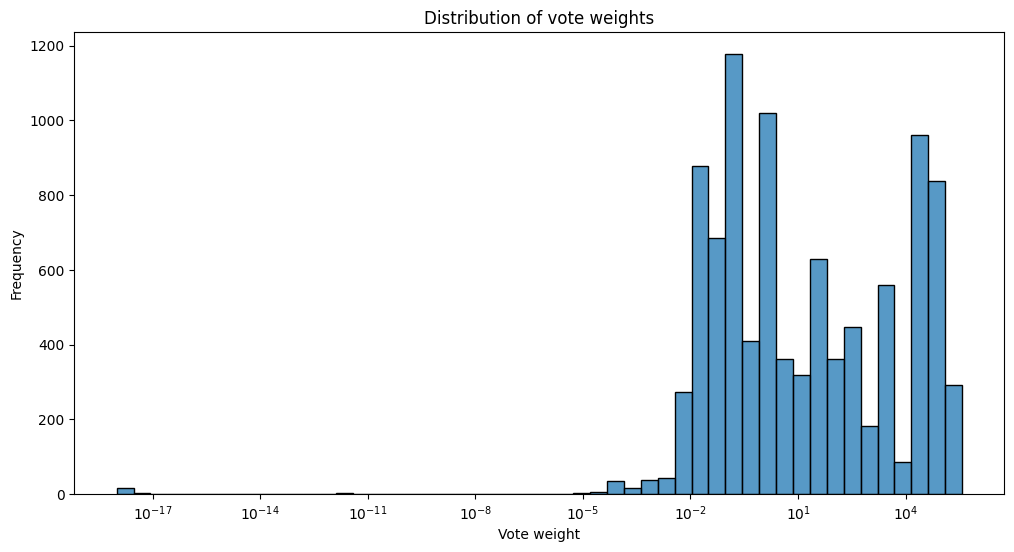

In [ ]:
vote_weights = []

for votes in aave_v2_votes:
    for vote in votes['votes']:
        vote_weights.append(float(vote['weight']))

for votes in aave_v3_votes:
    for vote in votes['votes']:
        vote_weights.append(float(vote['weight']))

plt.figure(figsize=(12, 6))
sns.histplot(vote_weights, bins=50, log_scale=(True, False))
plt.xlabel('Vote weight')
plt.ylabel('Frequency')
plt.title('Distribution of vote weights')
plt.show()

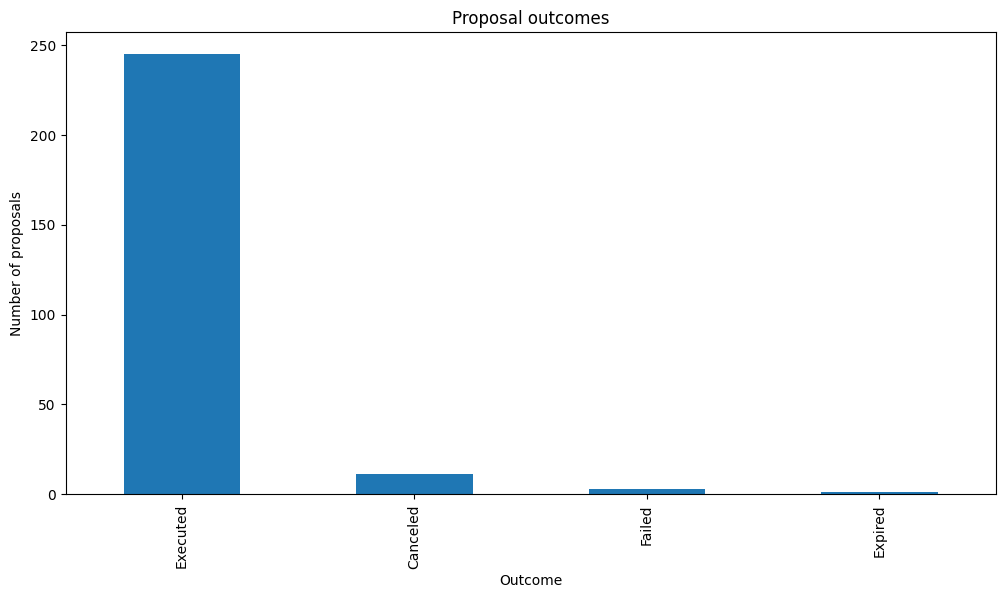

In [34]:
proposal_outcomes = pd.Series([proposal['state'] for proposal in aave_v2_proposals + aave_v3_proposals])

plt.figure(figsize=(12, 6))
proposal_outcomes.value_counts().plot(kind='bar')
plt.xlabel('Outcome')
plt.ylabel('Number of proposals')
plt.title('Proposal outcomes')
plt.show()

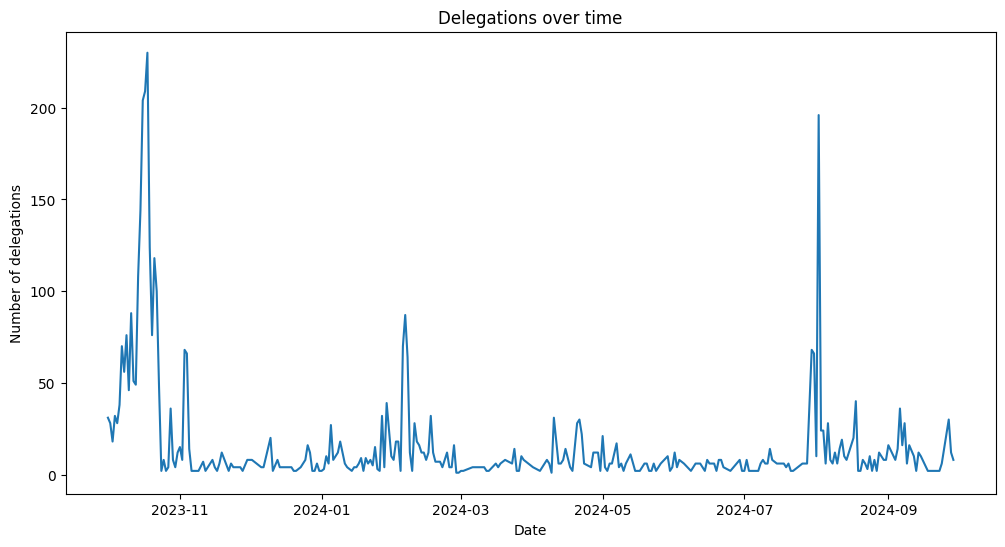

In [35]:
delegations_df = pd.DataFrame(delegations)
delegations_df['date'] = pd.to_datetime(delegations_df['timestamp'], unit='s')
delegations_df['date'] = delegations_df['date'].dt.date
delegations_over_time = delegations_df.groupby('date').size()

plt.figure(figsize=(12, 6))
delegations_over_time.plot()
plt.xlabel('Date')
plt.ylabel('Number of delegations')
plt.title('Delegations over time')
plt.show()

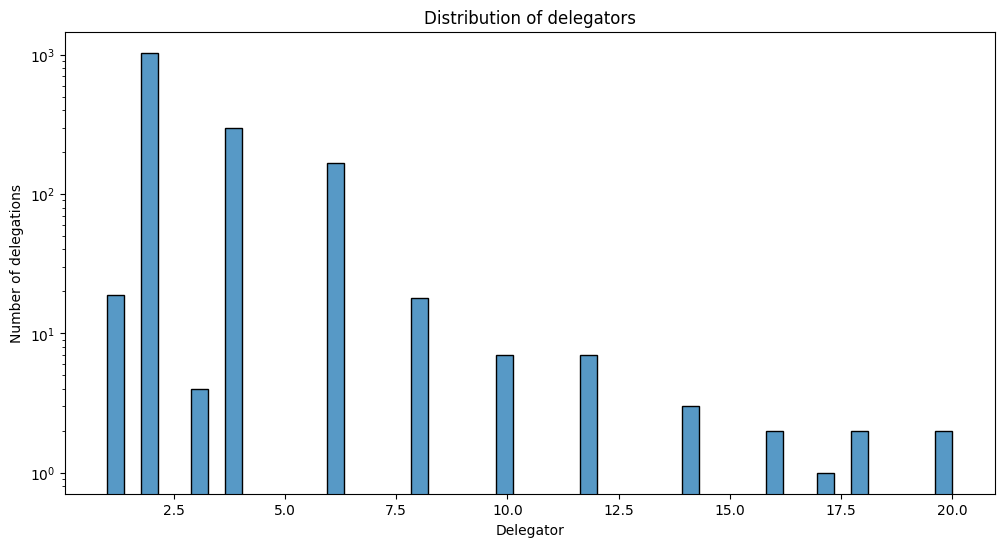

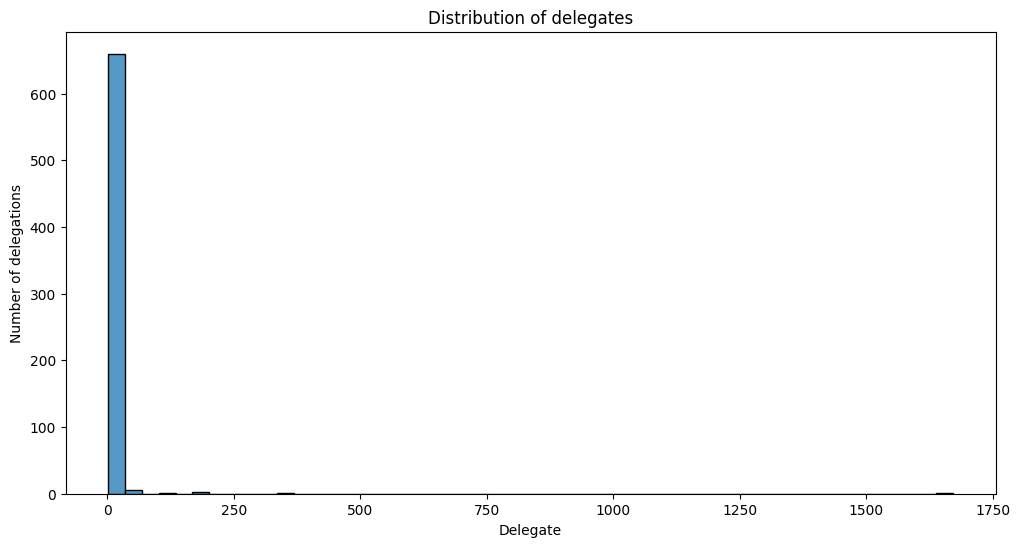

In [ ]:
delegator_counts = delegations_df['from'].value_counts()
delegate_counts = delegations_df['to'].value_counts()

plt.figure(figsize=(12, 6))
sns.histplot(delegator_counts, bins=50)
plt.yscale('log')
plt.xlabel('Delegator')
plt.ylabel('Number of delegations')
plt.title('Distribution of delegators')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(delegate_counts, bins=50)#, log_scale=(True, False))
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Delegate')
plt.ylabel('Number of delegations')
plt.title('Distribution of delegates')
plt.show()

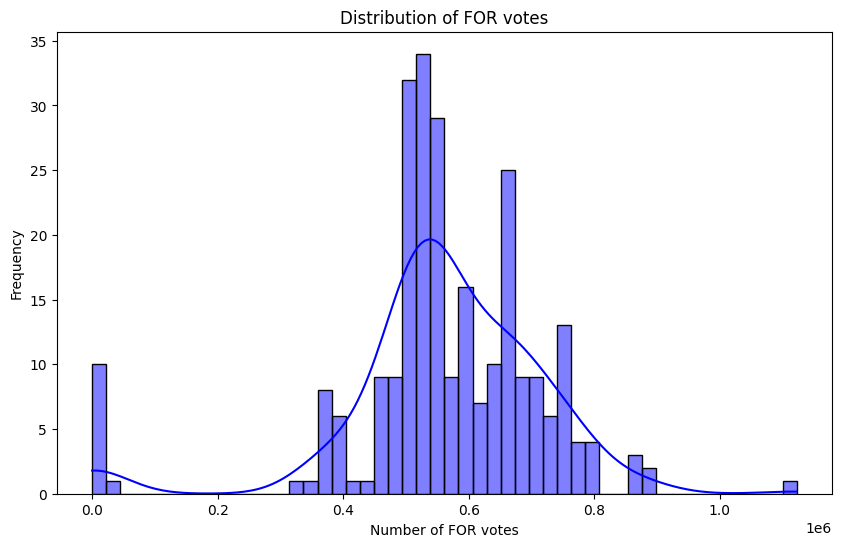

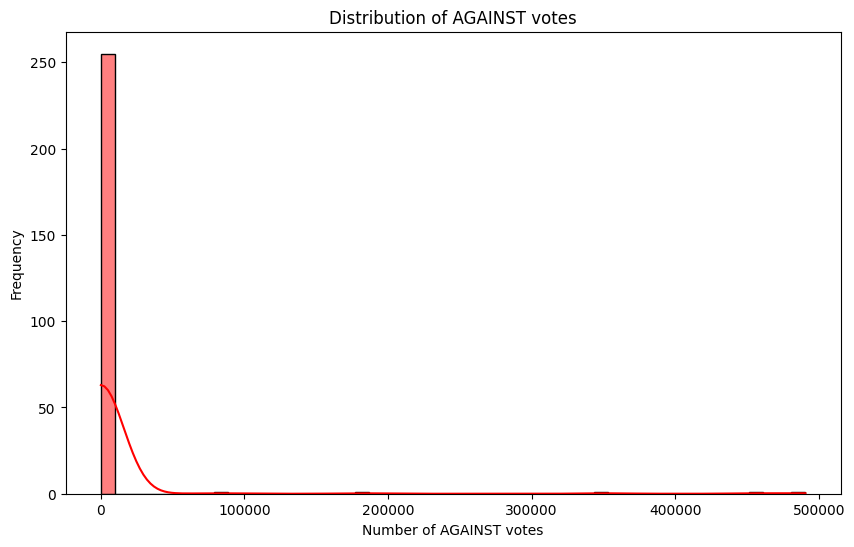

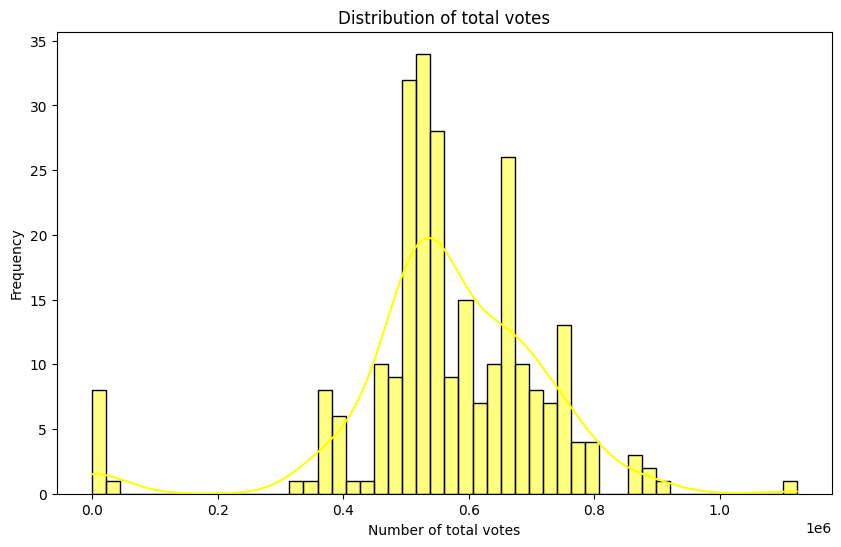

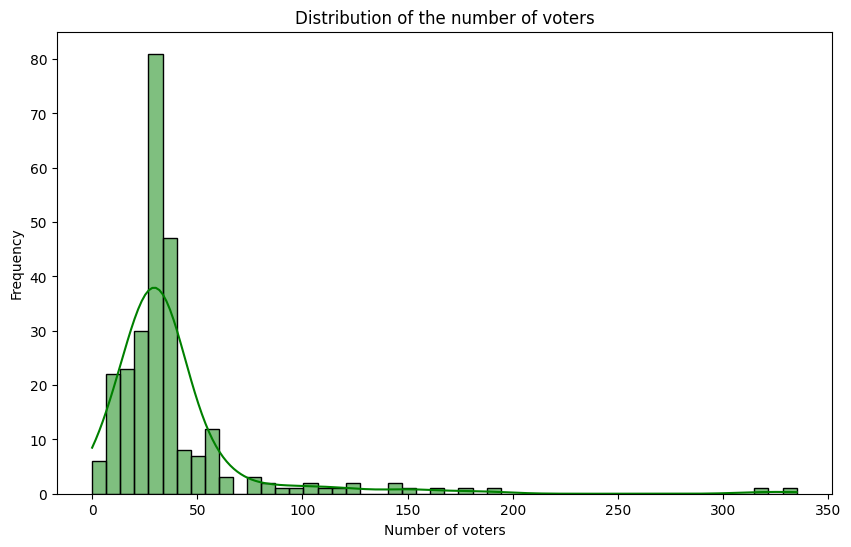

In [52]:
for_votes = {proposal['id']: float(proposal['currentYesVote']) for proposal in aave_v2_proposals} | \
            {proposal['id']: float(proposal['votes']['forVotes']) if proposal['votes'] else 0 for proposal in aave_v3_proposals}

against_votes = {proposal['id']: float(proposal['currentNoVote']) for proposal in aave_v2_proposals} | \
                {proposal['id']: float(proposal['votes']['againstVotes']) if proposal['votes'] else 0 for proposal in aave_v3_proposals}
                
total_votes = {proposal['id']: float(proposal['currentYesVote']) + float(proposal['currentNoVote']) for proposal in aave_v2_proposals} | \
              {proposal['id']: float(proposal['votes']['forVotes']) + float(proposal['votes']['againstVotes']) if proposal['votes'] else 0 for proposal in aave_v3_proposals}

num_voters = {proposal['id']: proposal['totalCurrentVoters'] for proposal in aave_v2_proposals} | \
             {proposal['id']: proposal['totalCurrentVoters'] for proposal in aave_v3_proposals}

plt.figure(figsize=(10, 6))
sns.histplot(for_votes, bins=50, color='blue', kde=True)
plt.xlabel('Number of FOR votes')
plt.ylabel('Frequency')
plt.title('Distribution of FOR votes')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(against_votes, bins=50, color='red', kde=True)
plt.xlabel('Number of AGAINST votes')
plt.ylabel('Frequency')
plt.title('Distribution of AGAINST votes')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(total_votes, bins=50, color='yellow', kde=True)
plt.xlabel('Number of total votes')
plt.ylabel('Frequency')
plt.title('Distribution of total votes')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(num_voters, bins=50, color='green', kde=True)
plt.xlabel('Number of voters')
plt.ylabel('Frequency')
plt.title('Distribution of the number of voters')
plt.show()

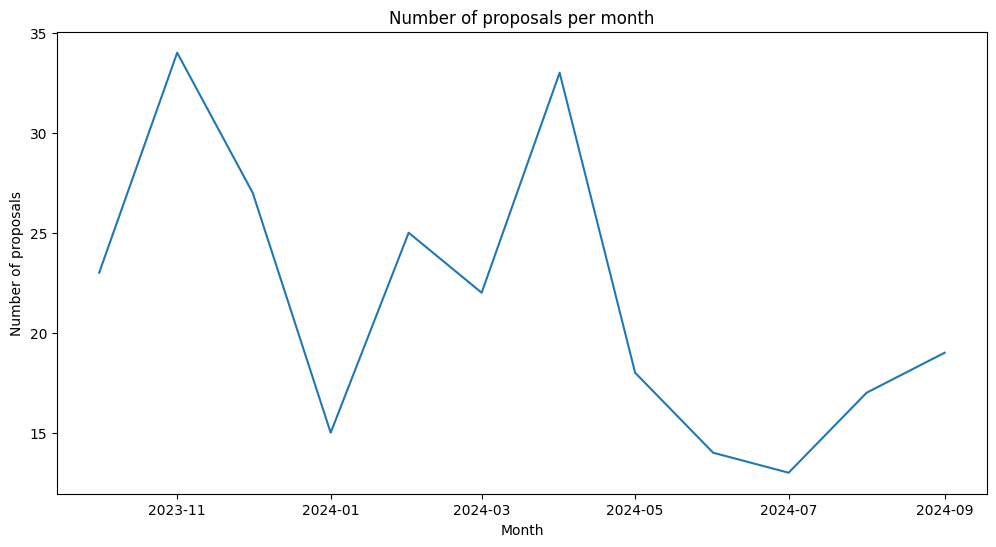

In [91]:
all_proposal_dates = [datetime.fromtimestamp(proposal['timestamp']) for proposal in aave_v2_proposals] + \
                     [datetime.fromtimestamp(int(proposal['transactions']['created']['timestamp'])) for proposal in aave_v3_proposals]

proposal_dates_df = pd.DataFrame({'date': all_proposal_dates})
proposal_dates_df['month'] = proposal_dates_df['date'].dt.to_period('M')

proposals_per_month = proposal_dates_df.groupby('month').size().reset_index(name='count')

proposals_per_month['month'] = proposals_per_month['month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(proposals_per_month['month'], proposals_per_month['count'])
plt.xlabel('Month')
plt.ylabel('Number of proposals')
plt.title('Number of proposals per month')
plt.show()

### Features

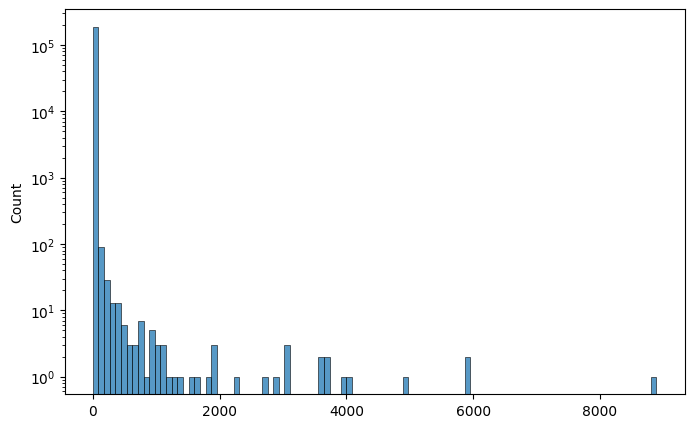

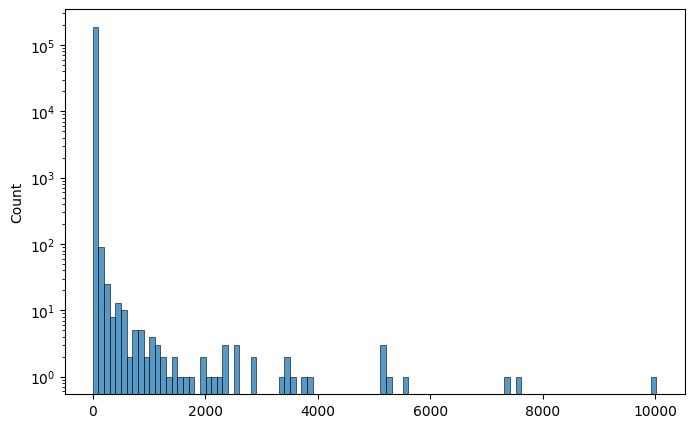

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(aave_igraph_in_dc, bins=100)
plt.yscale('log')
plt.xlabel("In degree")
plt.ylabel("Count")
plt.title("AAVE in degree distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(aave_igraph_out_dc, bins=100)
plt.yscale('log')
plt.xlabel("Out degree")
plt.ylabel("Count")
plt.title("AAVE out degree distribution")
plt.show()

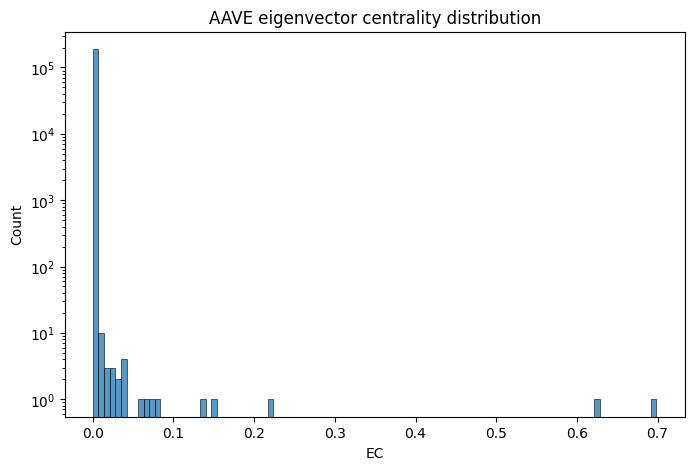

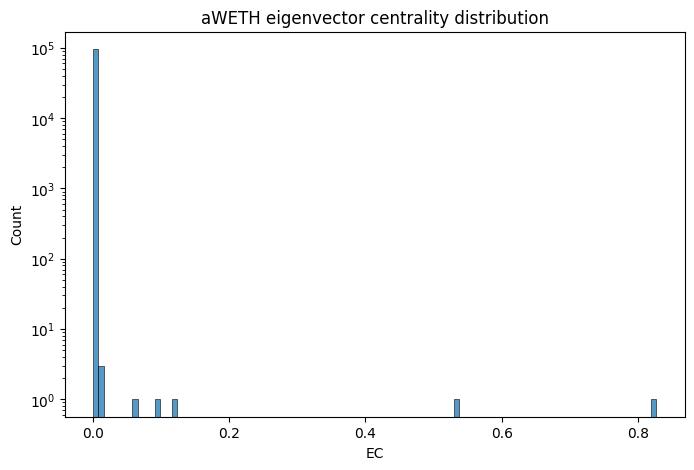

In [125]:
plt.figure(figsize=(8,5))
sns.histplot(aave_igraph_ec, bins=100)
plt.yscale('log')
plt.xlabel("EC")
plt.ylabel("Count")
plt.title("AAVE eigenvector centrality distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(aWETH_igraph_ec, bins=100)
plt.yscale('log')
plt.xlabel("EC")
plt.ylabel("Count")
plt.title("aWETH eigenvector centrality distribution")
plt.show()

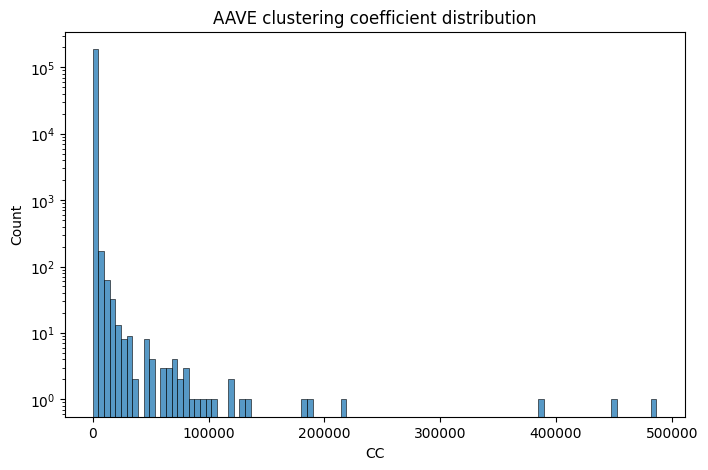

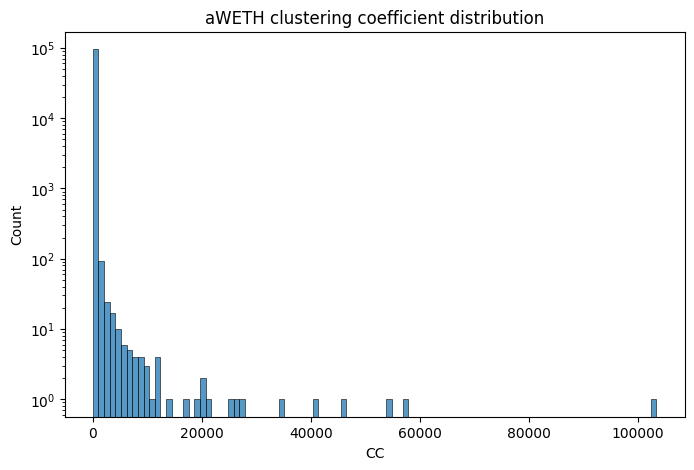

In [126]:
plt.figure(figsize=(8,5))
sns.histplot(aave_igraph_cc, bins=100)
plt.yscale('log')
plt.xlabel("CC")
plt.ylabel("Count")
plt.title("AAVE clustering coefficient distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(aWETH_igraph_cc, bins=100)
plt.yscale('log')
plt.xlabel("CC")
plt.ylabel("Count")
plt.title("aWETH clustering coefficient distribution")
plt.show()

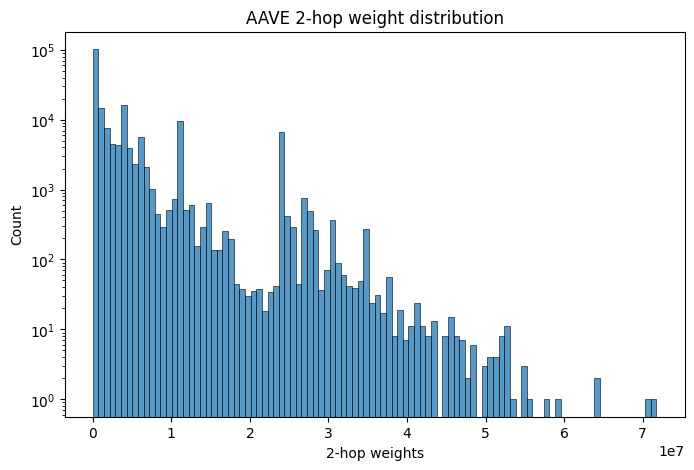

In [129]:
plt.figure(figsize=(8,5))
sns.histplot(aave_igraph_2_hop_weights, bins=100)
plt.yscale('log')
plt.xlabel("2-hop weights")
plt.ylabel("Count")
plt.title("AAVE 2-hop weight distribution")
plt.show()

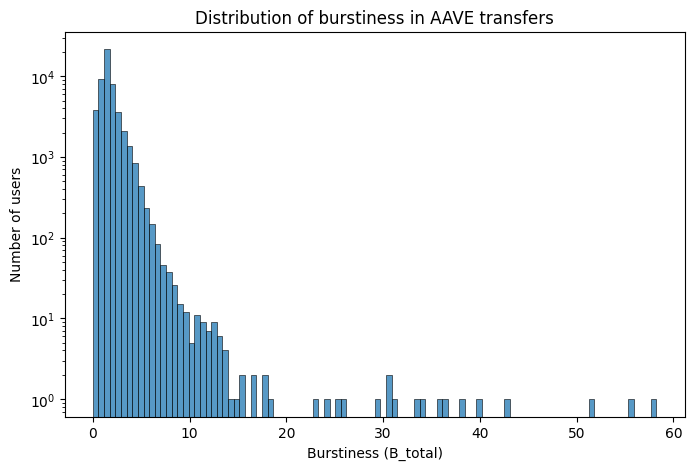

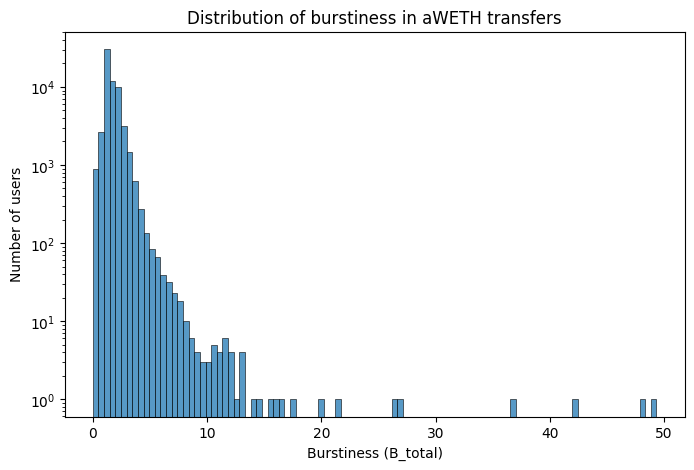

In [116]:
plt.figure(figsize=(8,5))
sns.histplot(aave_burstiness_total, bins=100)
plt.yscale('log')
plt.xlabel("Burstiness (B_total)")
plt.ylabel("Number of users")
plt.title("Distribution of burstiness in AAVE transfers")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(aWETH_burstiness_total, bins=100)
plt.yscale('log')
plt.xlabel("Burstiness (B_total)")
plt.ylabel("Number of users")
plt.title("Distribution of burstiness in aWETH transfers")
plt.show()

### Correlations

### Leiden

### SI